In [1]:
#load dependencies 
import pandas as pd
import numpy as np
from fredapi import Fred
from config import key, pwrd
from tqdm import tqdm, tqdm_notebook
import warnings
import time
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress




In [2]:
#define FRED API call
fred = Fred(api_key= key)

In [3]:
#set column view options
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 50)

In [4]:
# Code to search FRED database
# search = fred.search('500', order_by='popularity', sort_order='desc')
# search_df = pd.DataFrame(search[['title', 'id', 'popularity', 'units','seasonal_adjustment_short']])
# search_df[:20]

In [5]:
#desired indicators
indicators = ['USSLIND', 'UMCSENT', 'CSCICP03USM665S', 'INDPRO', 'TCU','DGORDER', 'NEWORDER', 'PI','BUSINV', 'TOTALSA',
             'MARTSMPCSM44X72USS', 'PAYEMS', 'UNRATE', 'ICSA', 'CCSA', 'CC4WSA', 'NPPTTL', 'CES0500000003', 'HSN1F',
             'EXHOSLUSM495S', 'PERMIT', 'CSUSHPINSA', 'SP500']

In [6]:
print(f'{len(indicators)} indicators to download')

23 indicators to download


In [7]:
#set start date
date = input("Choose start date in mm/dd/yyyy format")

Choose start date in mm/dd/yyyy format01/02/2000


In [8]:
#create FRED dataframe function
def fred_df(series):
    data =  fred.get_series(series, observation_start= date)
    info = fred.get_series_info(series)
    data_df = pd.DataFrame(data)
    data_df.reset_index(level=0, inplace=True)
    info_df = pd.DataFrame(info)
    info_df.reset_index(level=0, inplace=True)
    #pivot info_df
    df_dict = dict(zip(info_df['index'],info_df[0]))
    info_df = pd.DataFrame(df_dict,  index=[0])
    #duplicate info_df rows to equal data_df length
    info_df = pd.concat([info_df]*(len(data_df)), ignore_index=True)
    global combine_df
    #join df's
    combine_df = data_df.join(info_df)
    #rename columns
    combine_df.rename(columns = {'index':'date', 0:'data'}, inplace = True) 
    #create new 'change from last column'
    combine_df.insert(2, 'change', np.nan)
    #fill nan with zeroes
    combine_df['change'].fillna(0, inplace=True)
    #create data for 'change' column
    changes = [combine_df.iloc[i,1]-combine_df.iloc[i-1,1] for i in range (1,len(combine_df))]
    change_clean = [float("{0:.3f}".format(x)) for x in changes]
    combine_df['change'][1:len(combine_df)] = change_clean
    #create pct_change column
    combine_df.insert(3,'pct_change',np.nan)
    #fill nan with zeroes
    combine_df['pct_change'].fillna(0, inplace=True)
    #create data for pct_change col
    pct_change = [(combine_df.iloc[i,1]/combine_df.iloc[i-1,1] - 1) *100 for i in range(1,len(combine_df))]
    pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
    combine_df['pct_change'][1:len(combine_df)] = pct_clean

In [9]:
#define functions for Koyfin csv
def add_series(path):
    path1 = path
    #remove quotes
    path1 = path1.replace('"', '')
    #read into pandas
    global series1
    series1 = pd.read_csv(path1)
    if type(series1.iloc[0,-1]) == str:
        #change last column to float
        series1.iloc[:,-1] = series1.iloc[:,-1].str.replace(',', '').astype(float)
    #add change column
    add_change(series1)
    #add pct change column
    add_pct(series1)
    #rename date col
    series1.rename(columns={" Date":"Date"}, inplace = True)
    #convert Date col from object to datetime
    series1['Date'] = pd.to_datetime(series1['Date'], errors = 'ignore')
    #show heading
    return series1.head()

def add_change(series):
    #calculate change col for series1, convert strings to floats
    changes = [series.iloc[i,-1] - series.iloc[i-1,-1] for i in range (1,len(series))]
    #round the results
    change_clean = [float("{0:.3f}".format(x)) for x in changes]
    #create change column
    series.insert(1, 'change', np.nan_to_num(0))
    #insert the data from second row to the end
    series['change'][1:len(series)] = change_clean
    
def add_pct(series):
    #calculate percent change col for series1
    pct_change = [(series.iloc[i,-1]/series.iloc[i-1,-1] -1) * 100 for i in range(1,len(series))]
    #round the results
    pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
    #create pct_change column
    series.insert(1, 'pct_change', np.nan_to_num(0))
    #insert the data from second row to the end
    series['pct_change'][1:len(series)] = pct_clean
    

In [18]:
#add path for csv containting SPX MONTHLY data
file1 = input("Paste path for the SPX data: ")
#run add_series function to transform csv into a df with change and pct_change columns added
add_series(file1)
#define resulting df as indic1
spx_df = series1
#show column names
print(f'Column headers for 1st indictaor are: {spx_df.columns}')
#show first five rows
spx_df.head()

Paste path for the SPX data: data/koyfin_spx_month.csv
Column headers for 1st indictaor are: Index(['Date', 'pct_change', 'change', 'SPX Close', 'SPX Adj. Close'], dtype='object')


Date  pct_change  change SPX Close  SPX Adj. Close
0 2020-06-15       0.000    0.00  3,028.00         3028.00
1 2020-05-29       0.539   16.31  3,044.31         3044.31
2 2020-04-30      -4.332 -131.88  2,912.43         2912.43
3 2020-03-31     -11.257 -327.84  2,584.59         2584.59
4 2020-02-28      14.301  369.63  2,954.22         2954.22

In [19]:
#convert Date column to month year 
spx_df['Date'] = spx_df['Date'].dt.strftime('%m/%Y')

In [20]:
spx_df.head()

Date  pct_change  change SPX Close  SPX Adj. Close
0  06/2020       0.000    0.00  3,028.00         3028.00
1  05/2020       0.539   16.31  3,044.31         3044.31
2  04/2020      -4.332 -131.88  2,912.43         2912.43
3  03/2020     -11.257 -327.84  2,584.59         2584.59
4  02/2020      14.301  369.63  2,954.22         2954.22

In [16]:
#function to make charts monthly and plot monthly change
def monthly(df):
    #make date col the index
    df = df.reset_index().set_index('date')
    #resample df to Monthly Business freq, take last value
    df = df.resample('BM').last()
    #reset index
    df.reset_index(level=0, inplace=True)
    #drop old change, pct_change and index 
    df.drop(['change','pct_change', 'index'], axis=1, inplace=True)
    #re-calc change and pct_change
    #create new 'change from last column'
    df.insert(2, 'change', np.nan)
    #fill nan with zeroes
    df['change'].fillna(0, inplace=True)
    #create data for 'change' column
    changes = [df.iloc[i,1]-df.iloc[i-1,1] for i in range (1,len(df))]
    change_clean = [float("{0:.3f}".format(x)) for x in changes]
    df['change'][1:len(df)] = change_clean
    #create pct_change column
    df.insert(3,'pct_change',np.nan)
    #fill nan with zeroes
    df['pct_change'].fillna(0, inplace=True)
    #create data for pct_change col
    pct_change = [(df.iloc[i,1]/df.iloc[i-1,1] - 1) * 10 for i in range(1,len(df))]
    pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
    df['pct_change'][1:len(df)] = pct_clean
    #change frequency
    df.replace({'frequency': 'Daily, Close'}, 'Monthly, Close', inplace=True)
    df.replace({'frequency_short': 'D'}, 'M', inplace=True)
    global month_df
    month_df = df

    return month_df.head()
    
    
    

USSLIND retrieved.
UMCSENT retrieved.
CSCICP03USM665S retrieved.
INDPRO retrieved.
TCU retrieved.
DGORDER retrieved.
NEWORDER retrieved.
PI retrieved.
error with BUSINV data. Proceeding...
[Errno 13] Permission denied: 'data/BUSINV.csv'
TOTALSA retrieved.
MARTSMPCSM44X72USS retrieved.
PAYEMS retrieved.
UNRATE retrieved.
ICSA retrieved.
CCSA retrieved.
CC4WSA retrieved.
NPPTTL retrieved.
CES0500000003 retrieved.
HSN1F retrieved.
EXHOSLUSM495S retrieved.
PERMIT retrieved.
CSUSHPINSA retrieved.
SP500 retrieved.



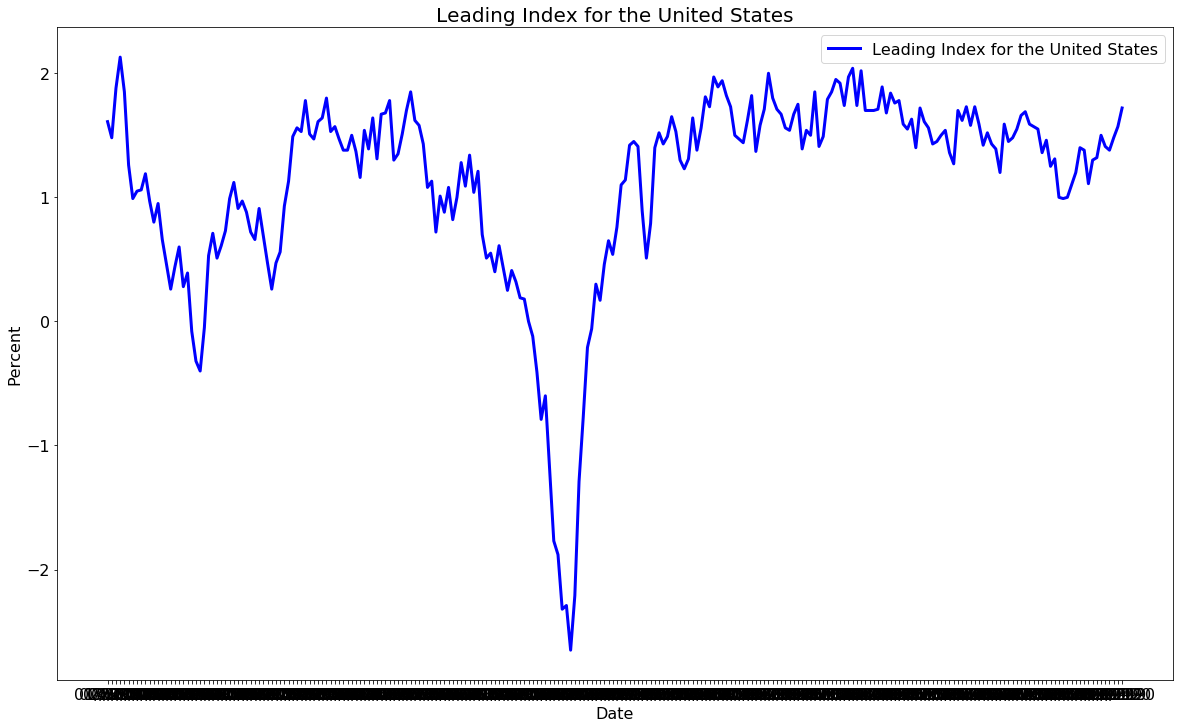

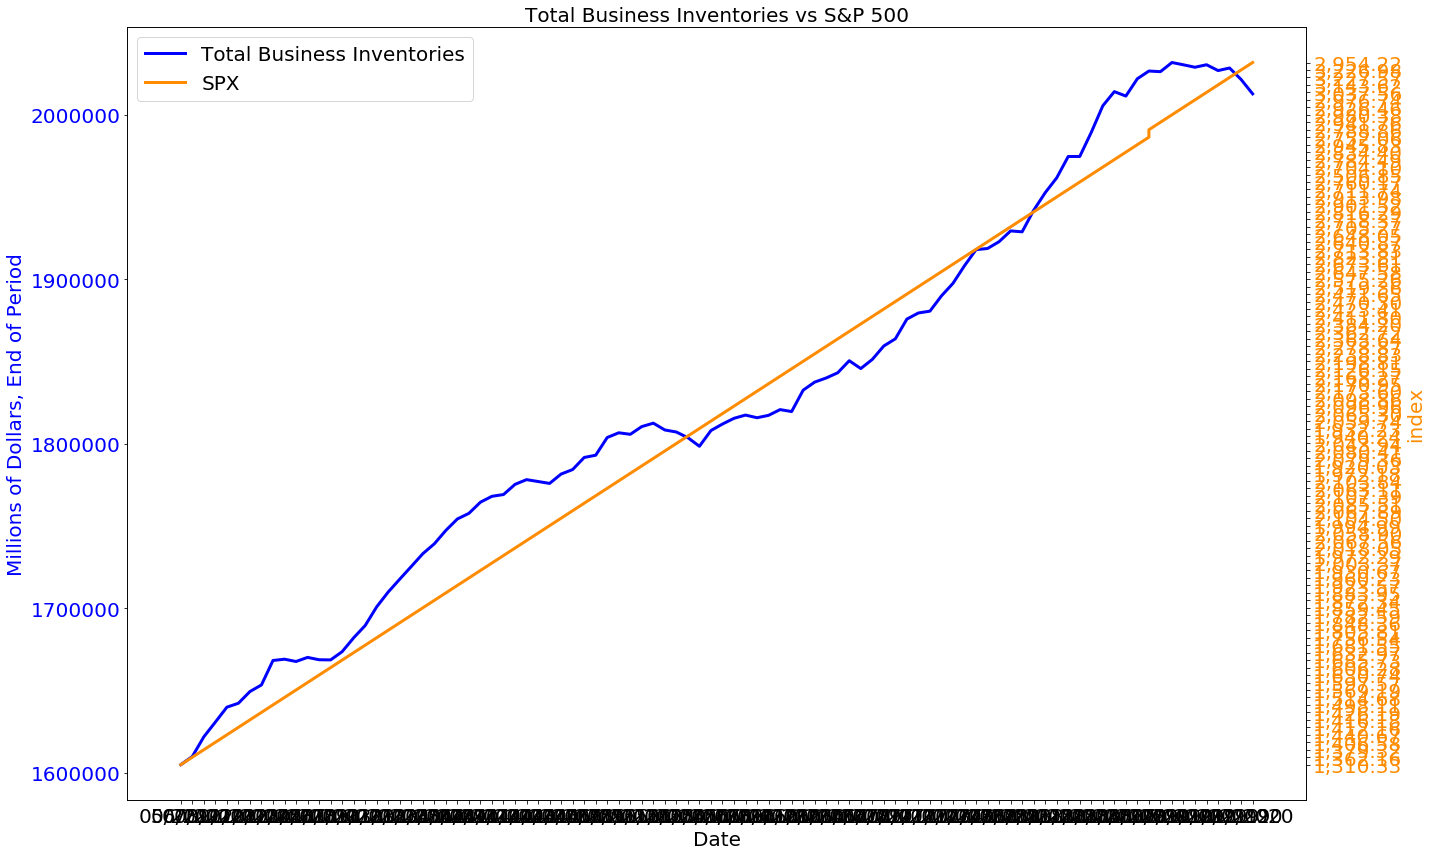

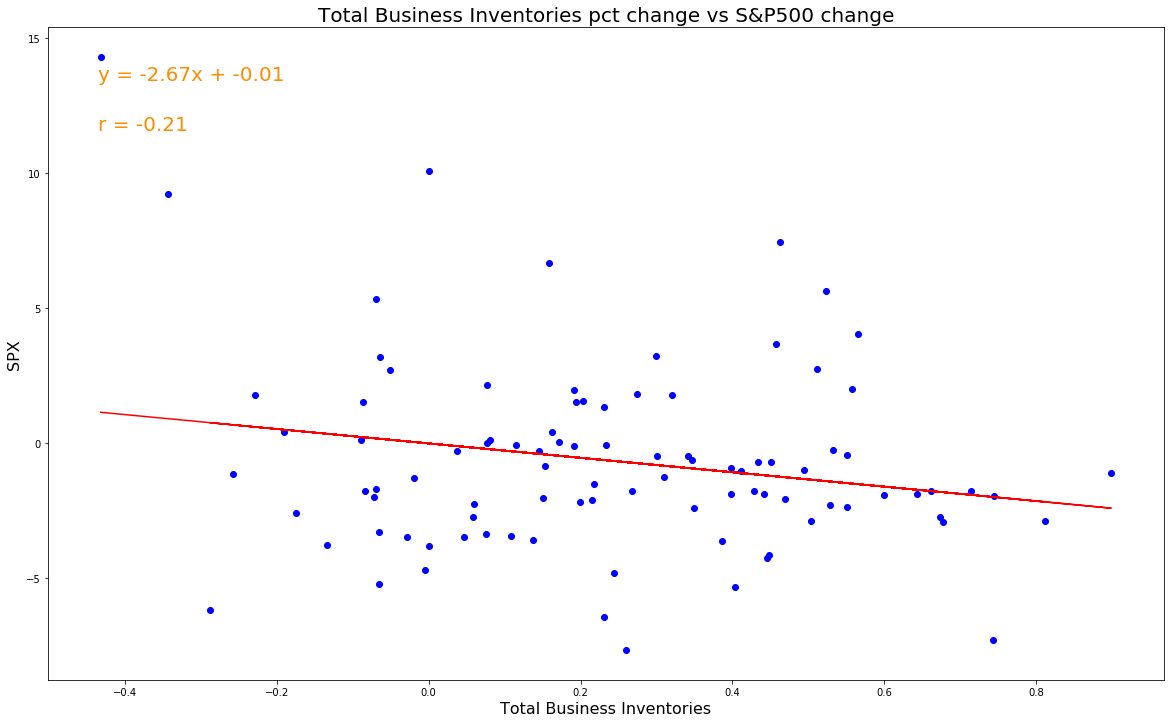

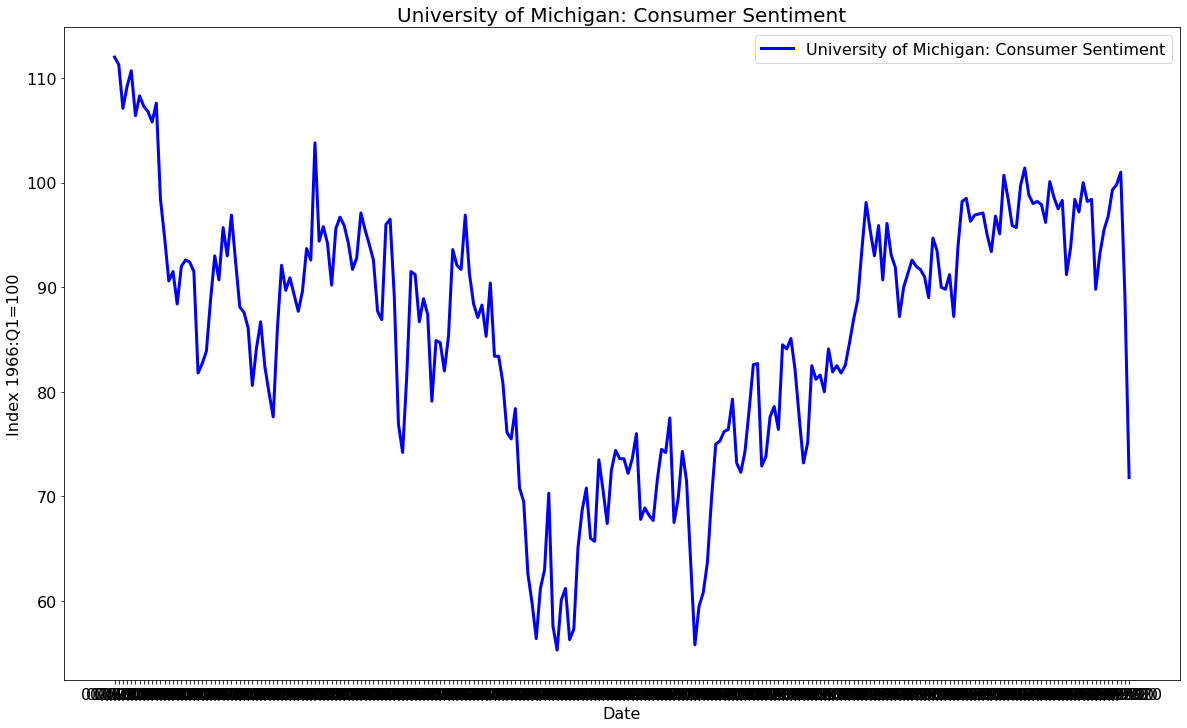

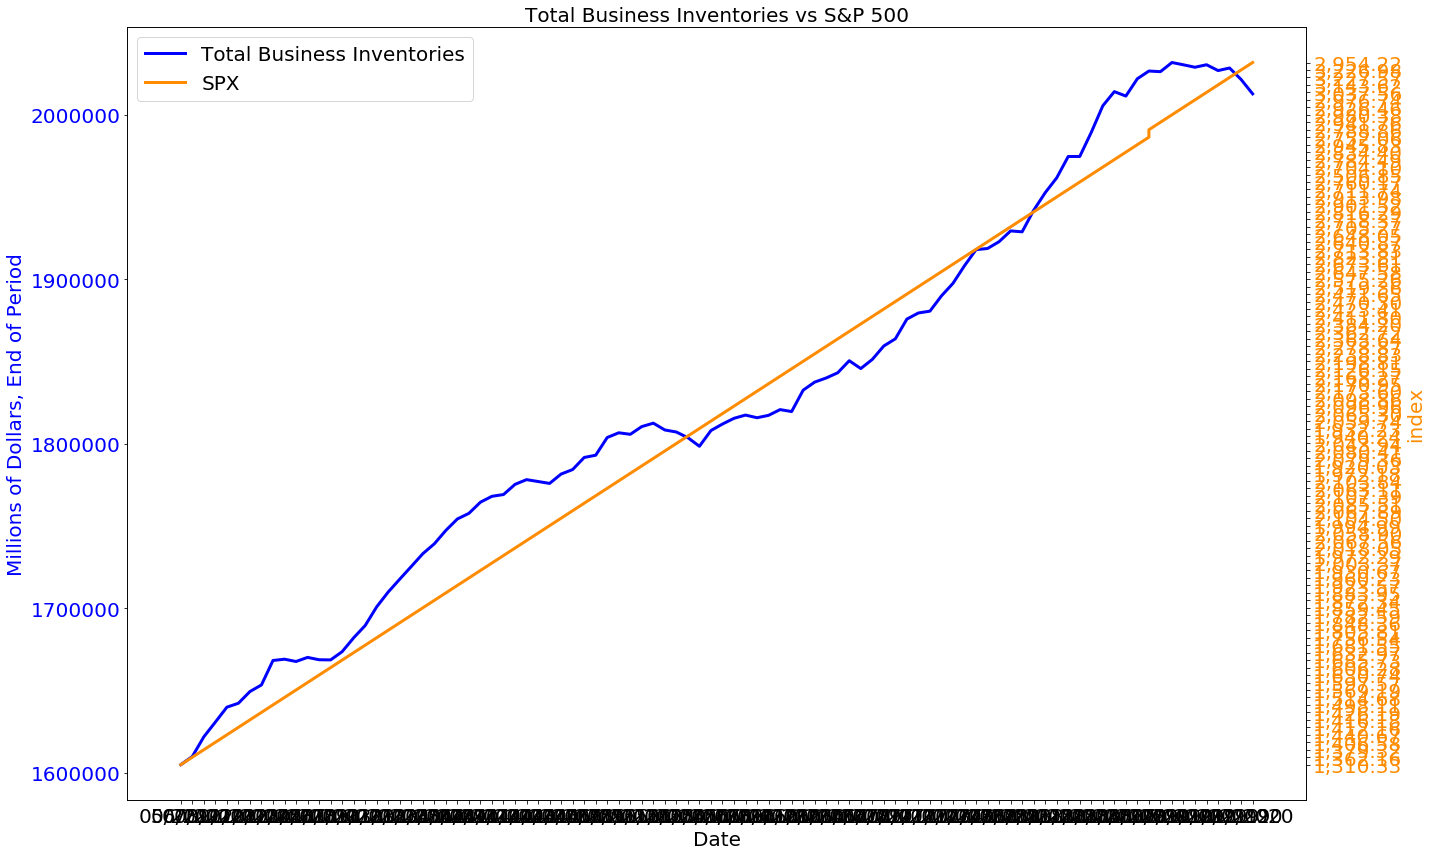

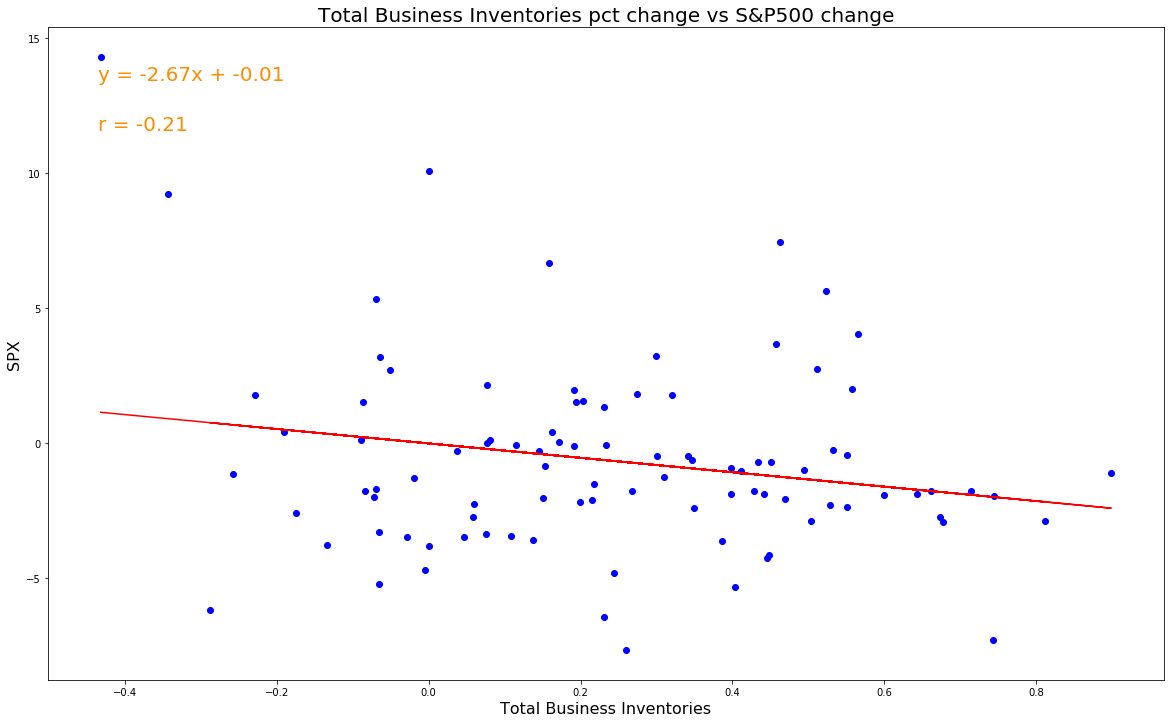

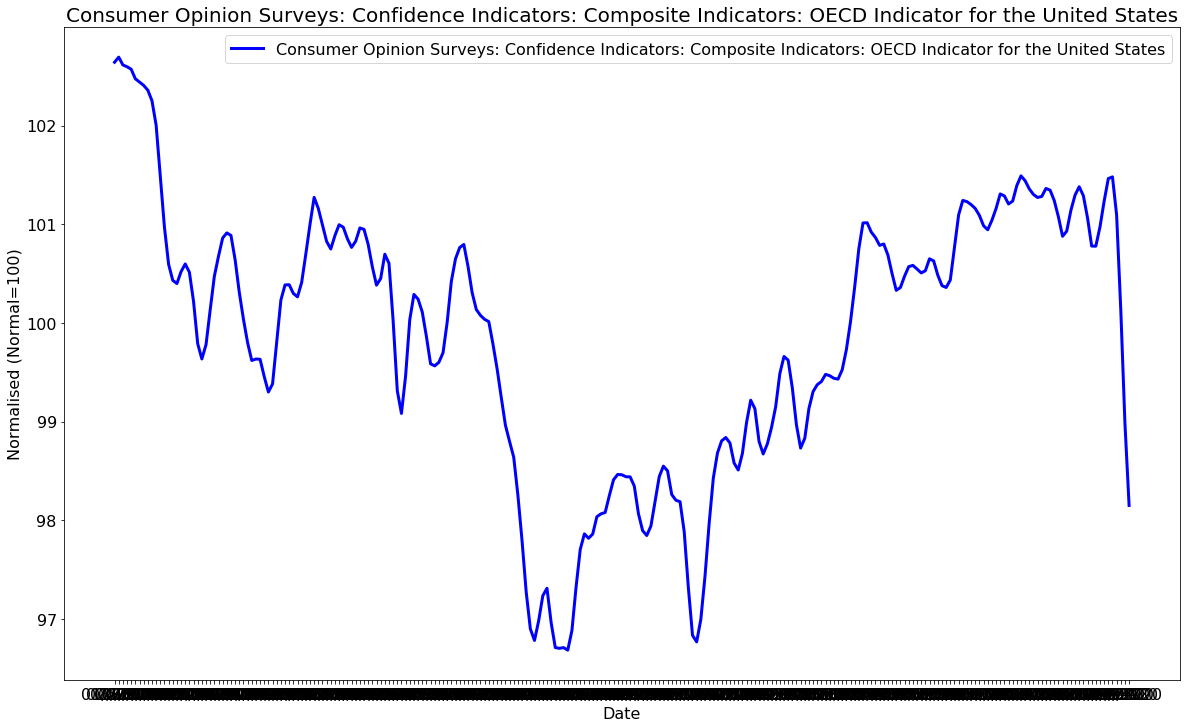

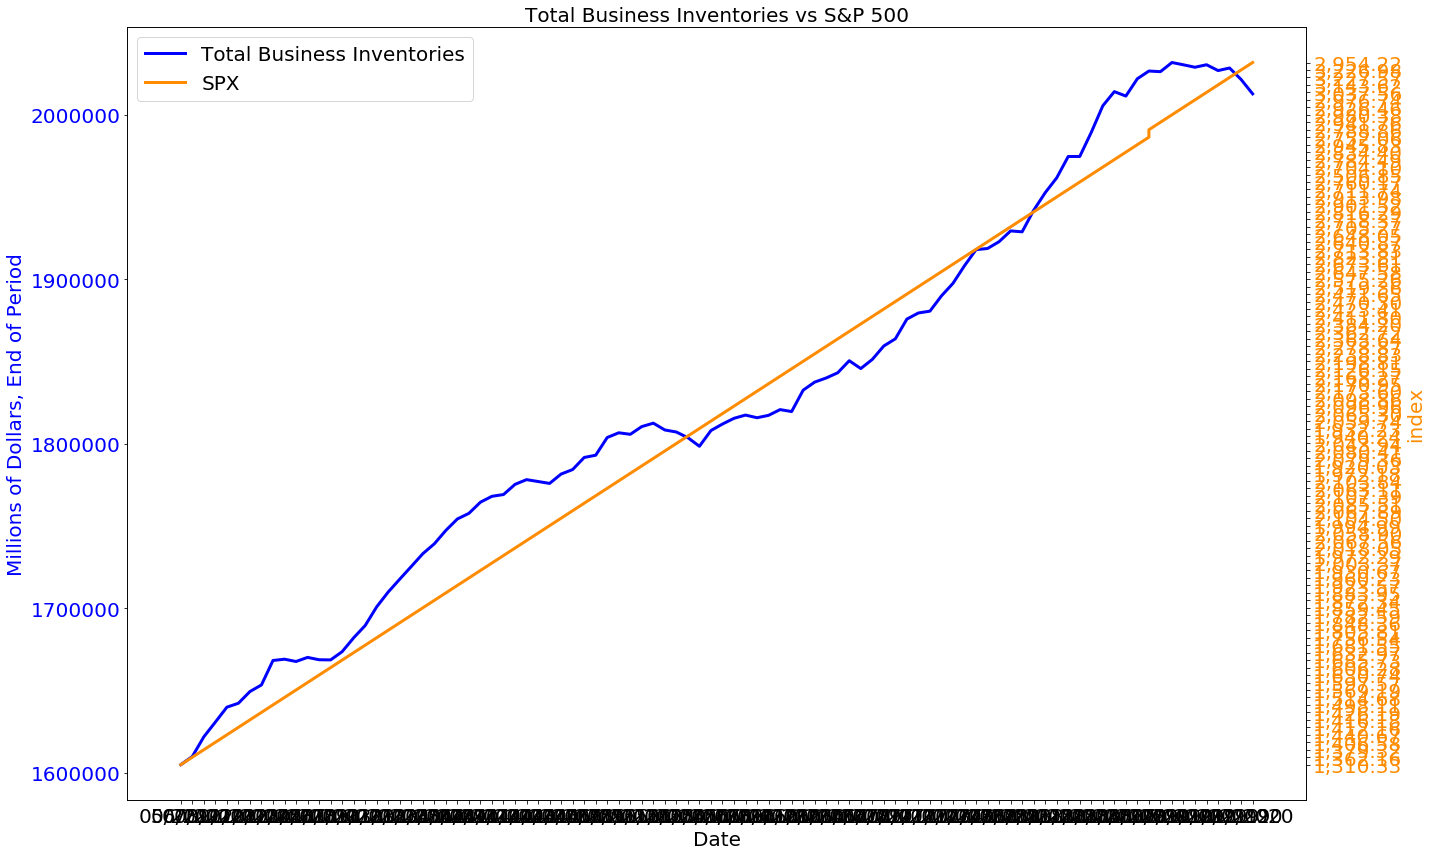

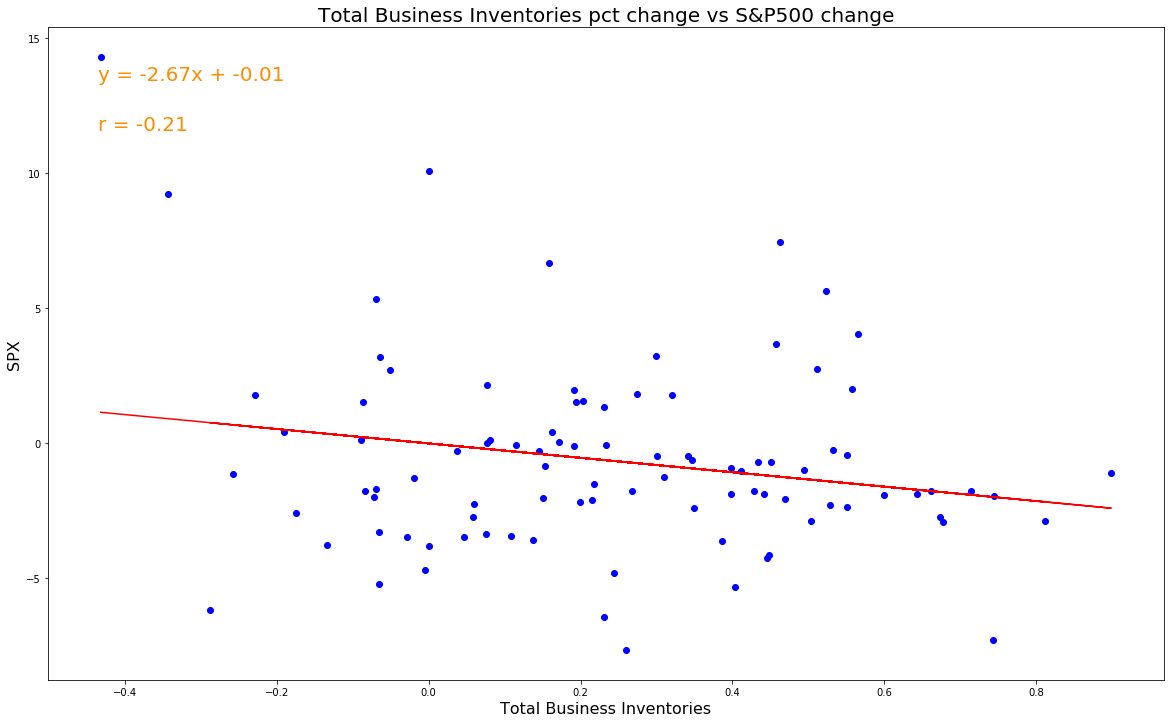

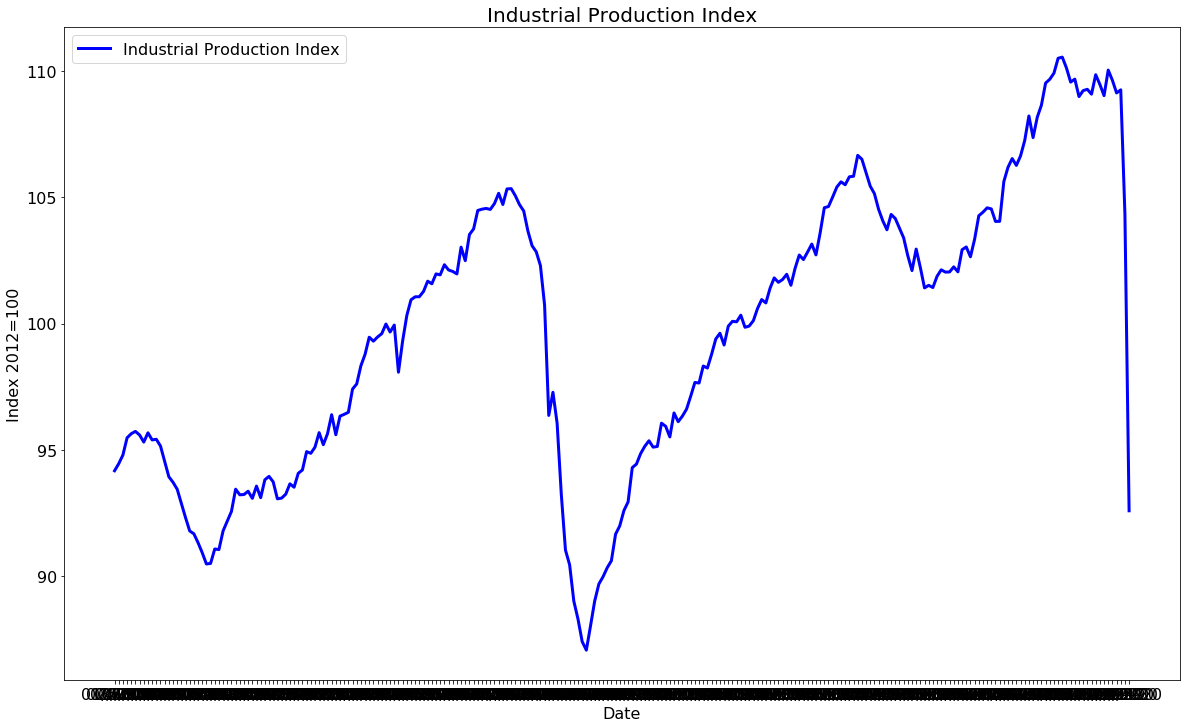

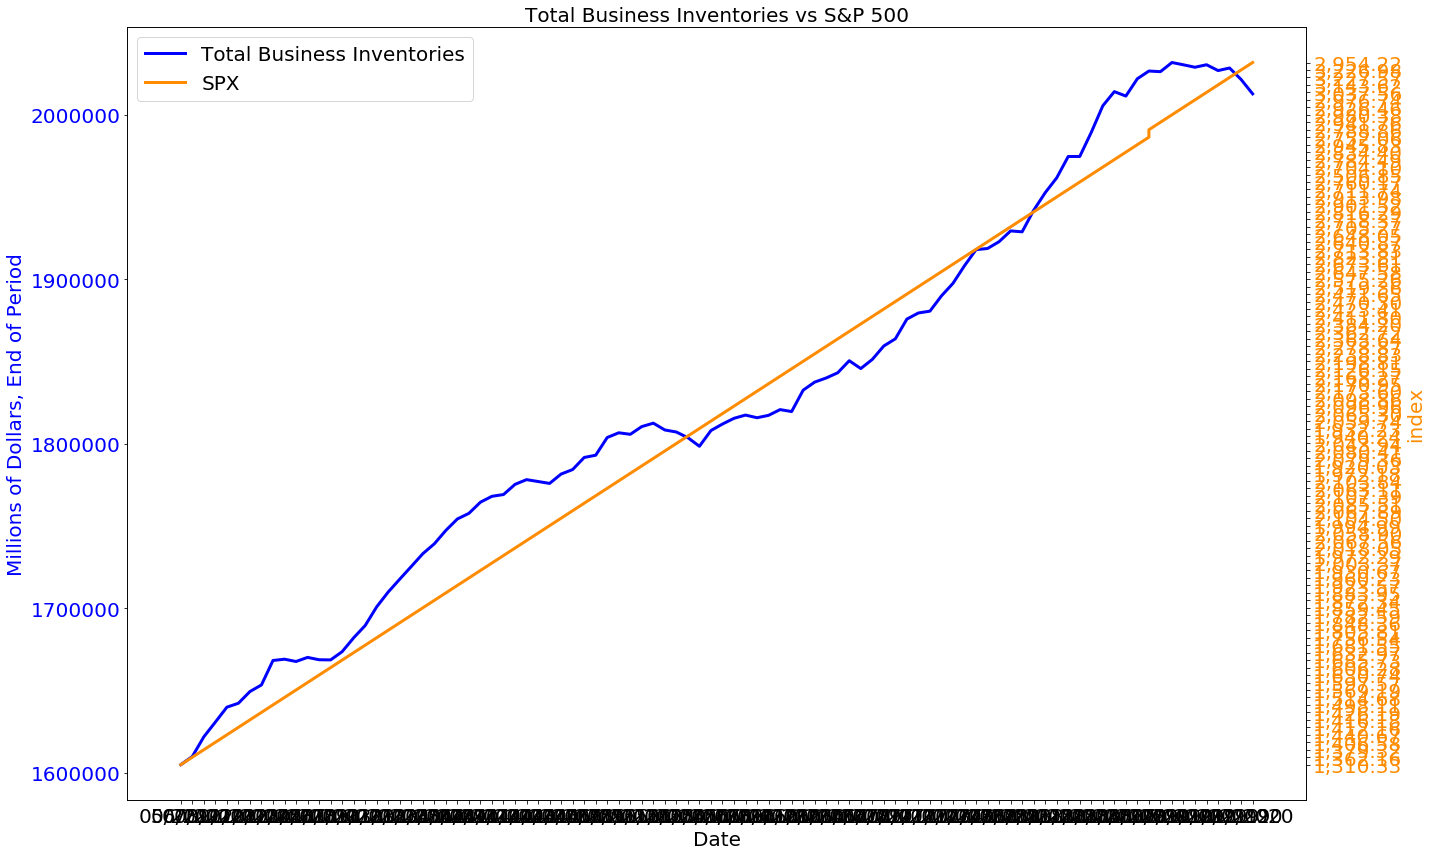

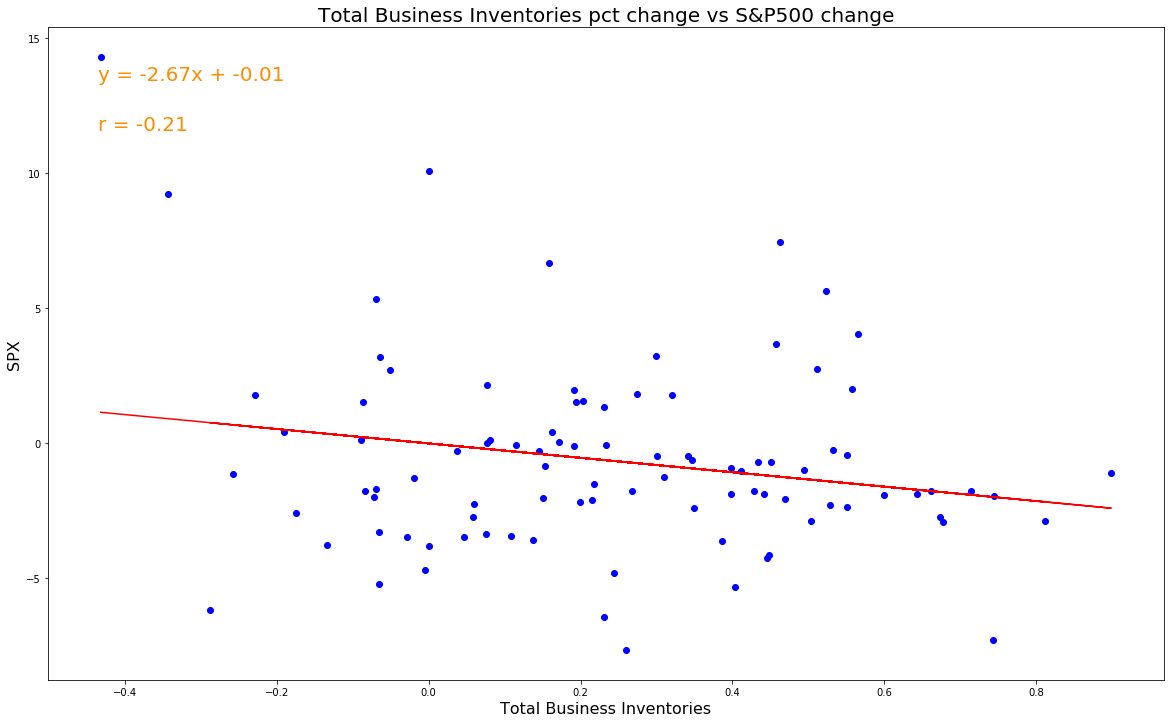

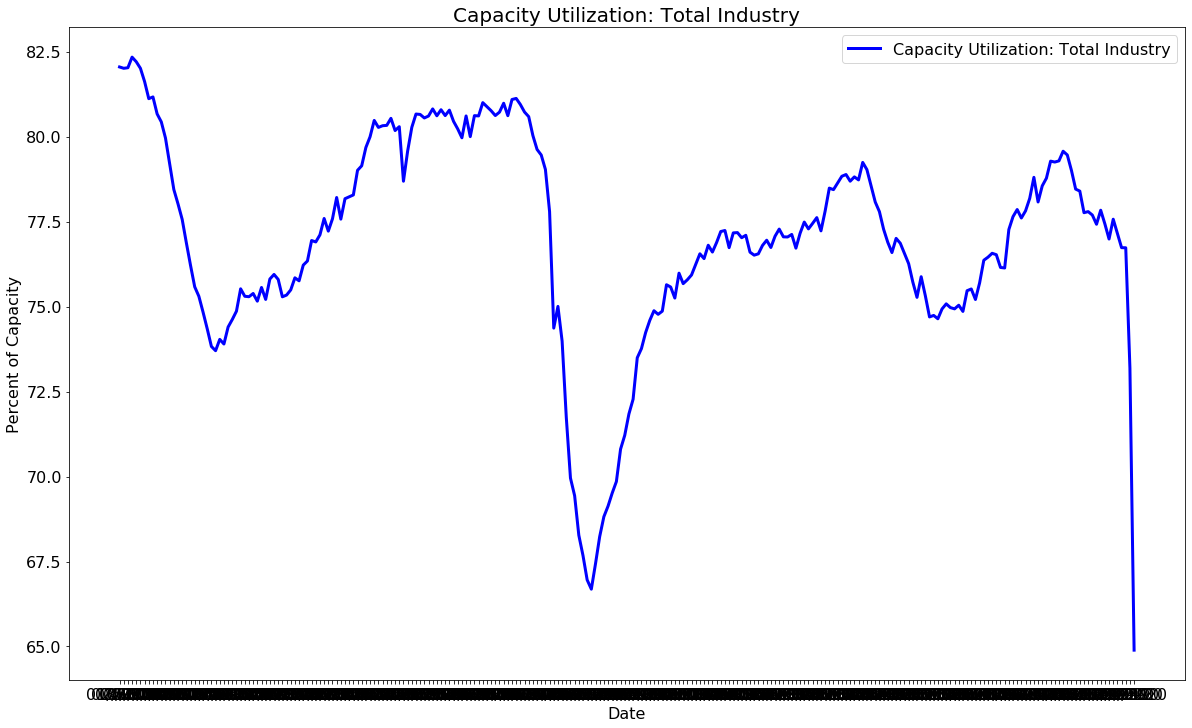

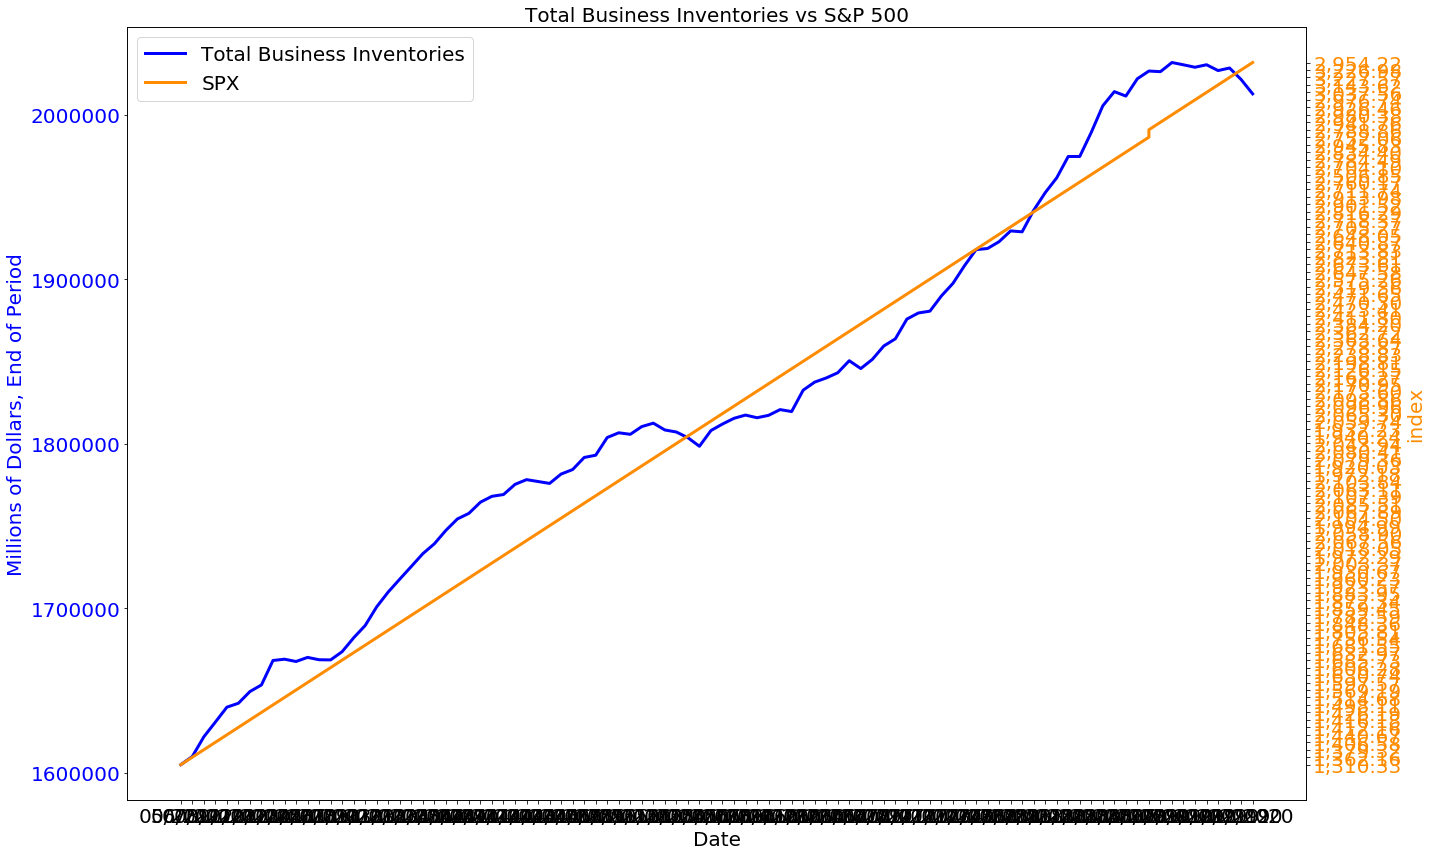

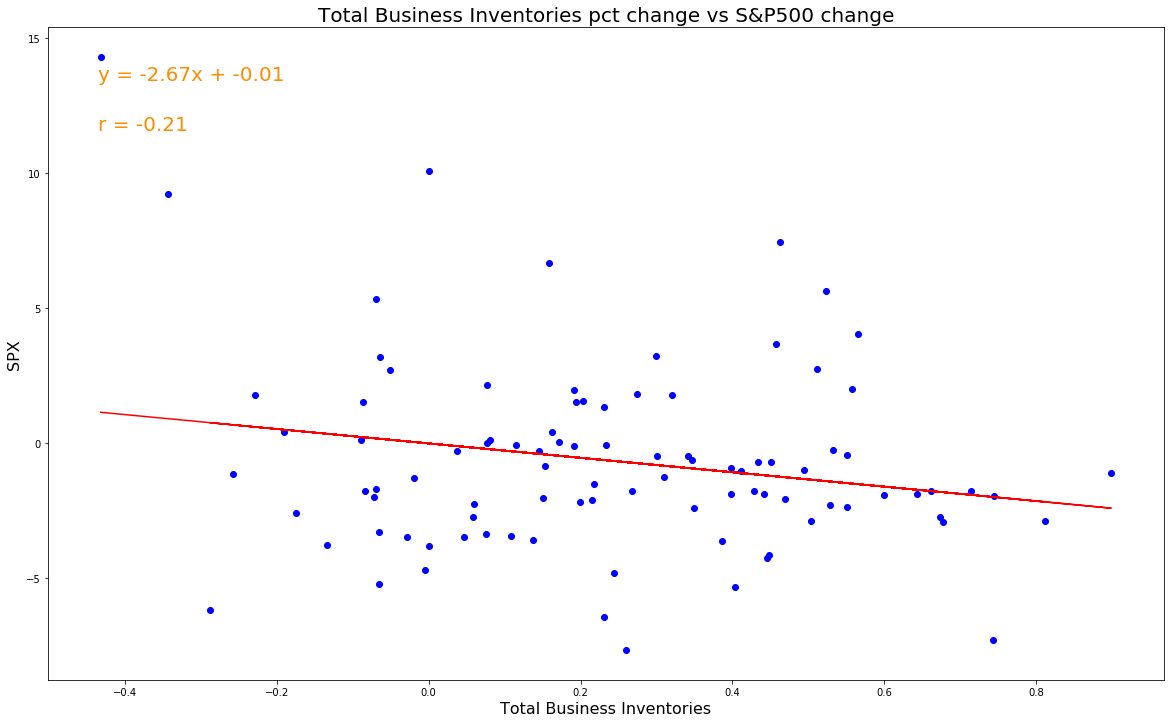

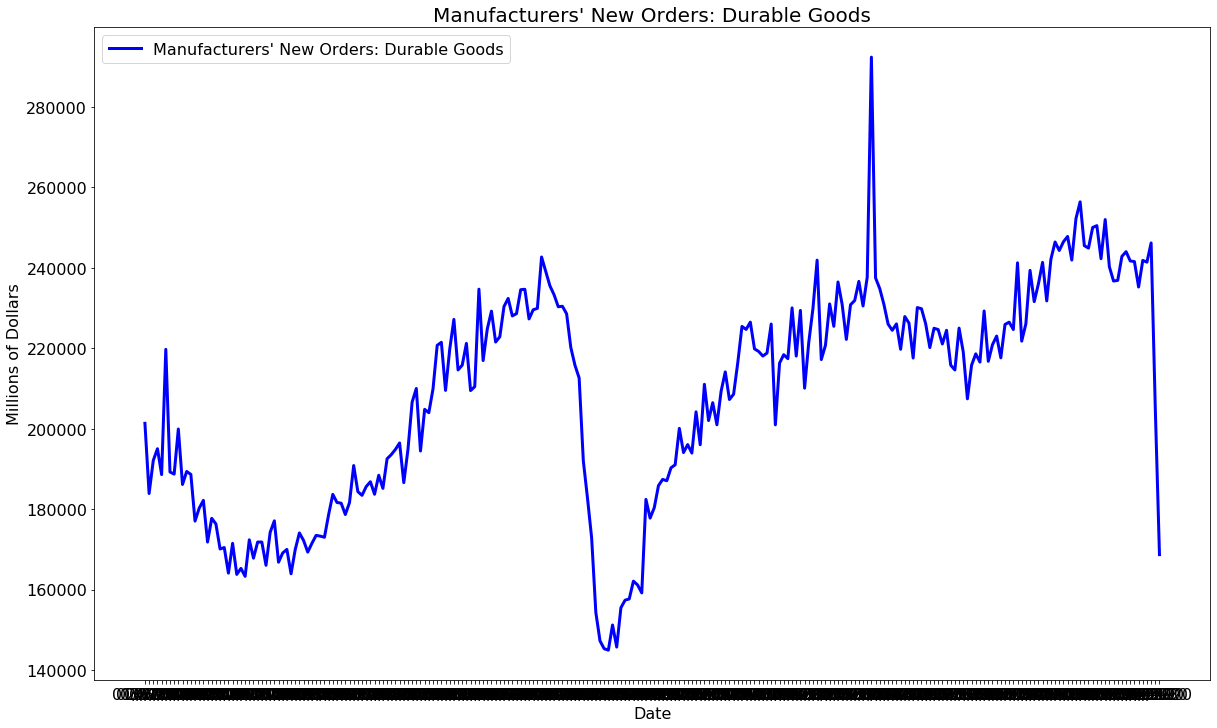

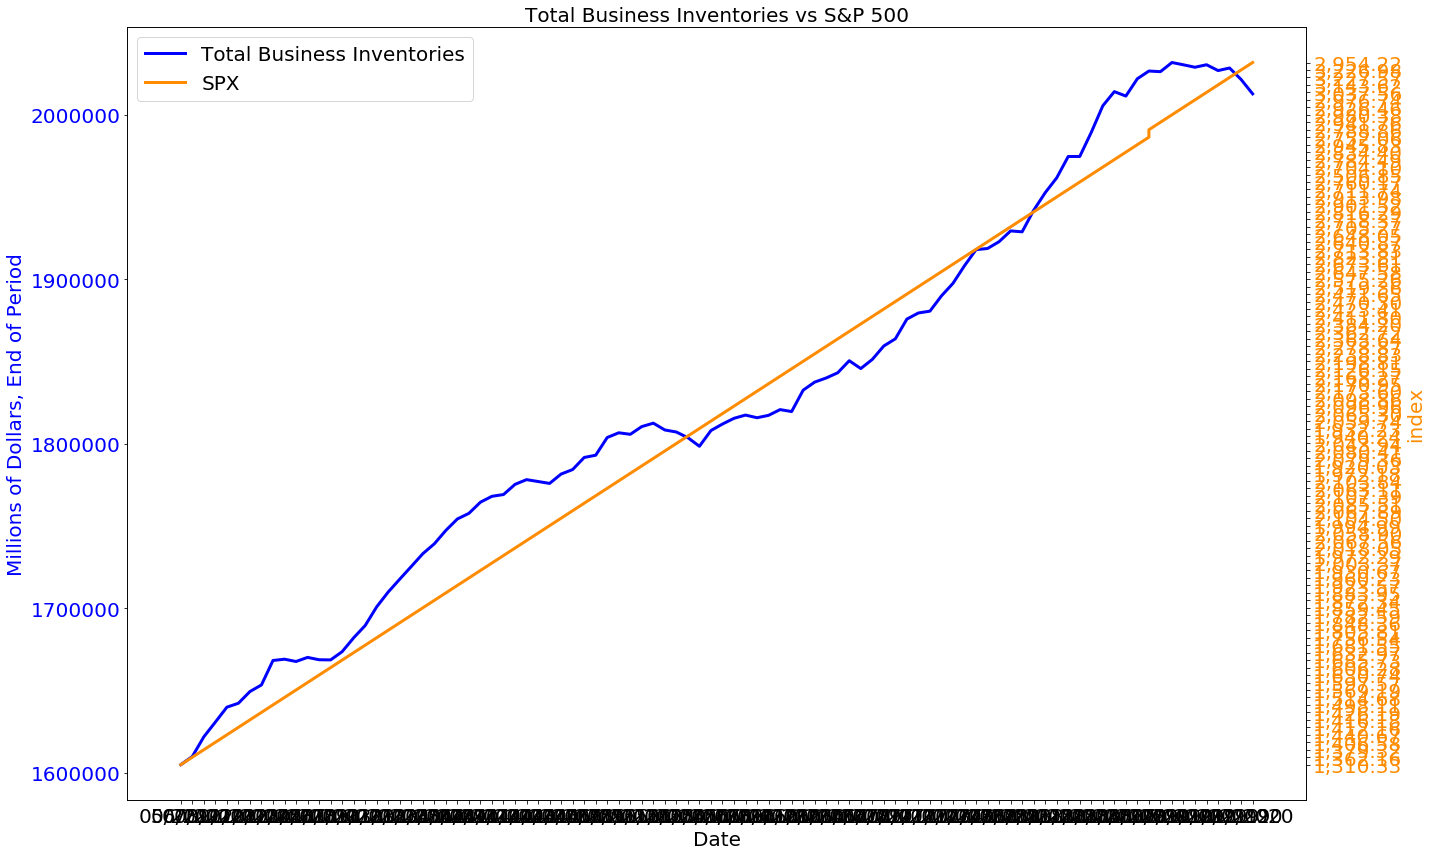

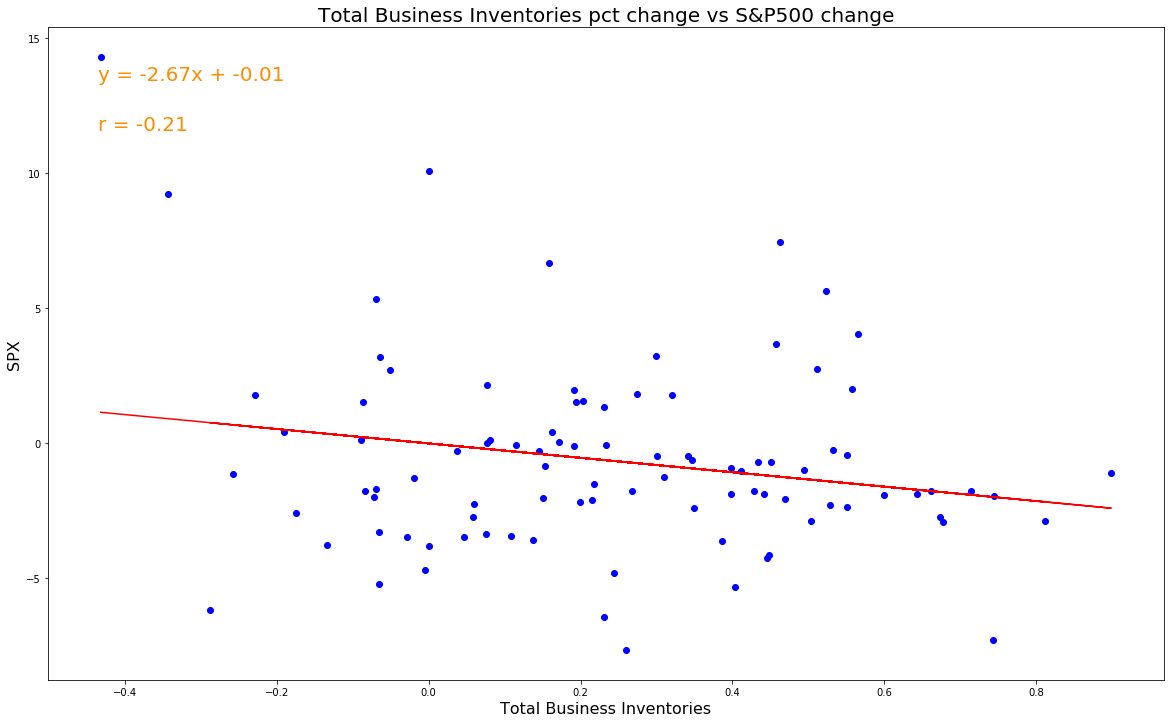

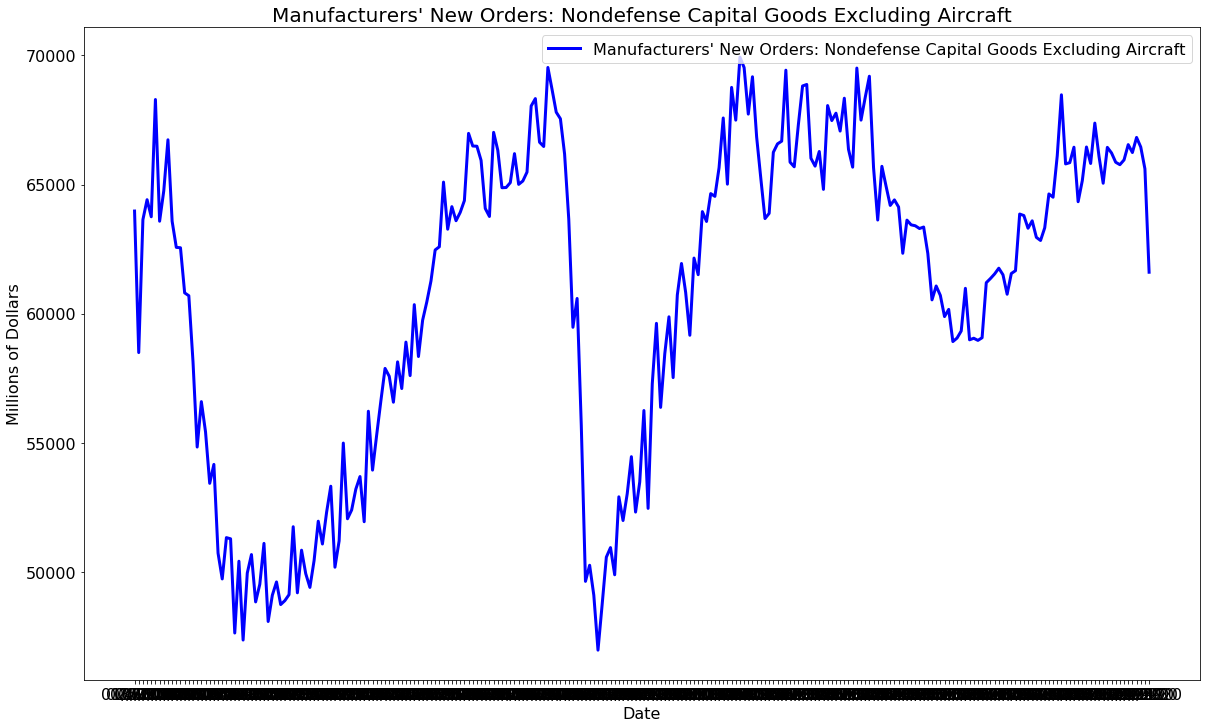

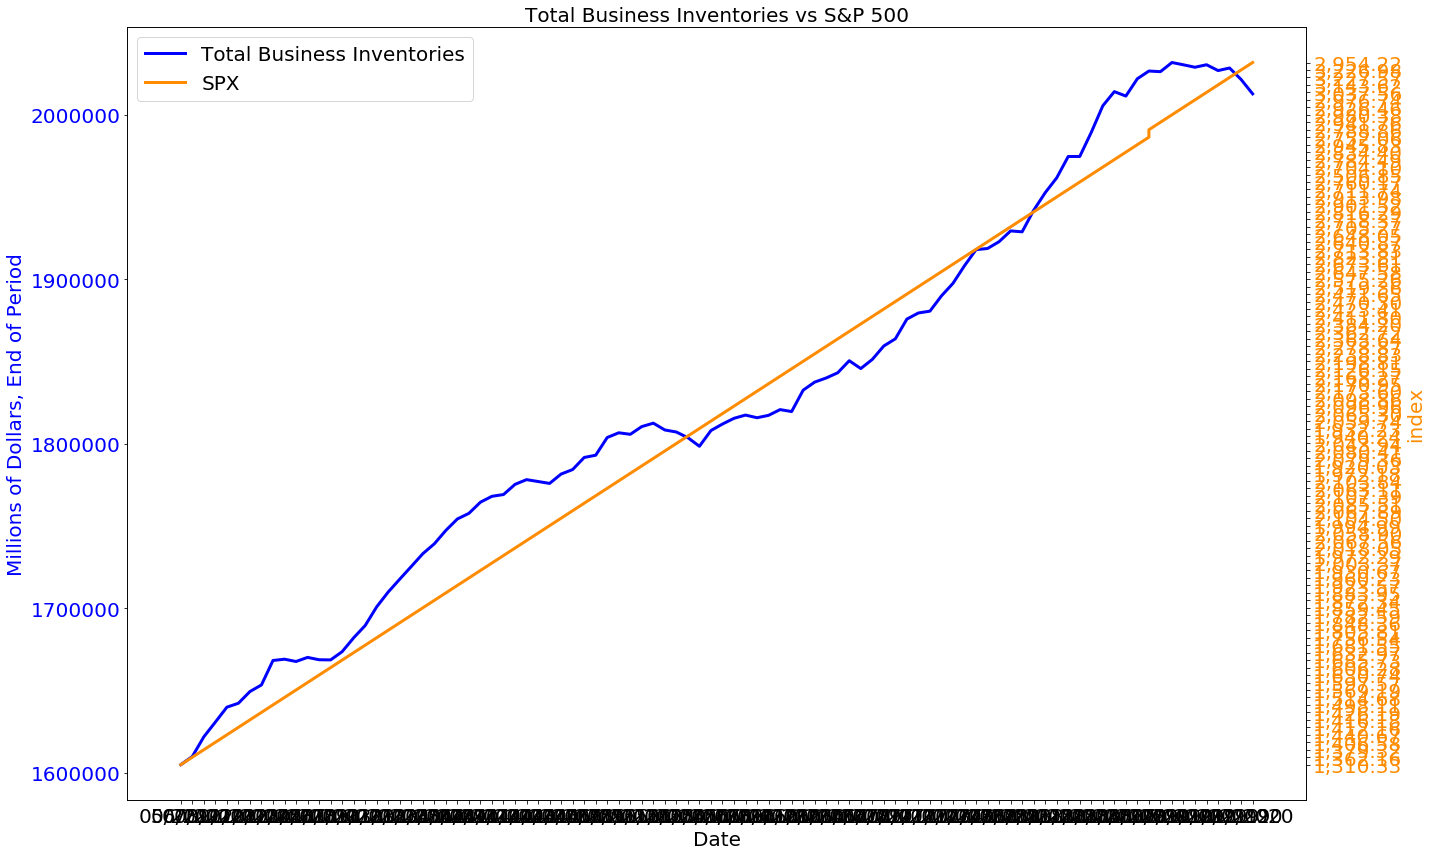

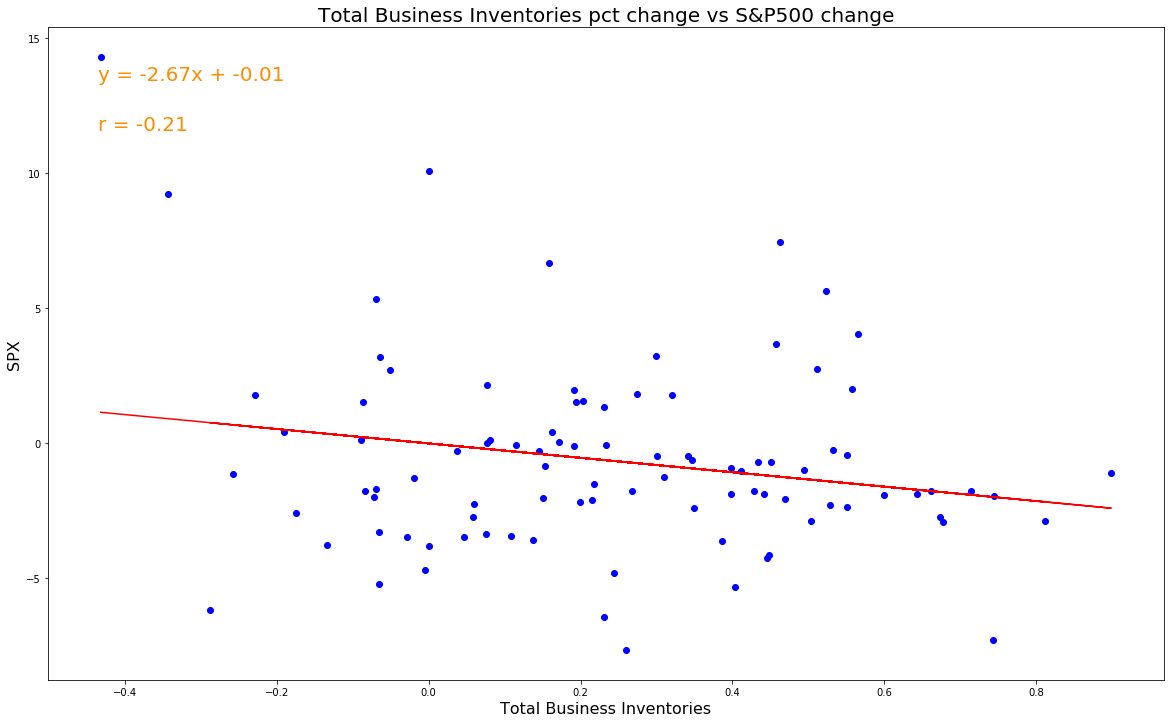

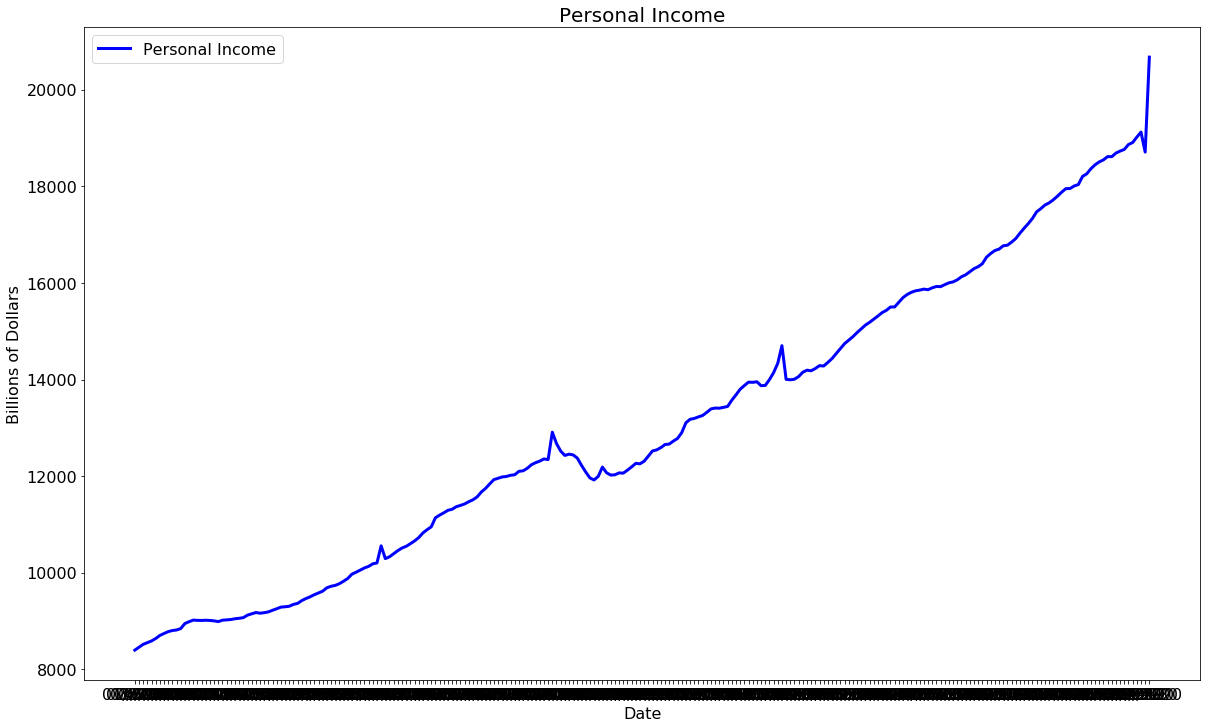

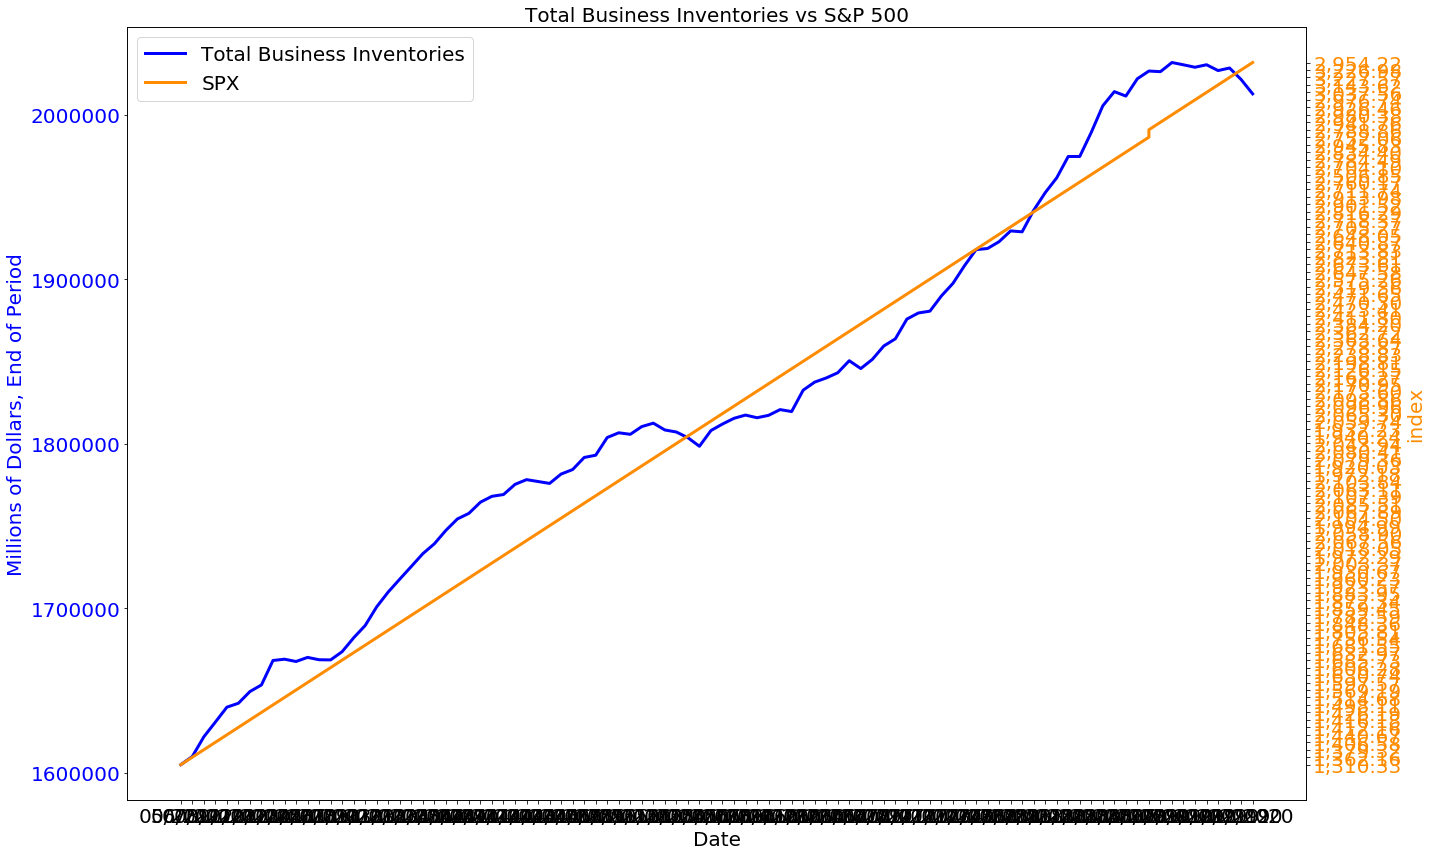

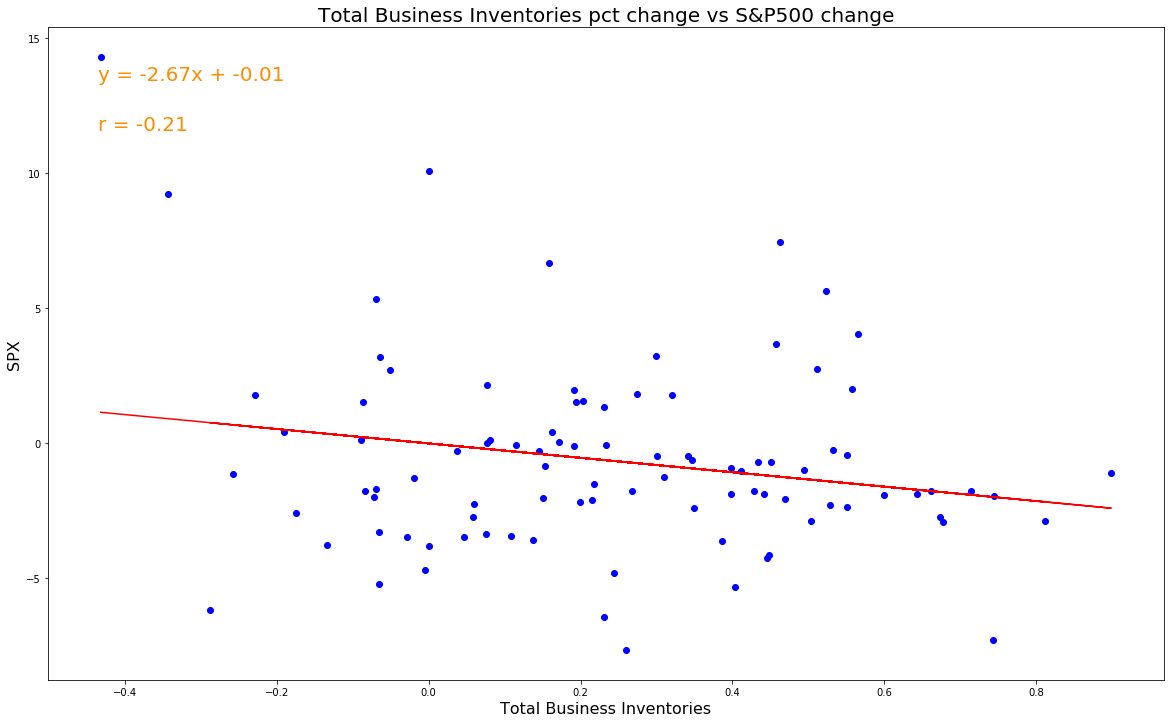

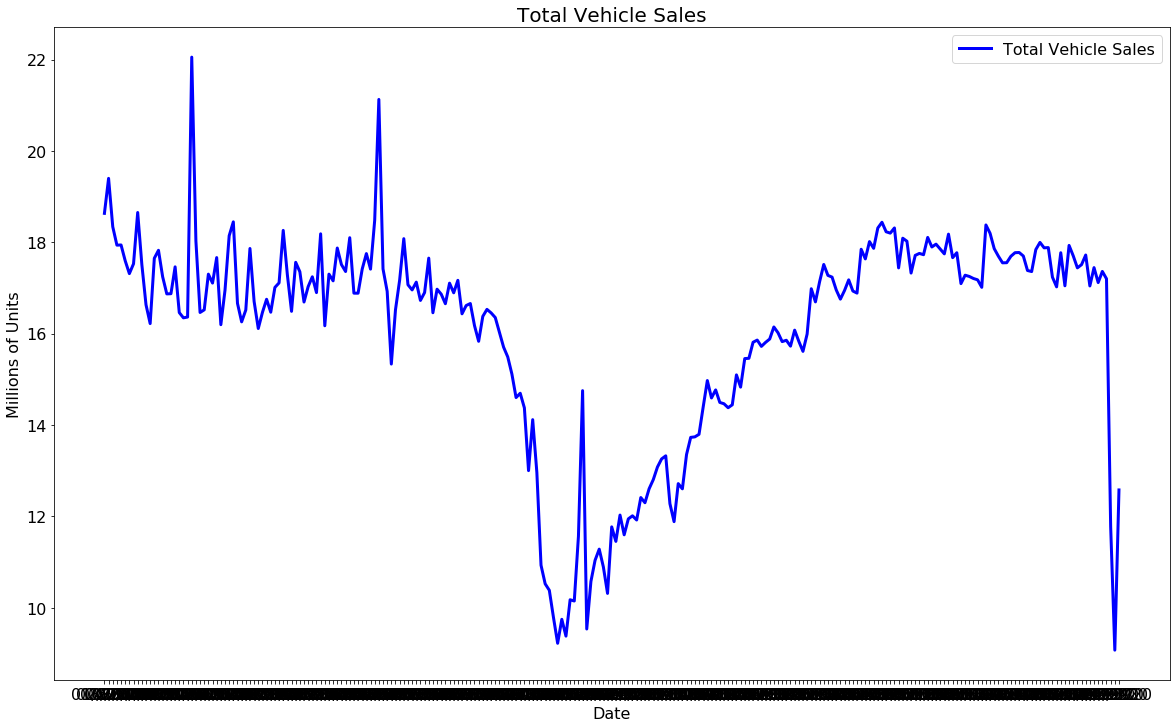

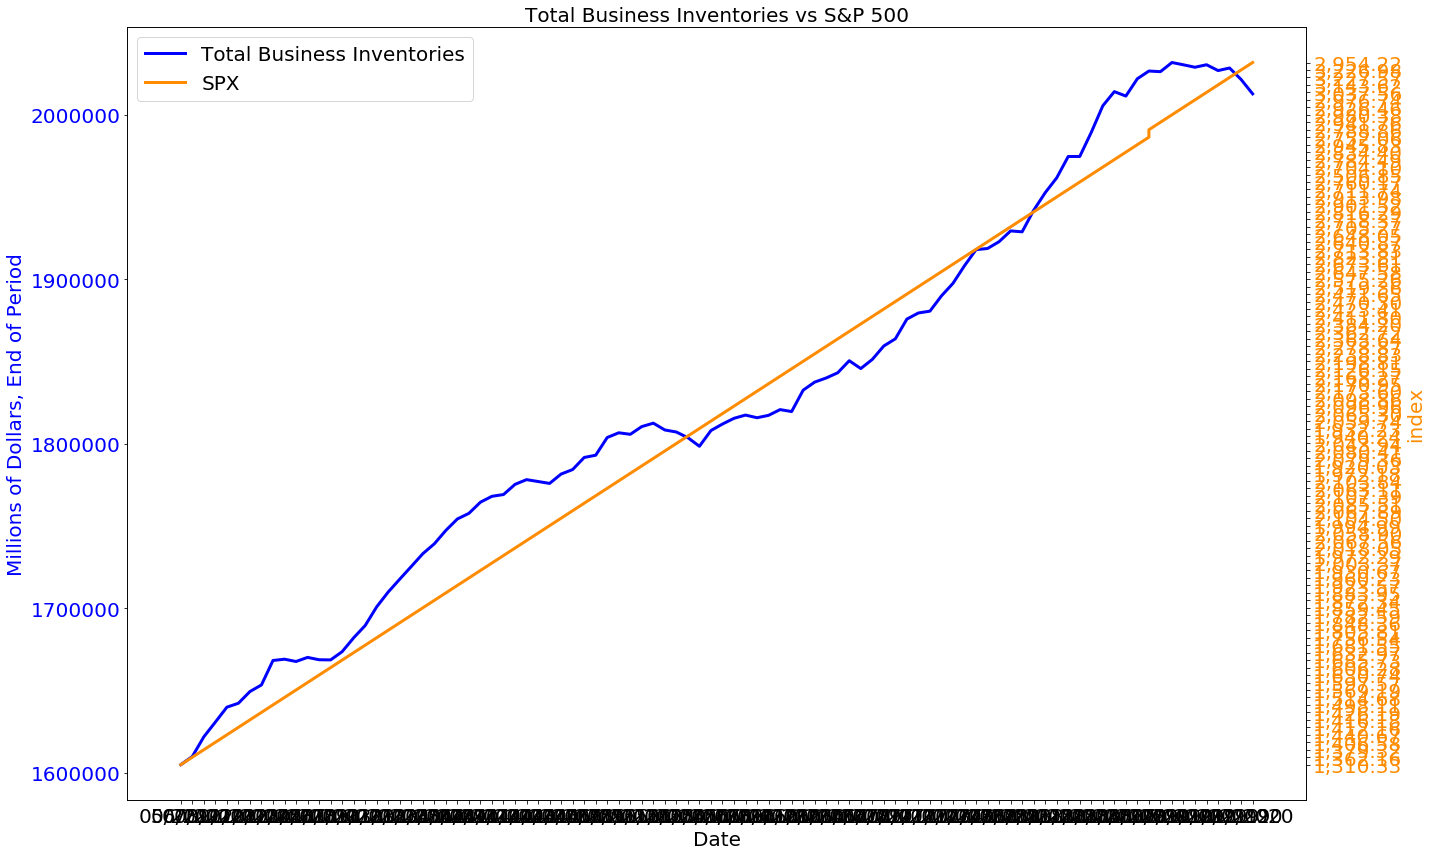

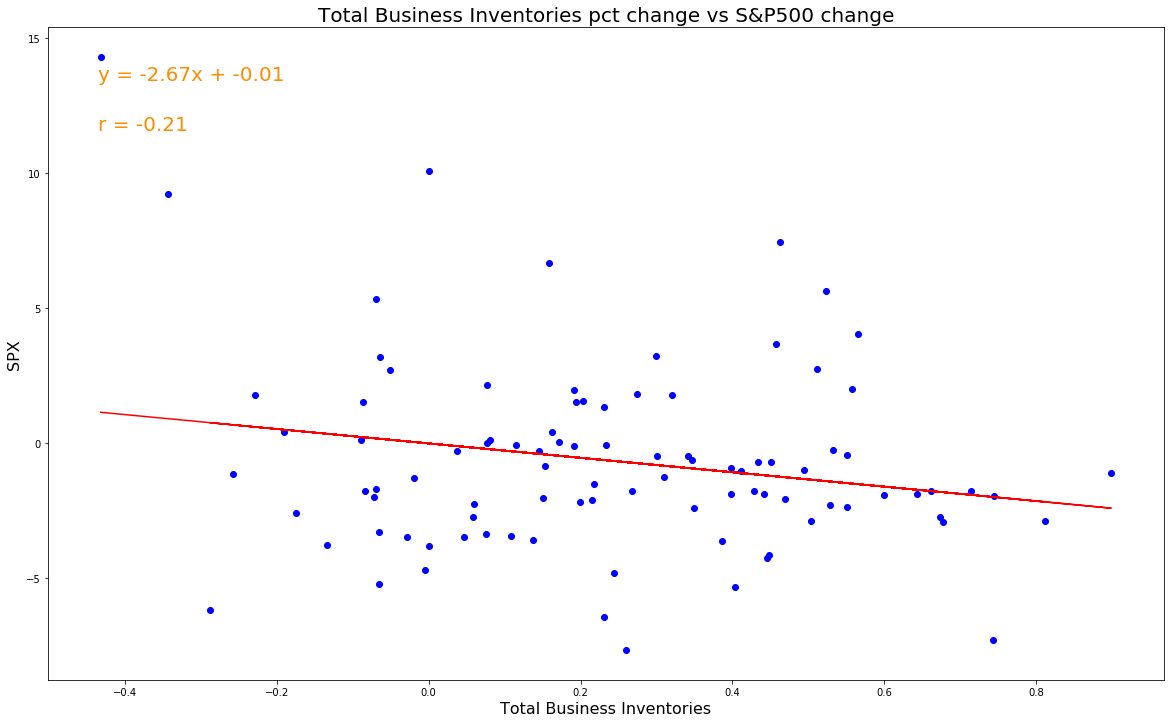

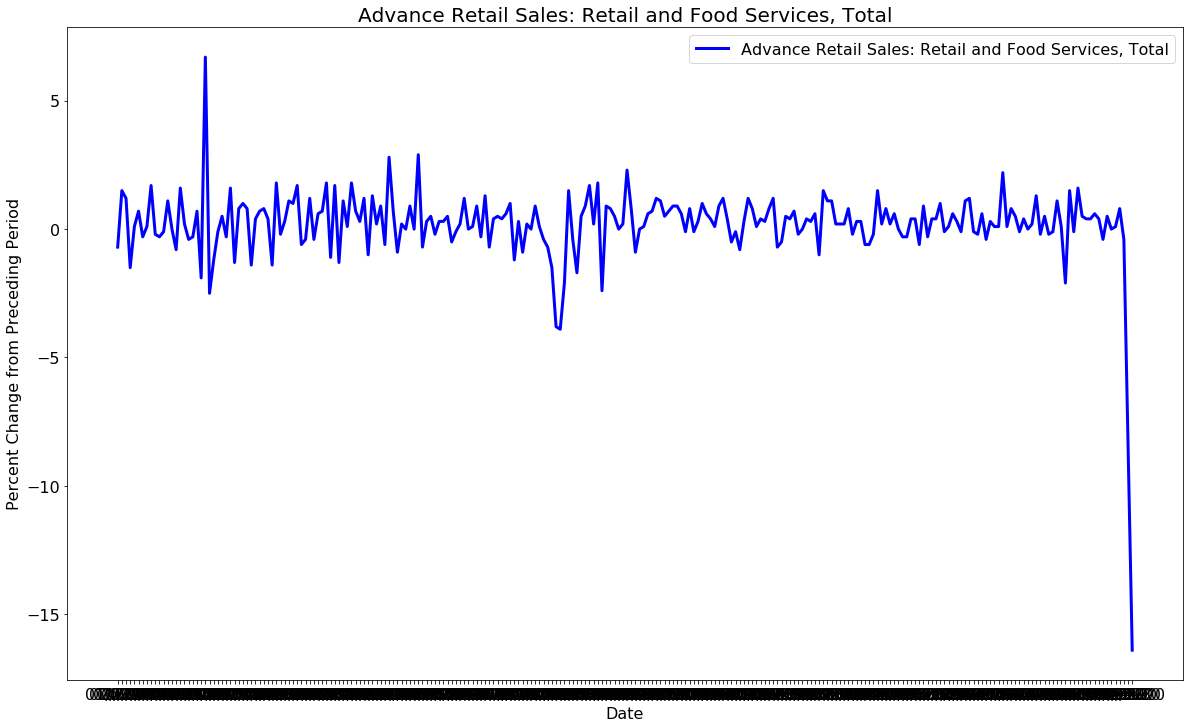

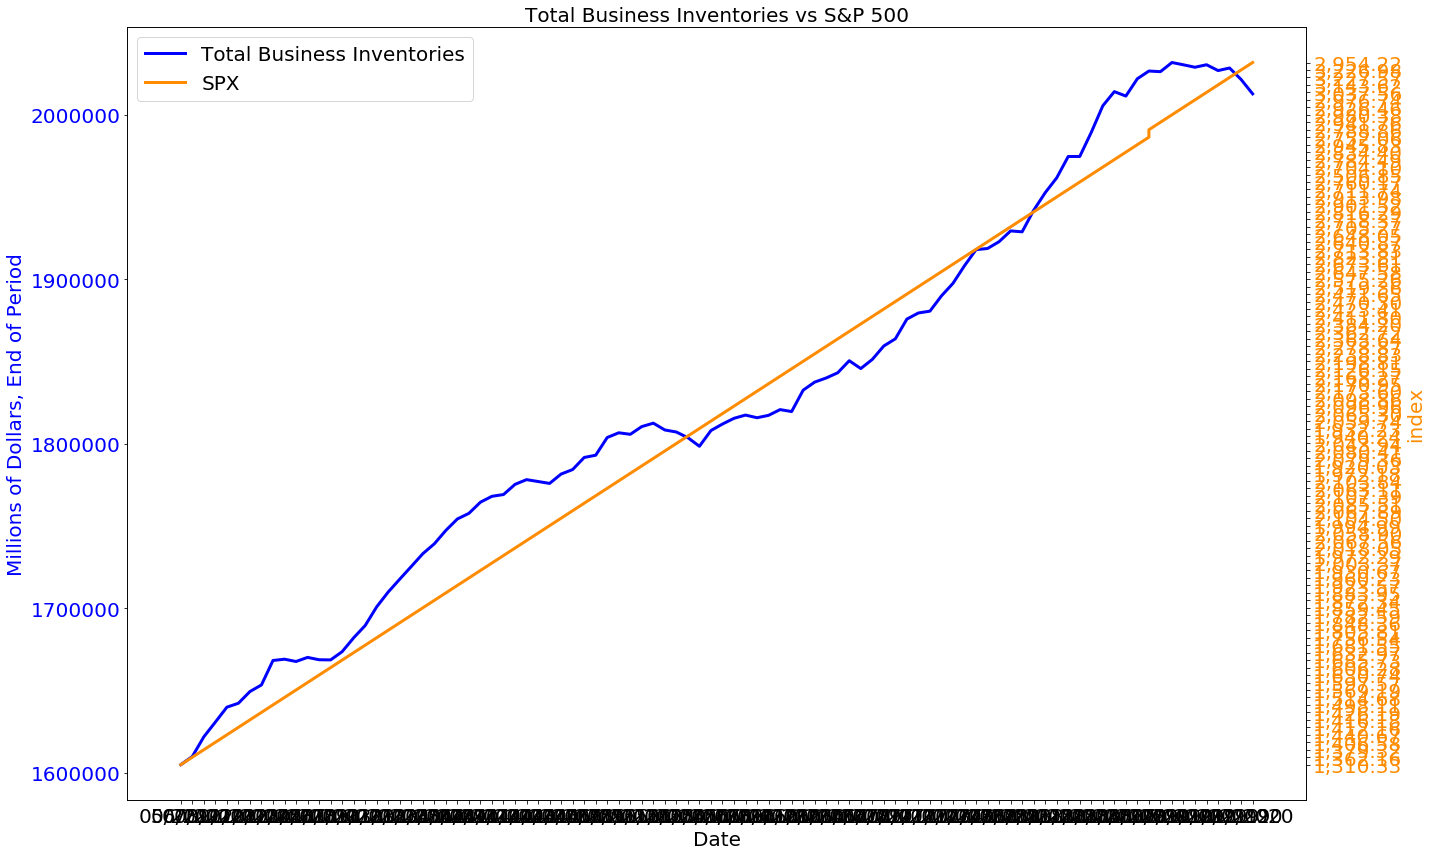

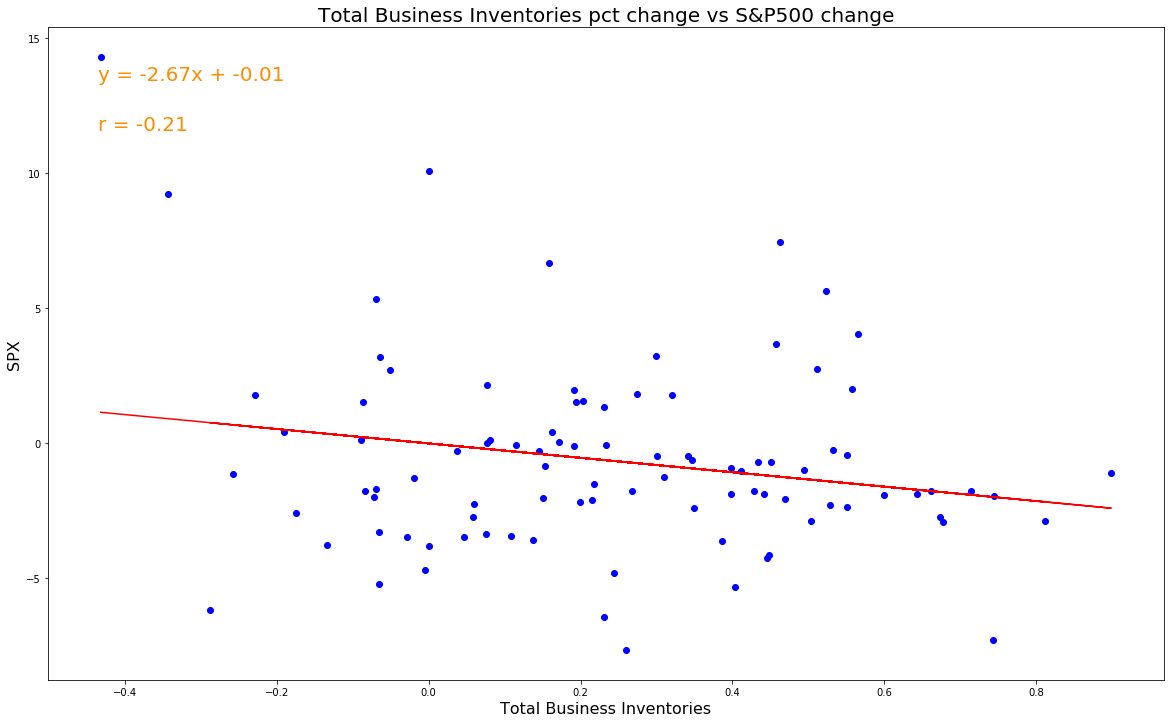

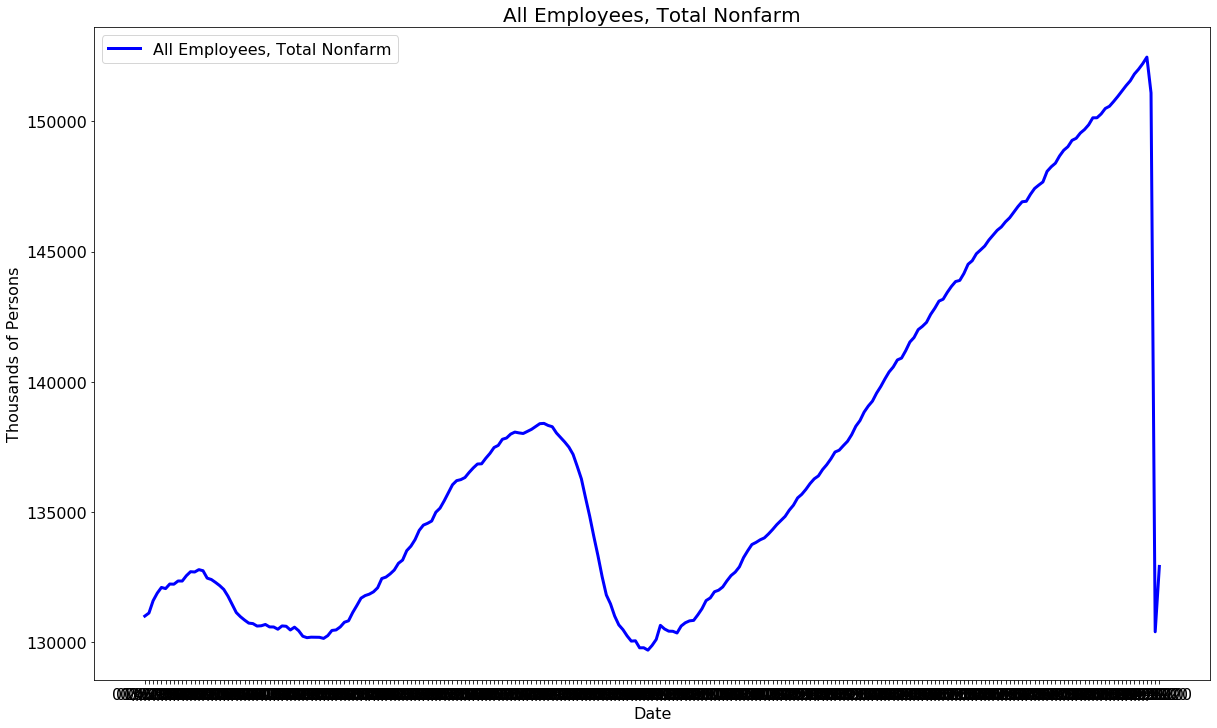

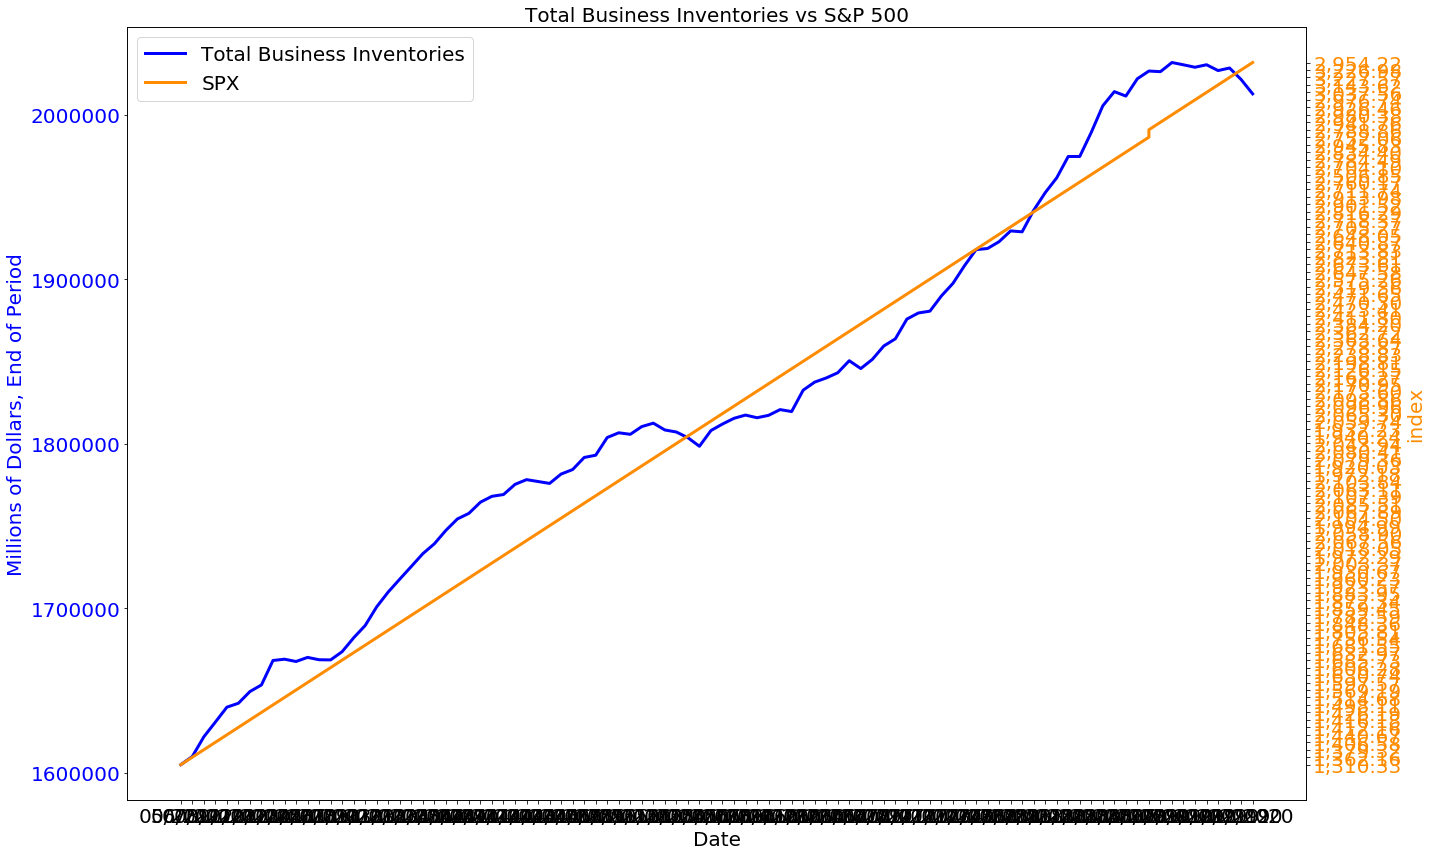

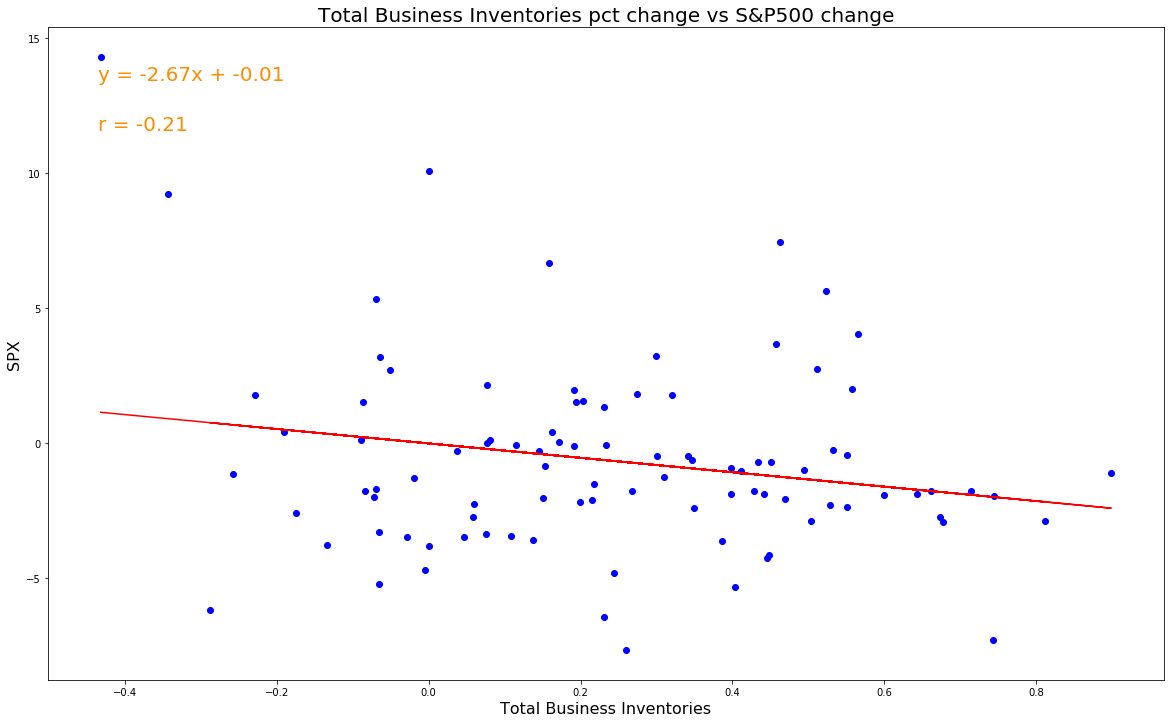

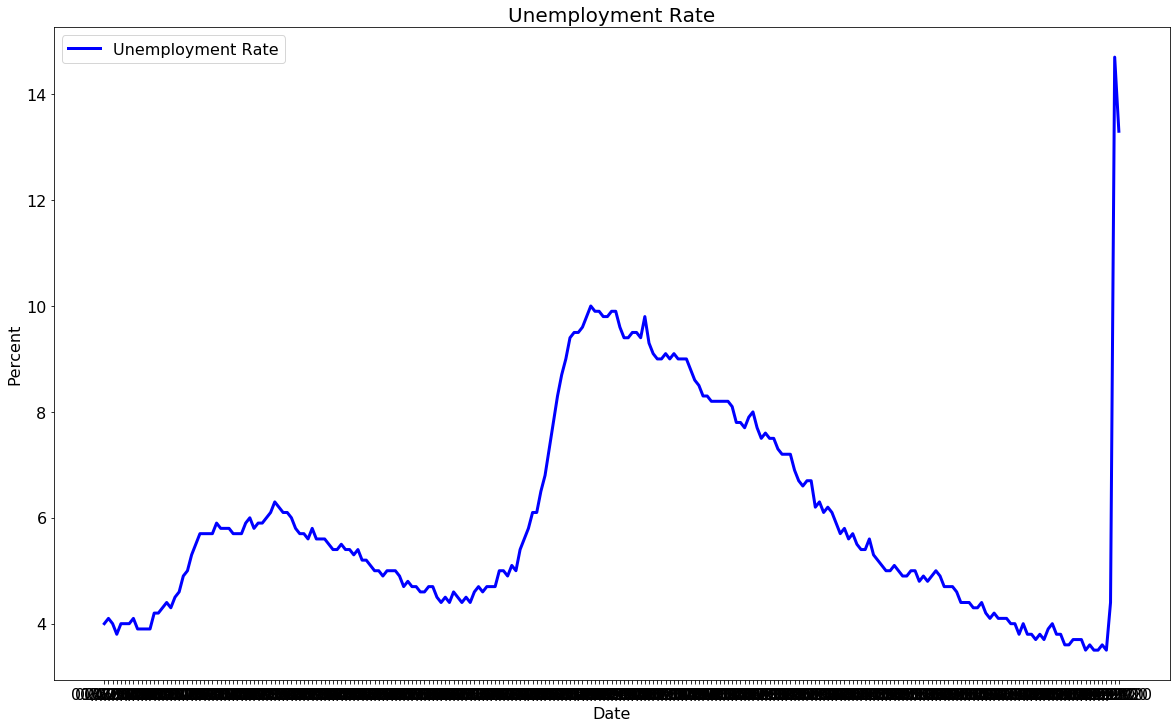

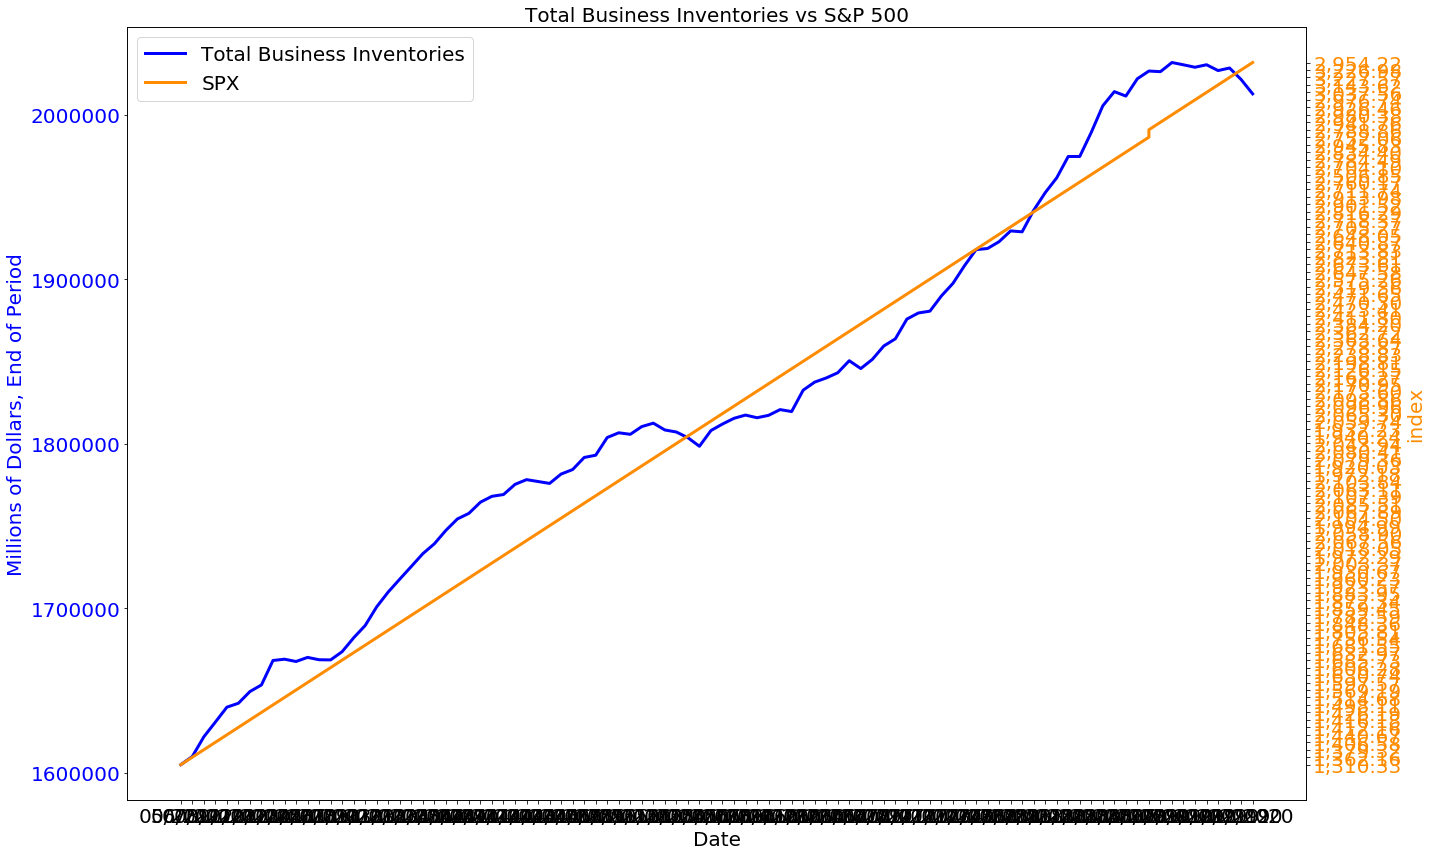

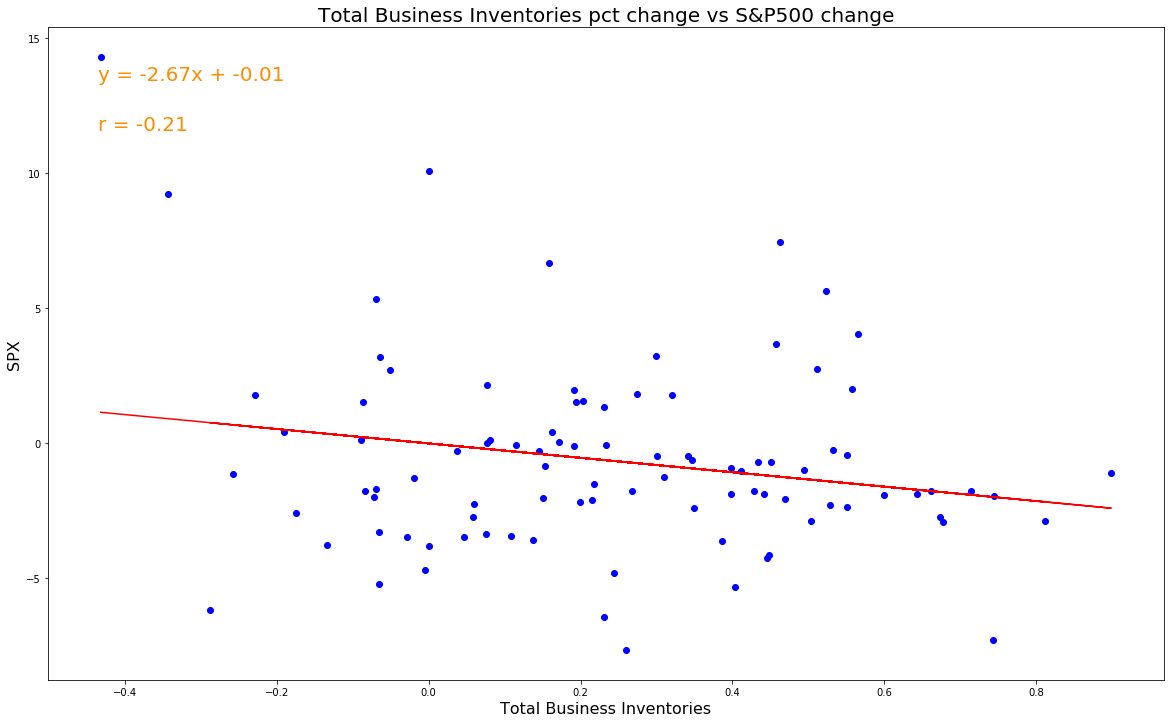

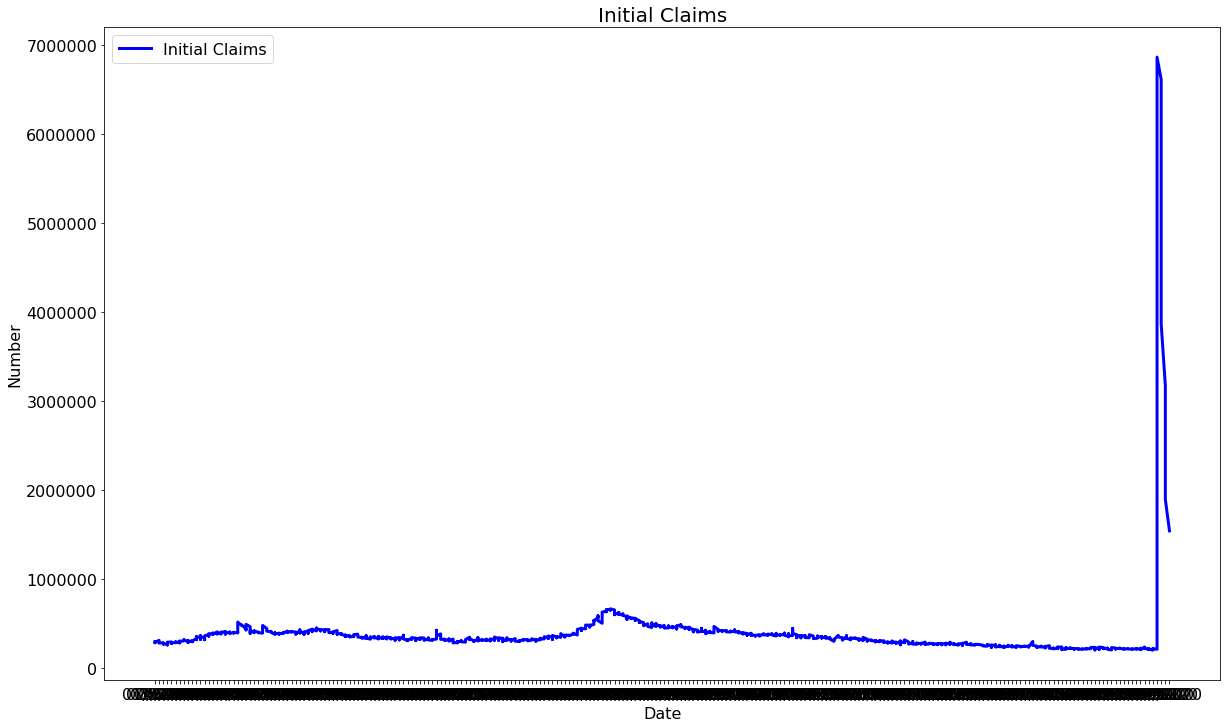

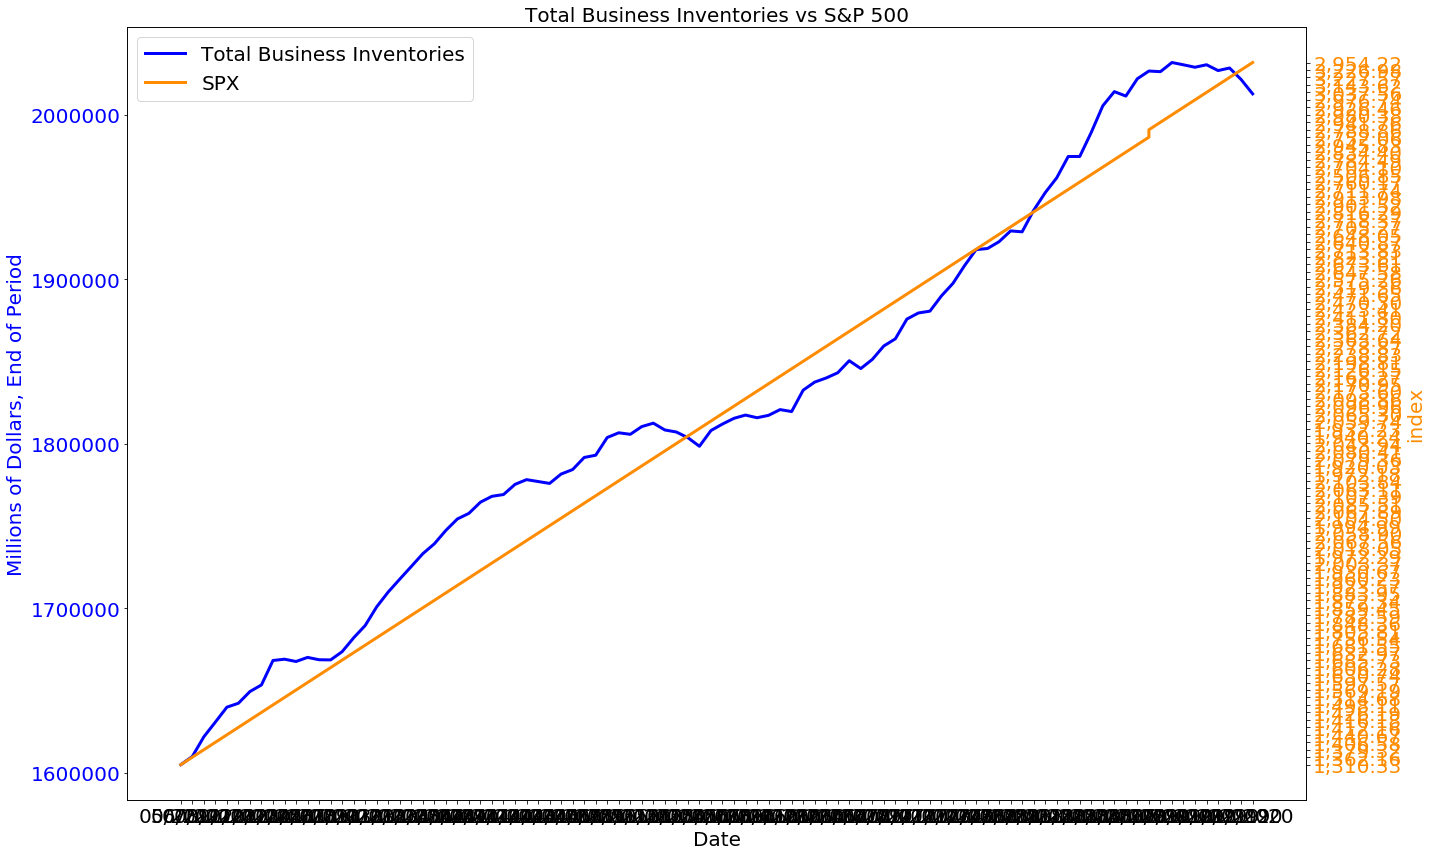

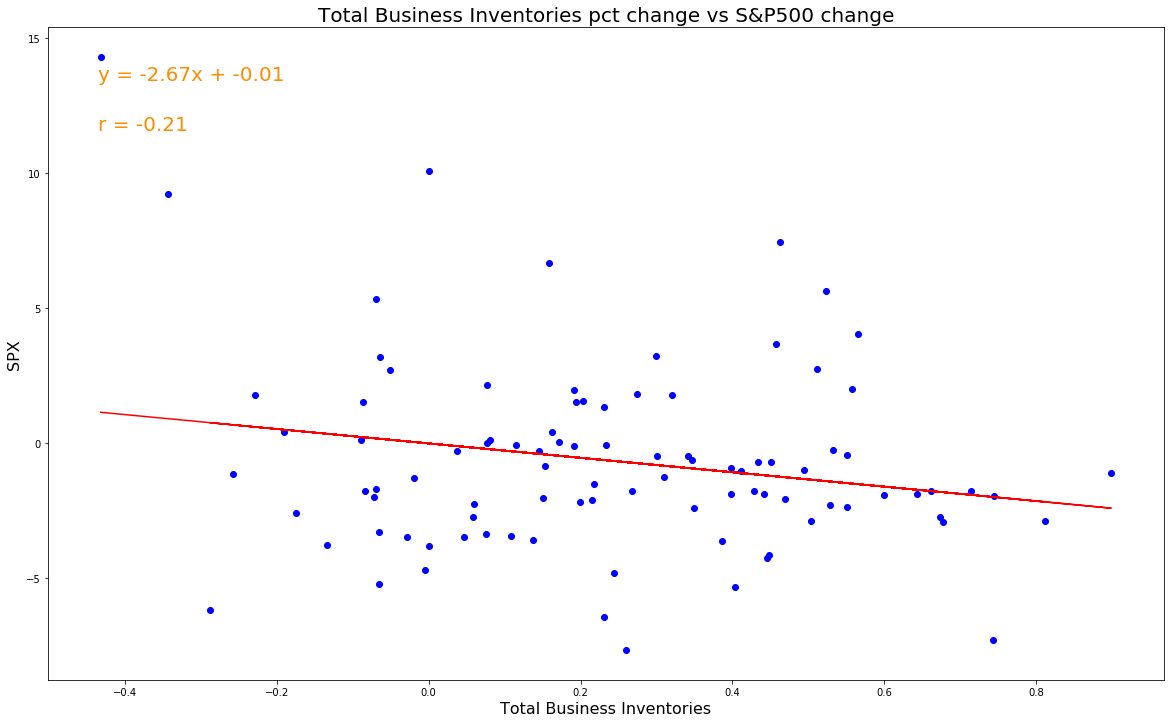

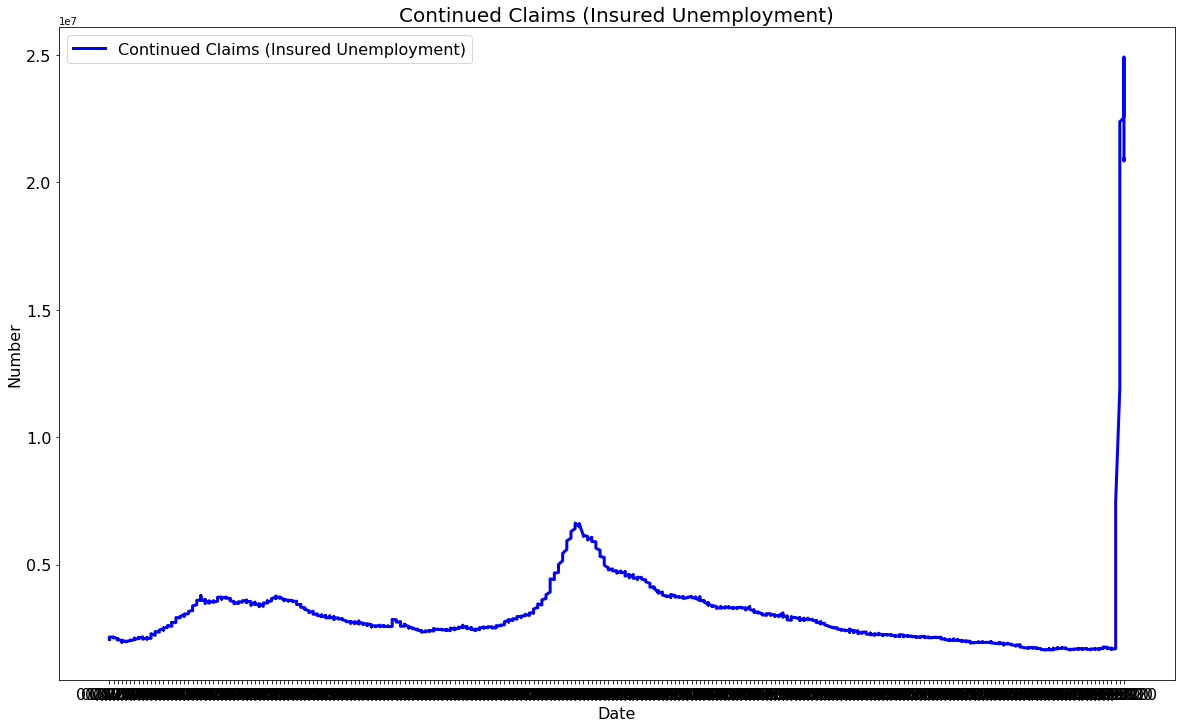

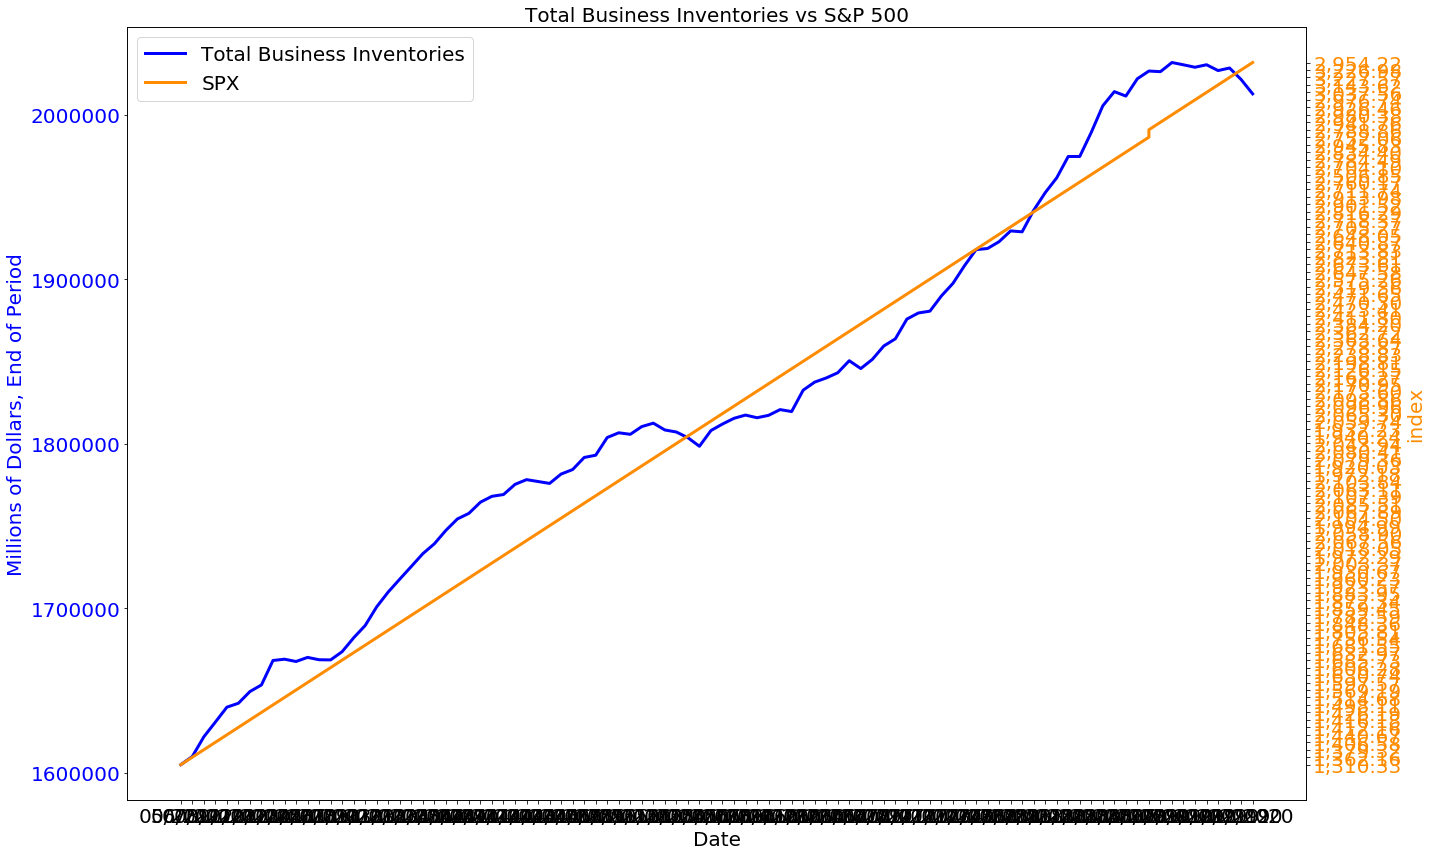

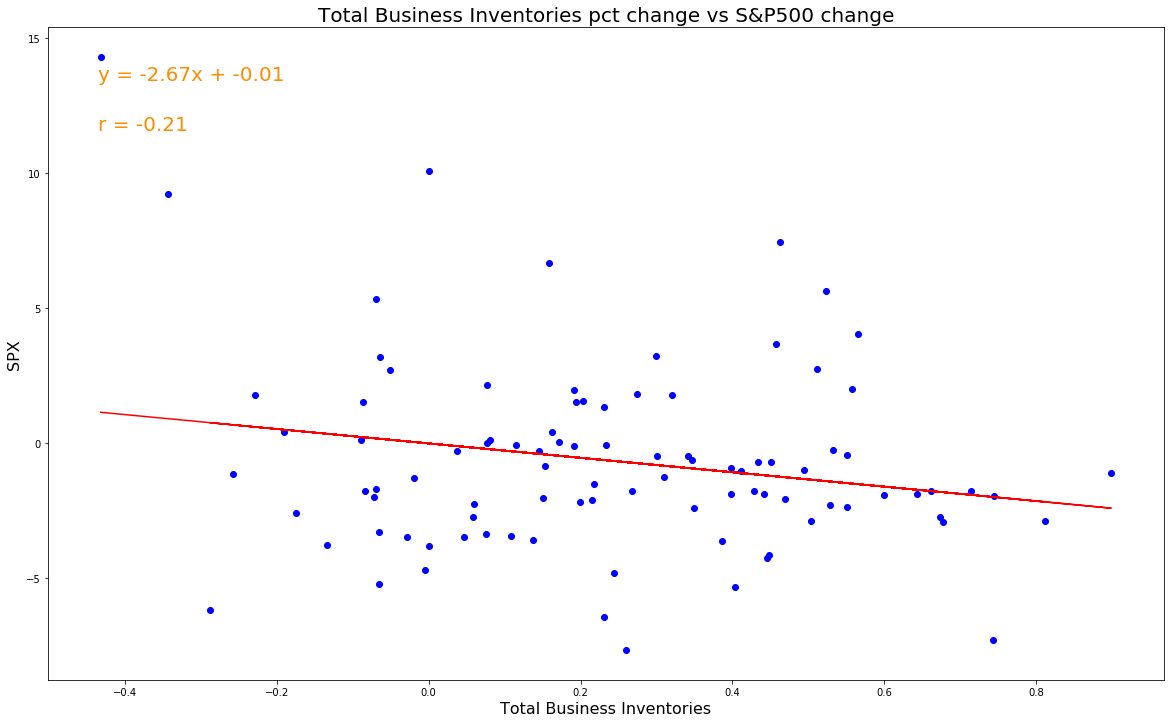

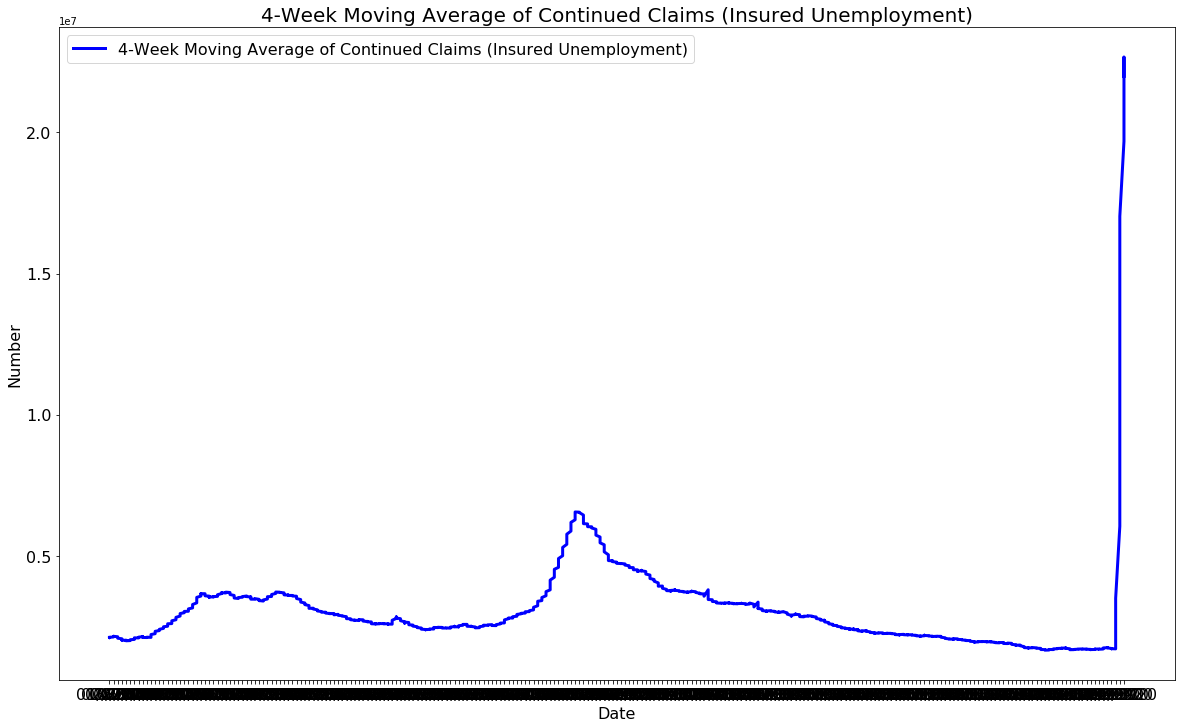

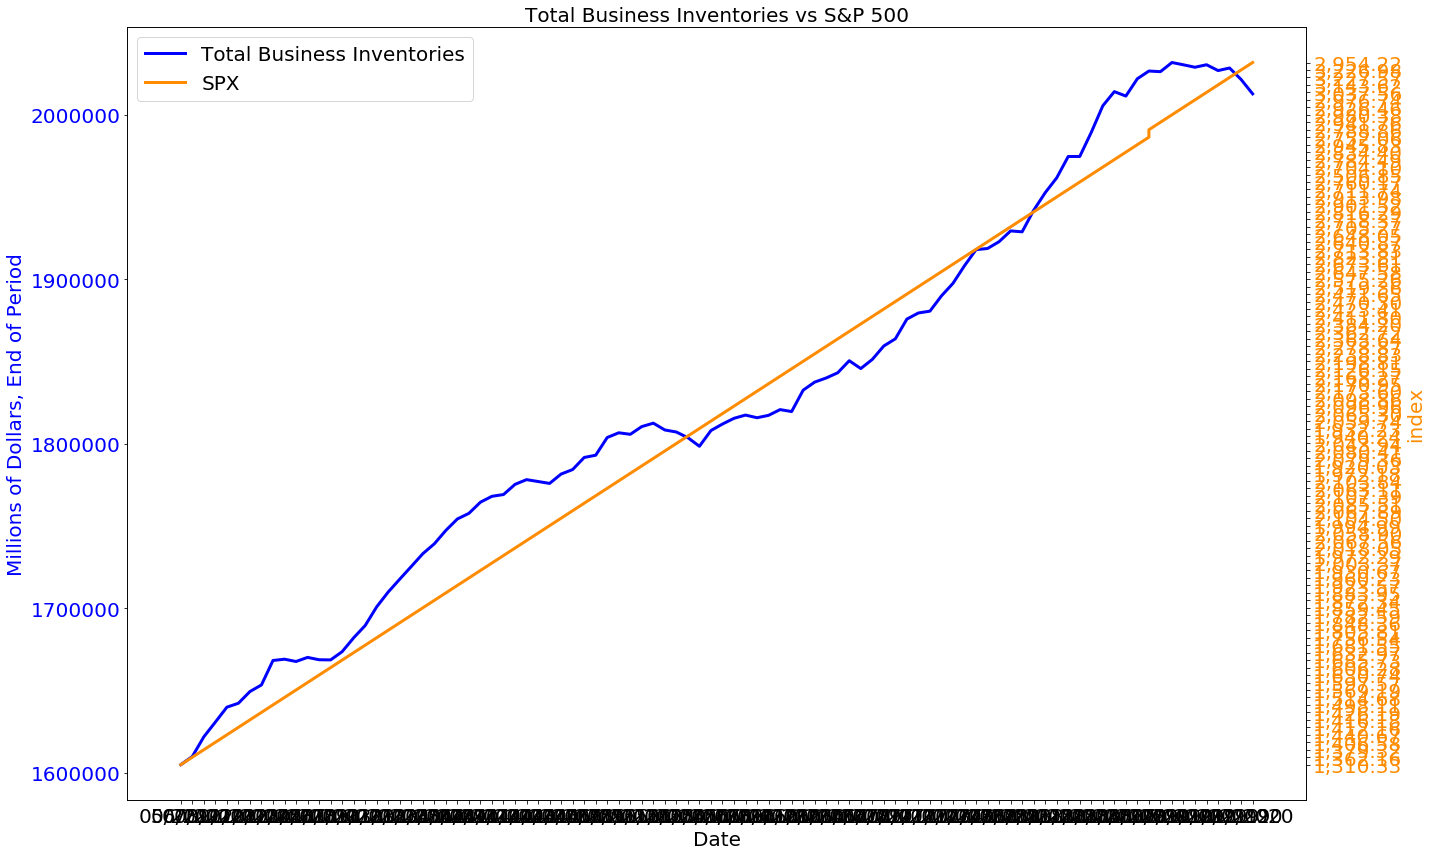

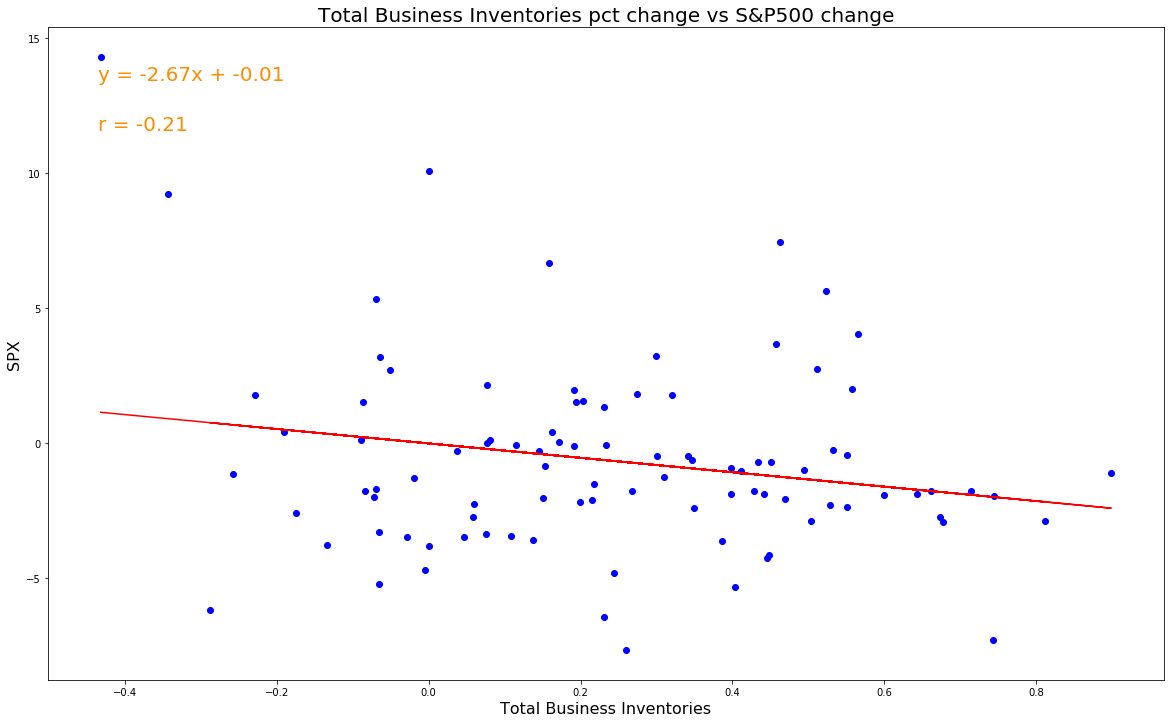

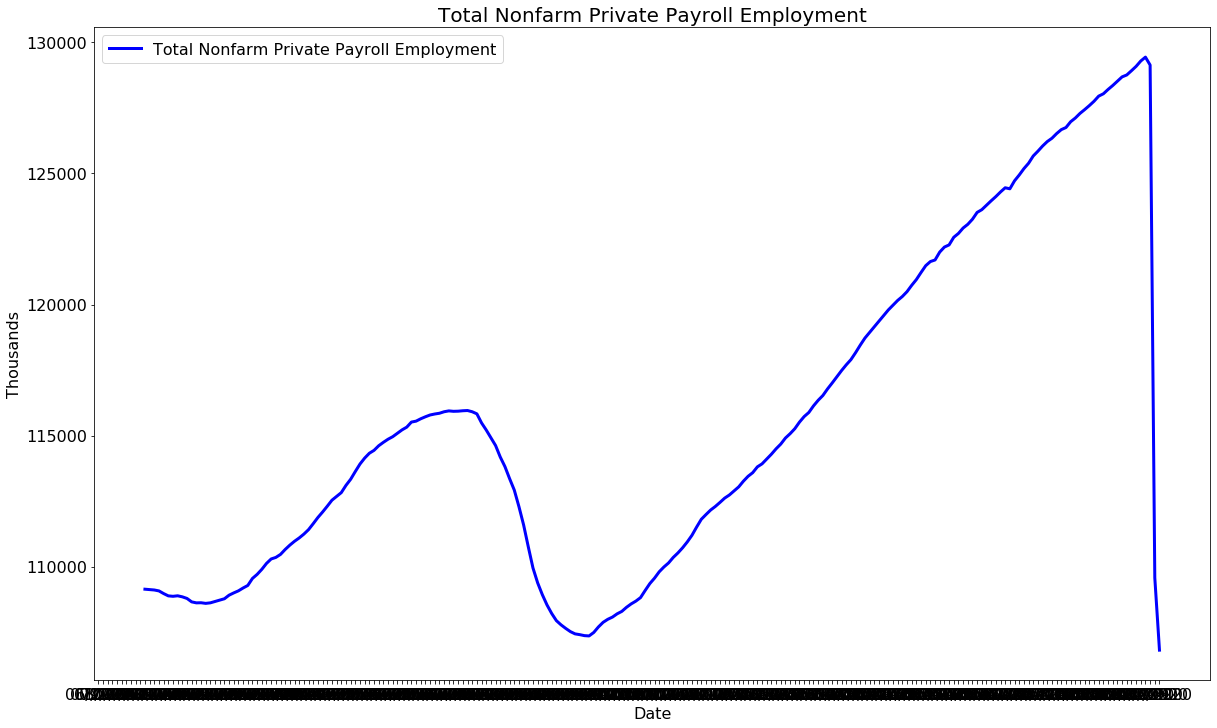

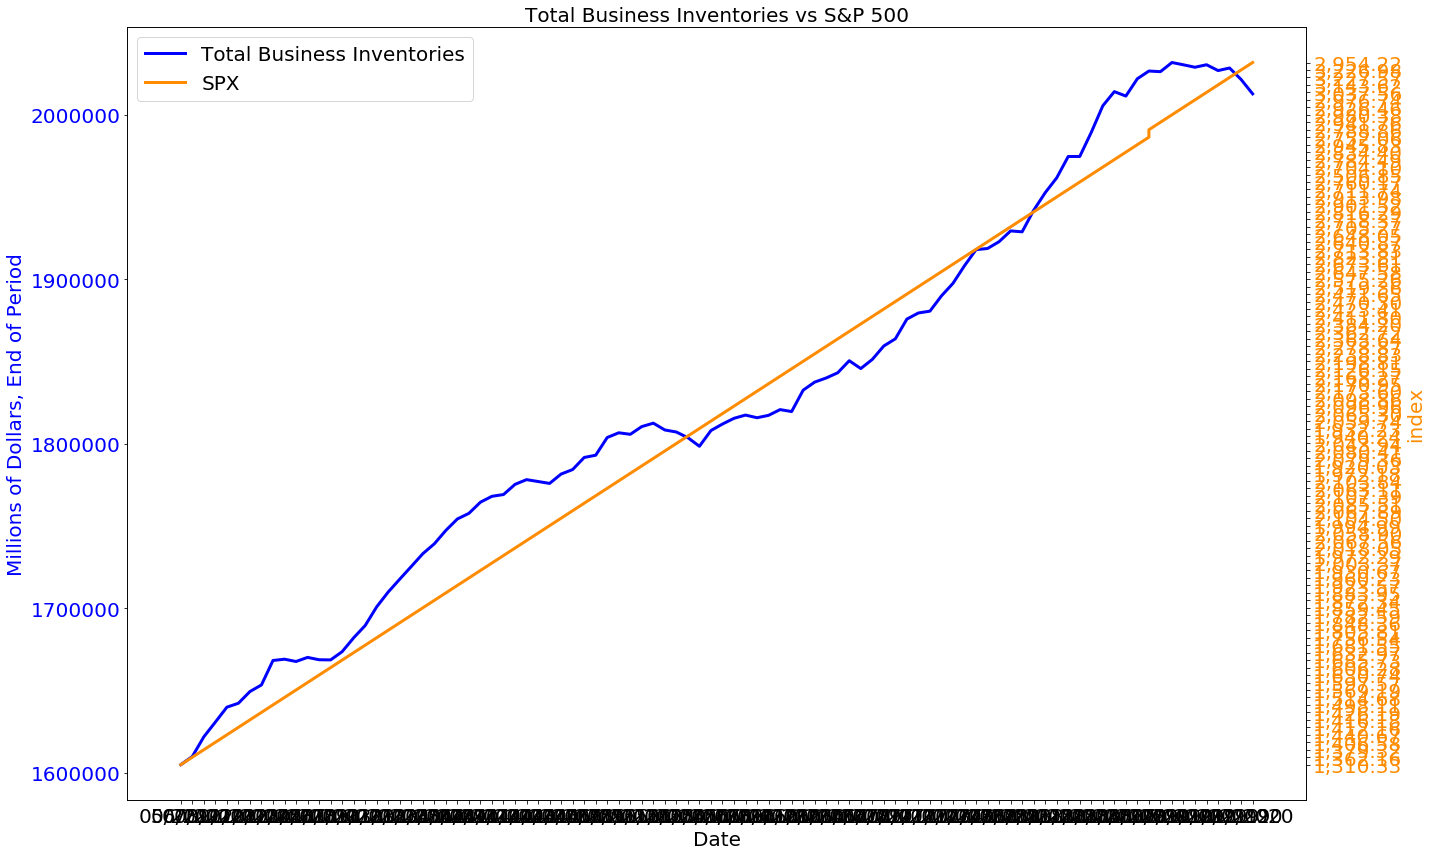

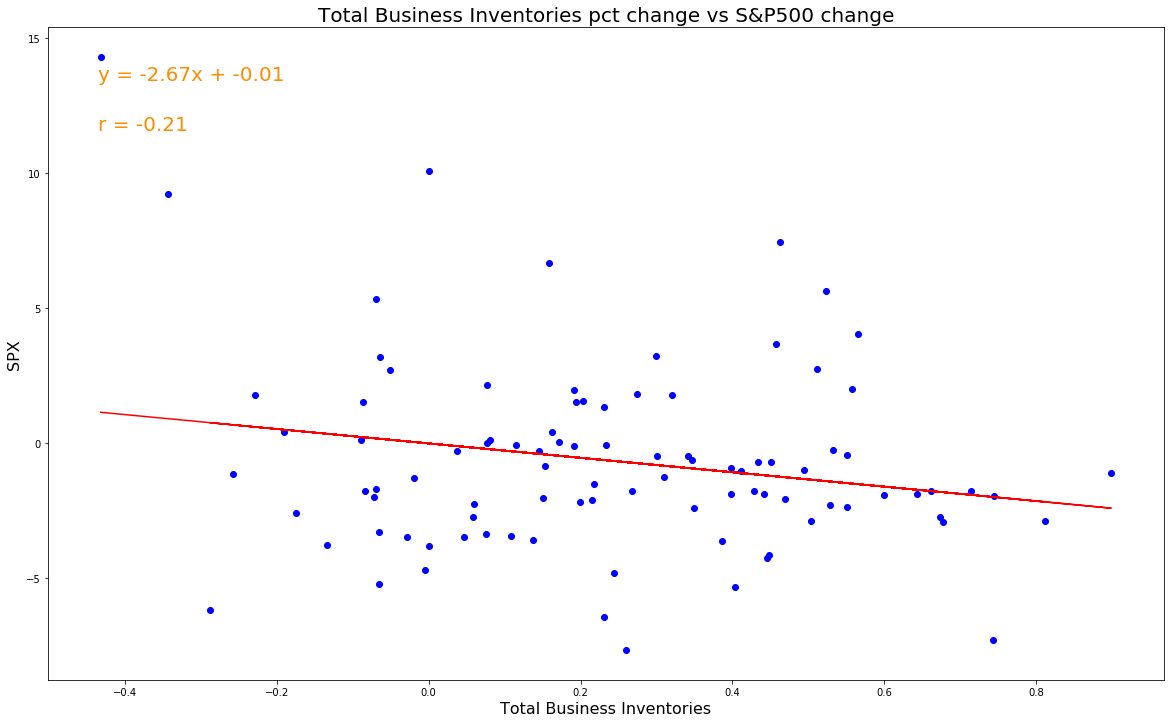

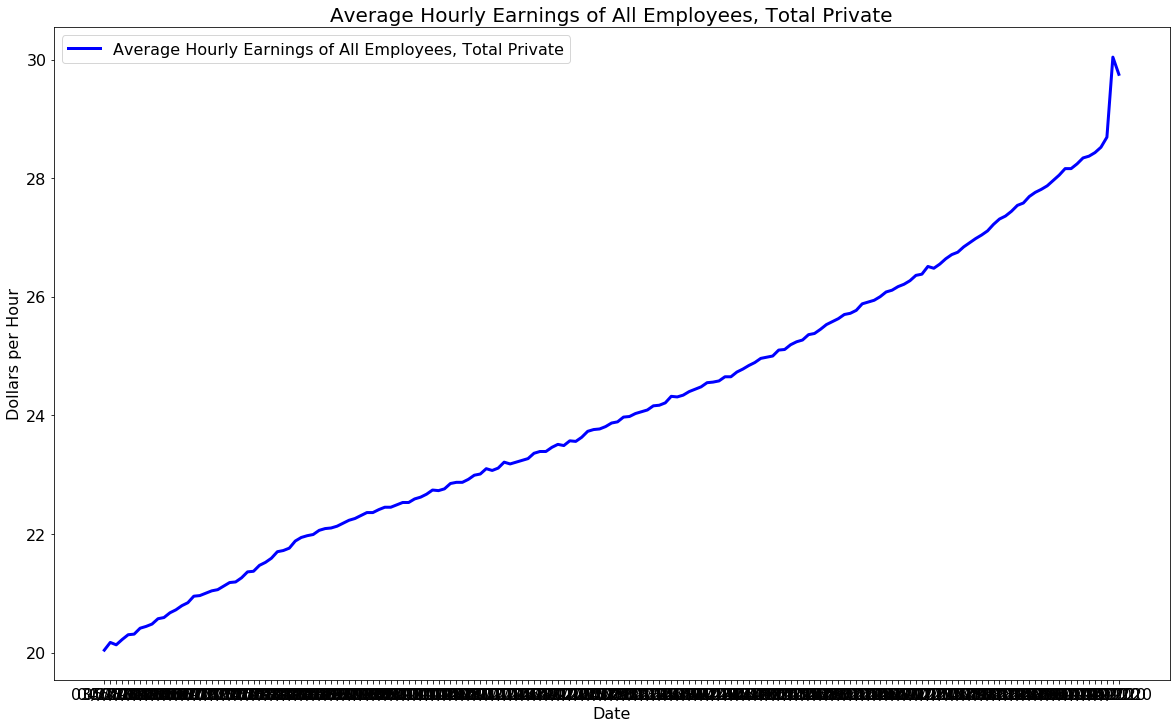

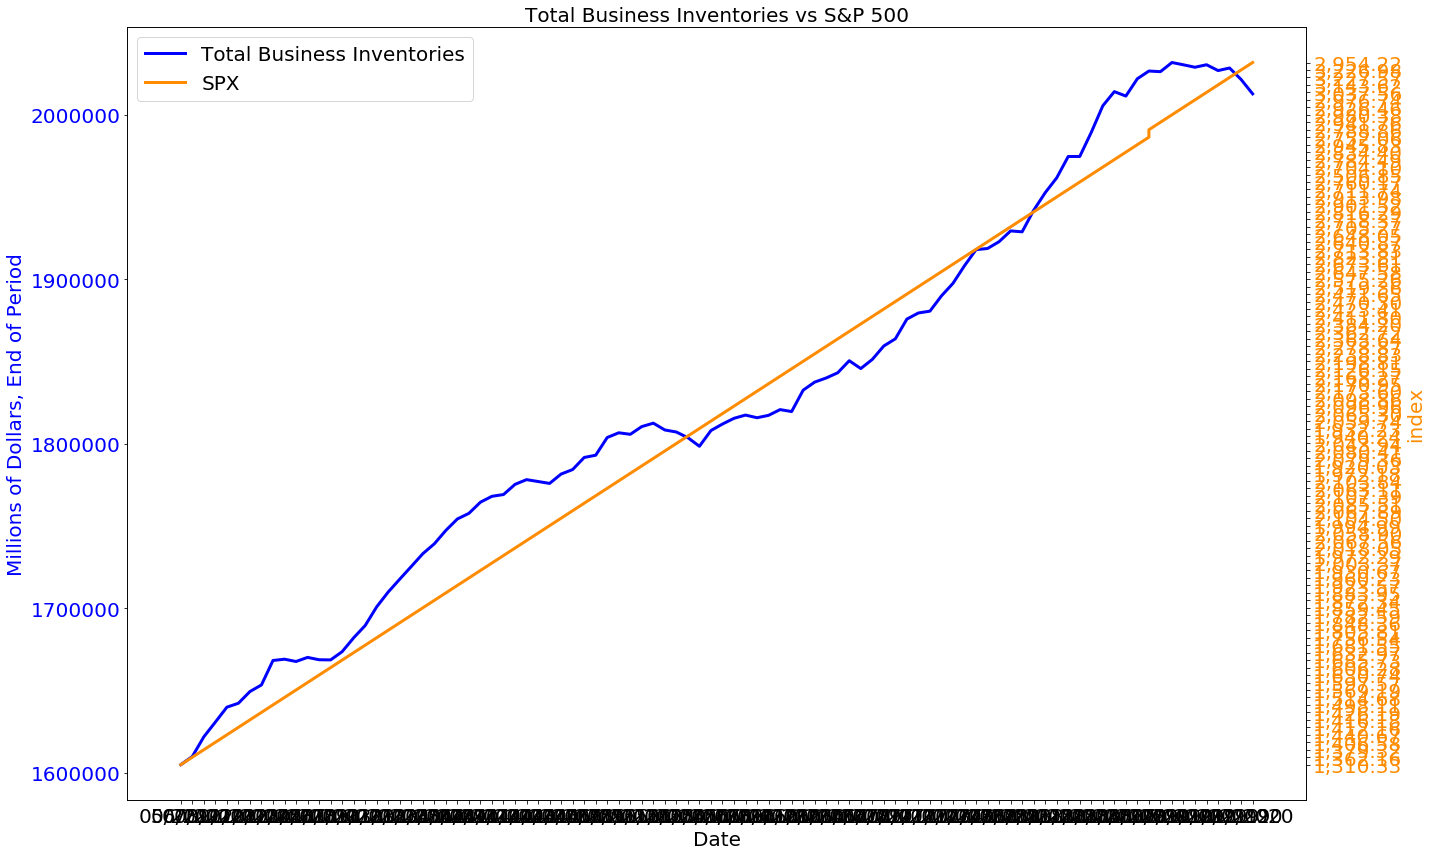

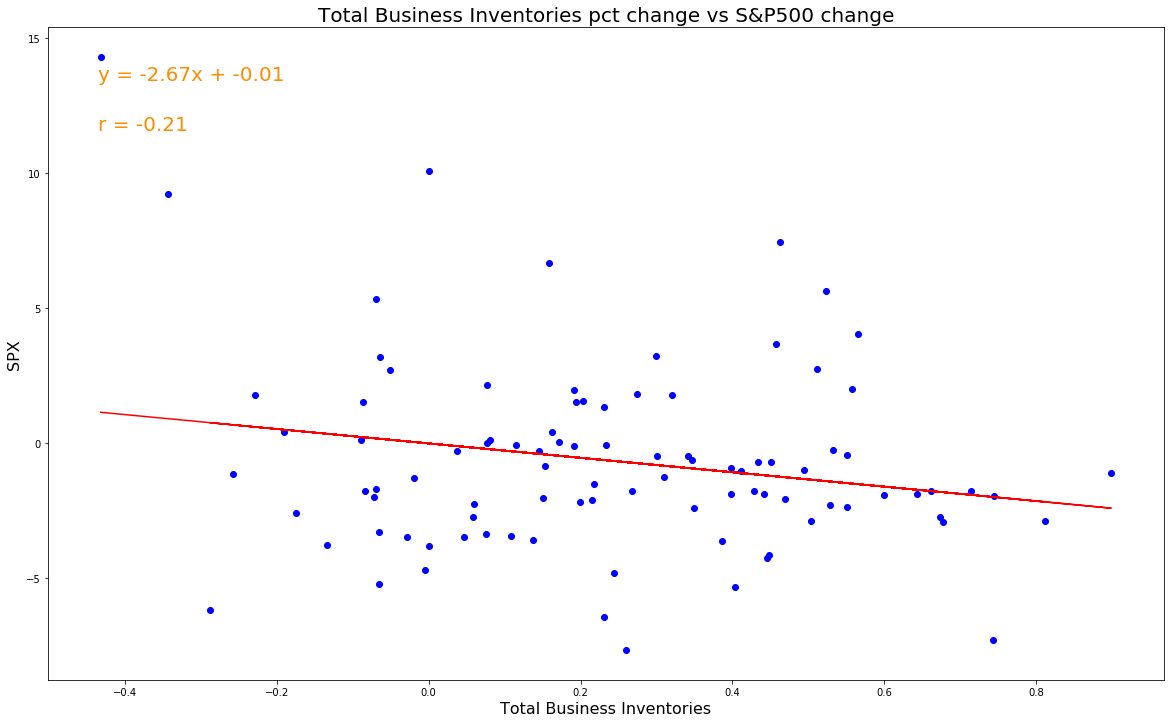

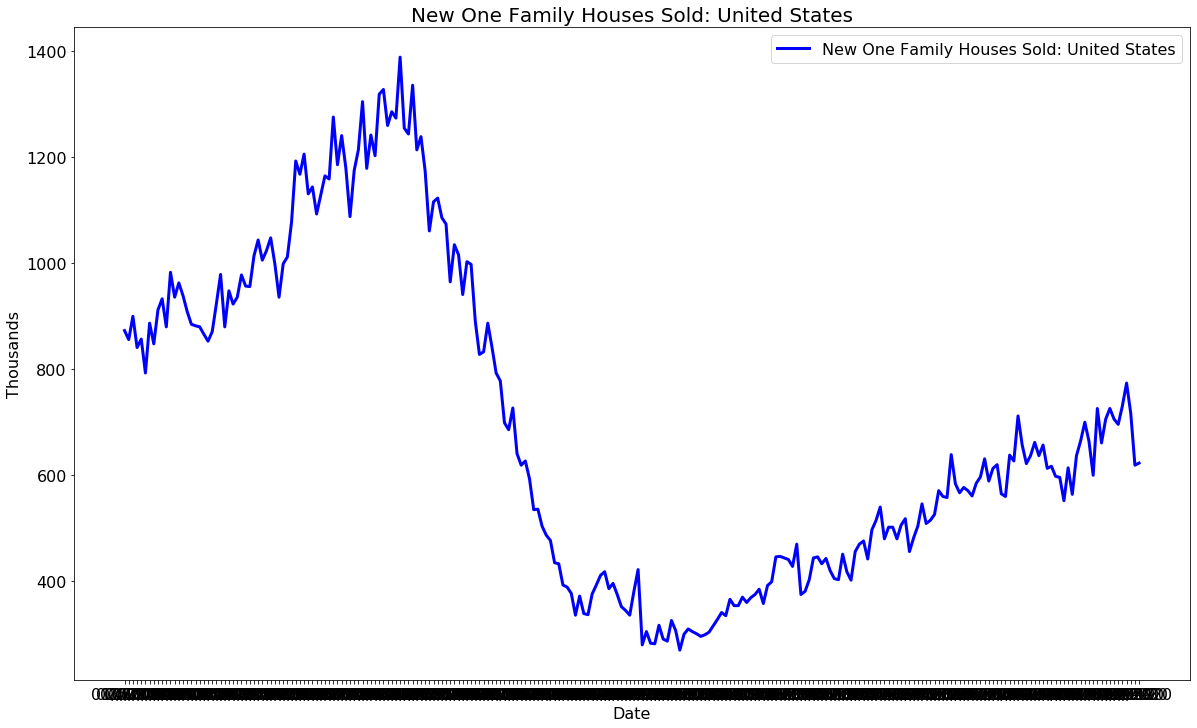

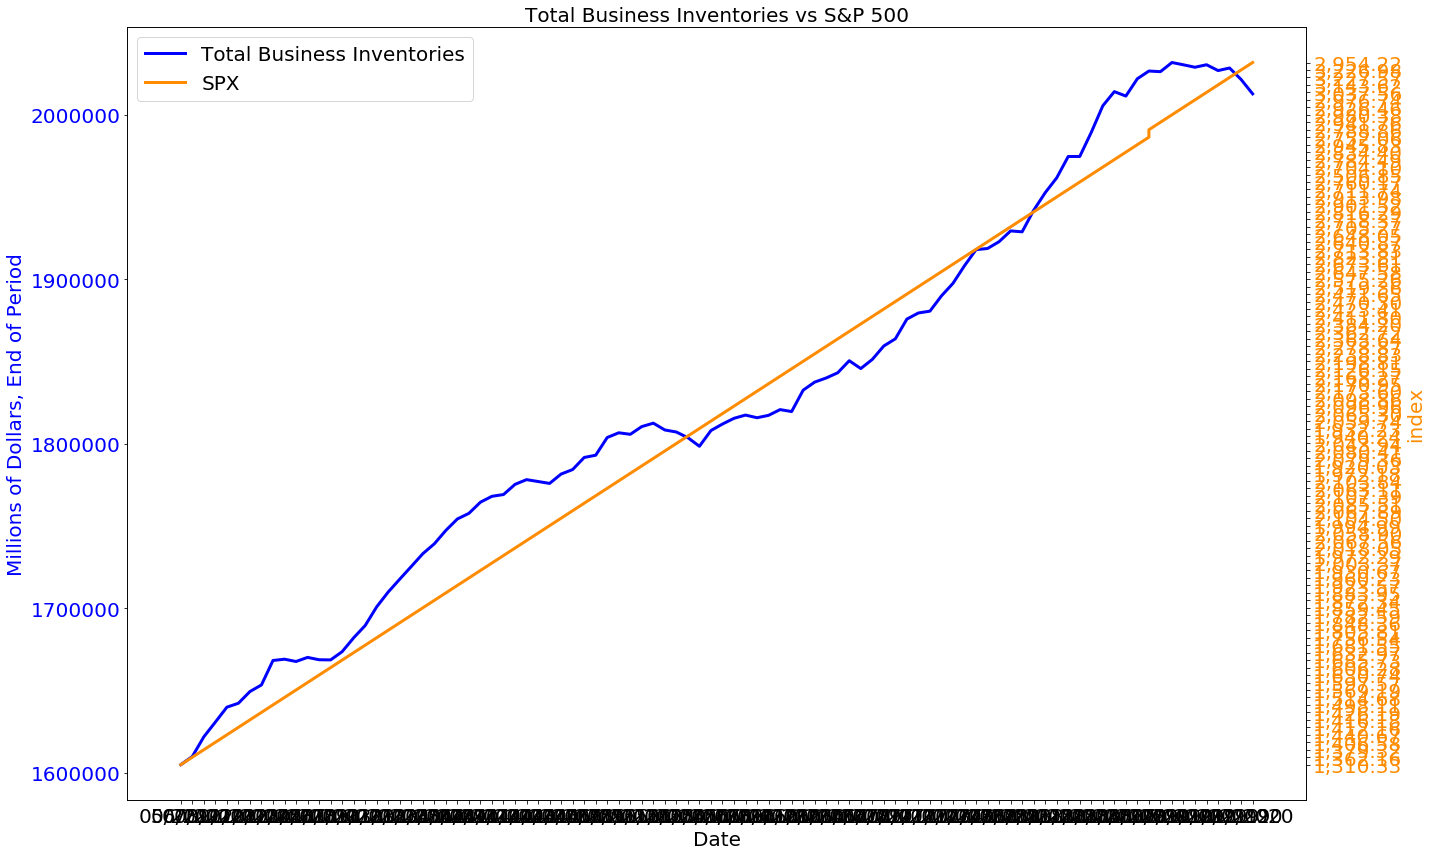

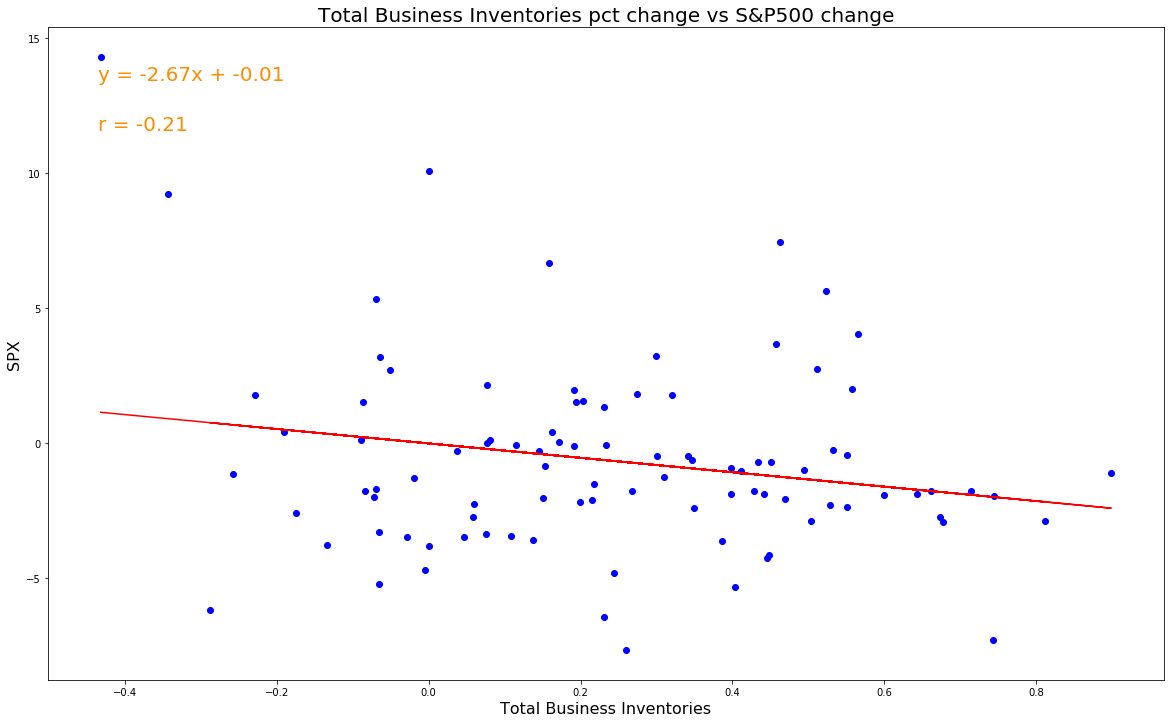

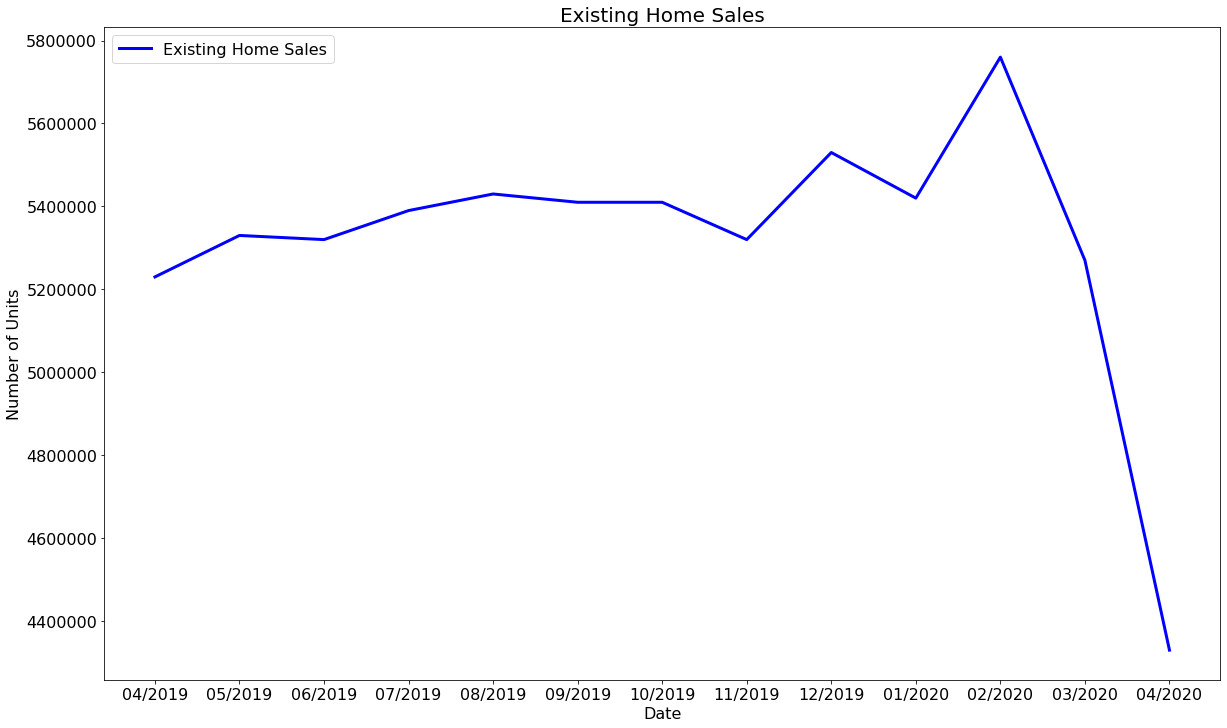

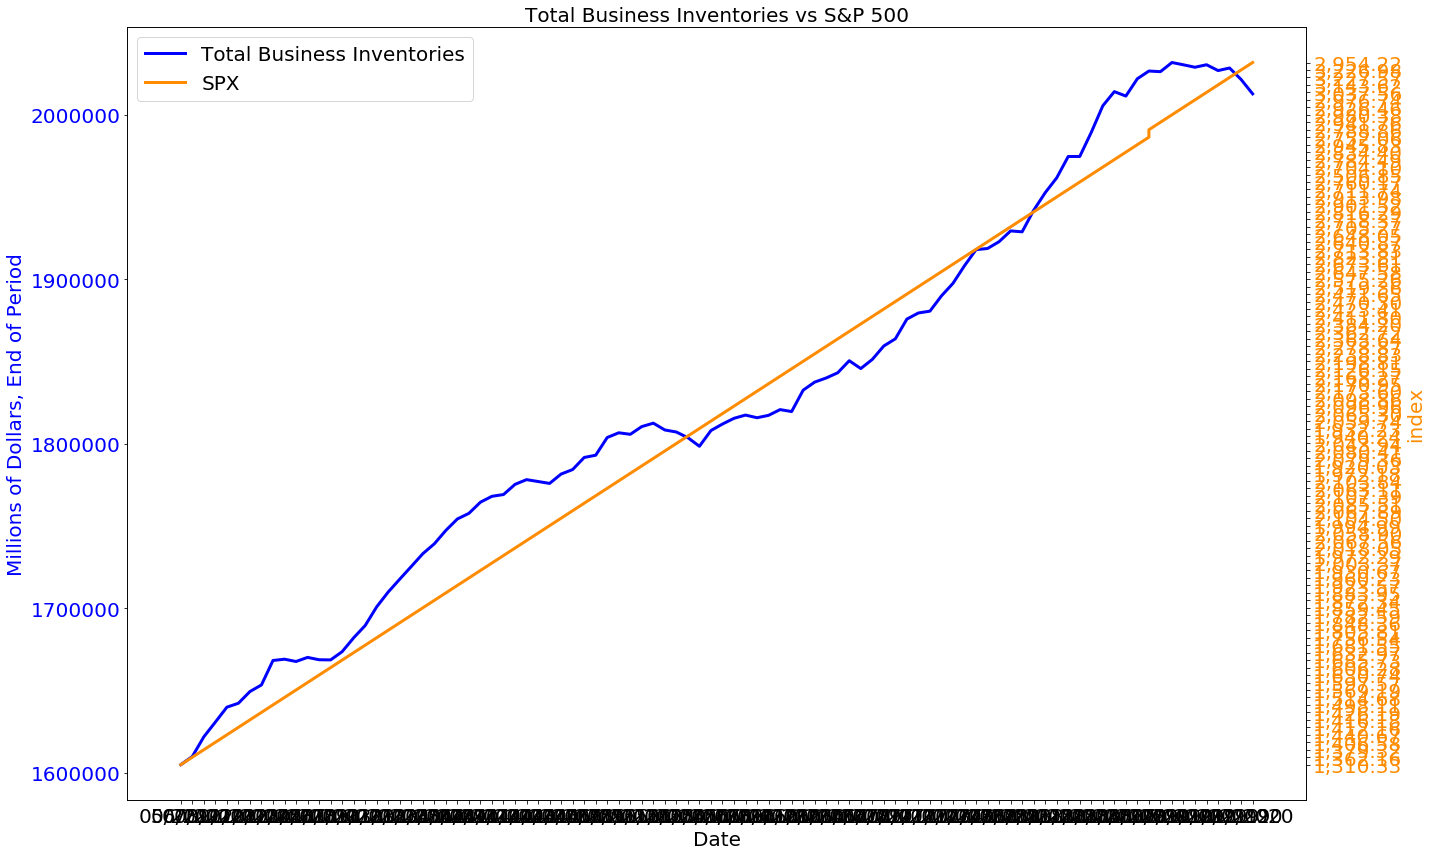

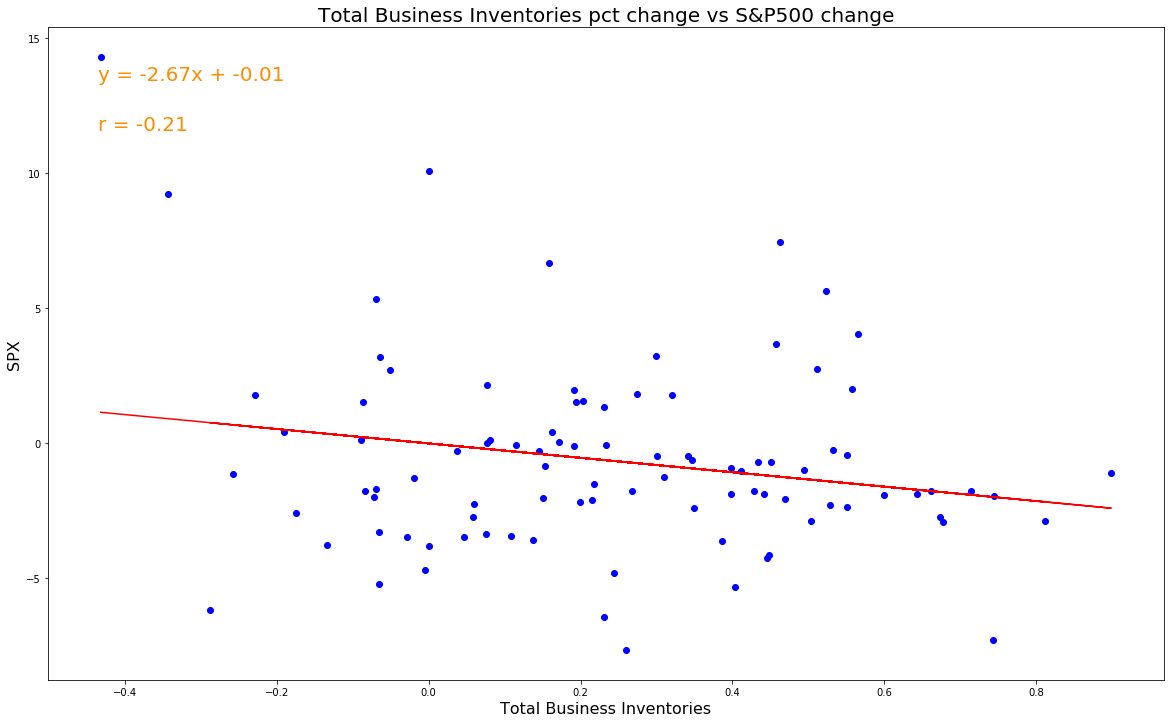

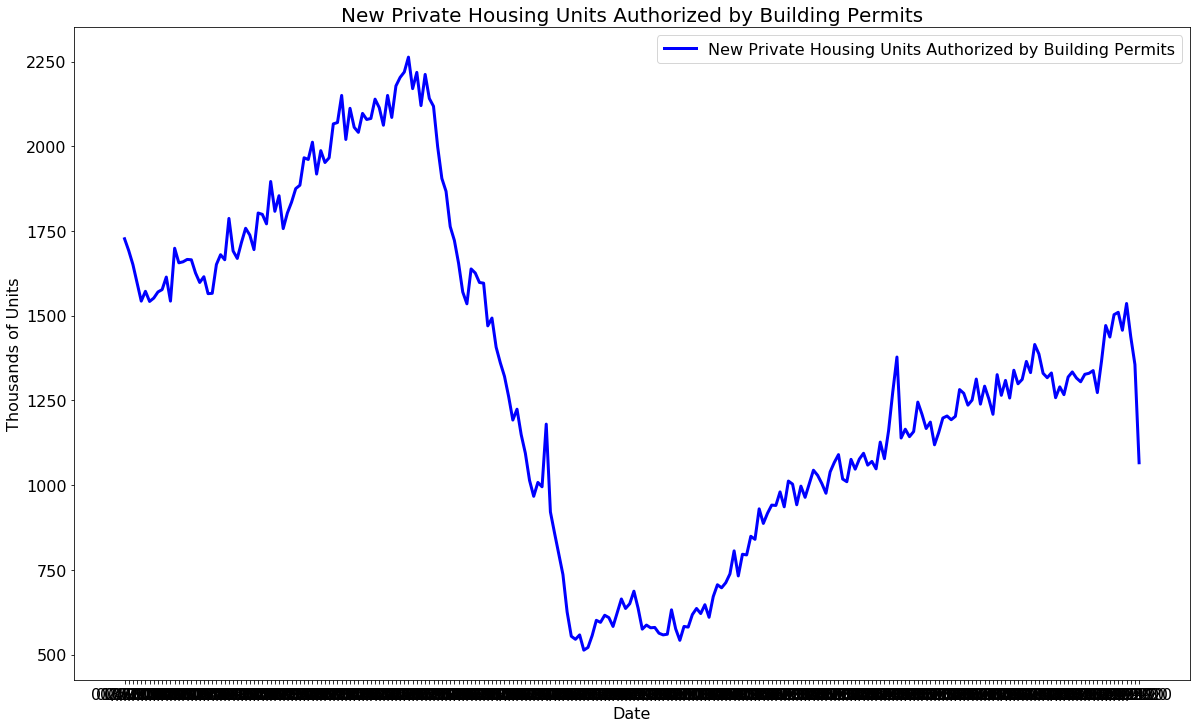

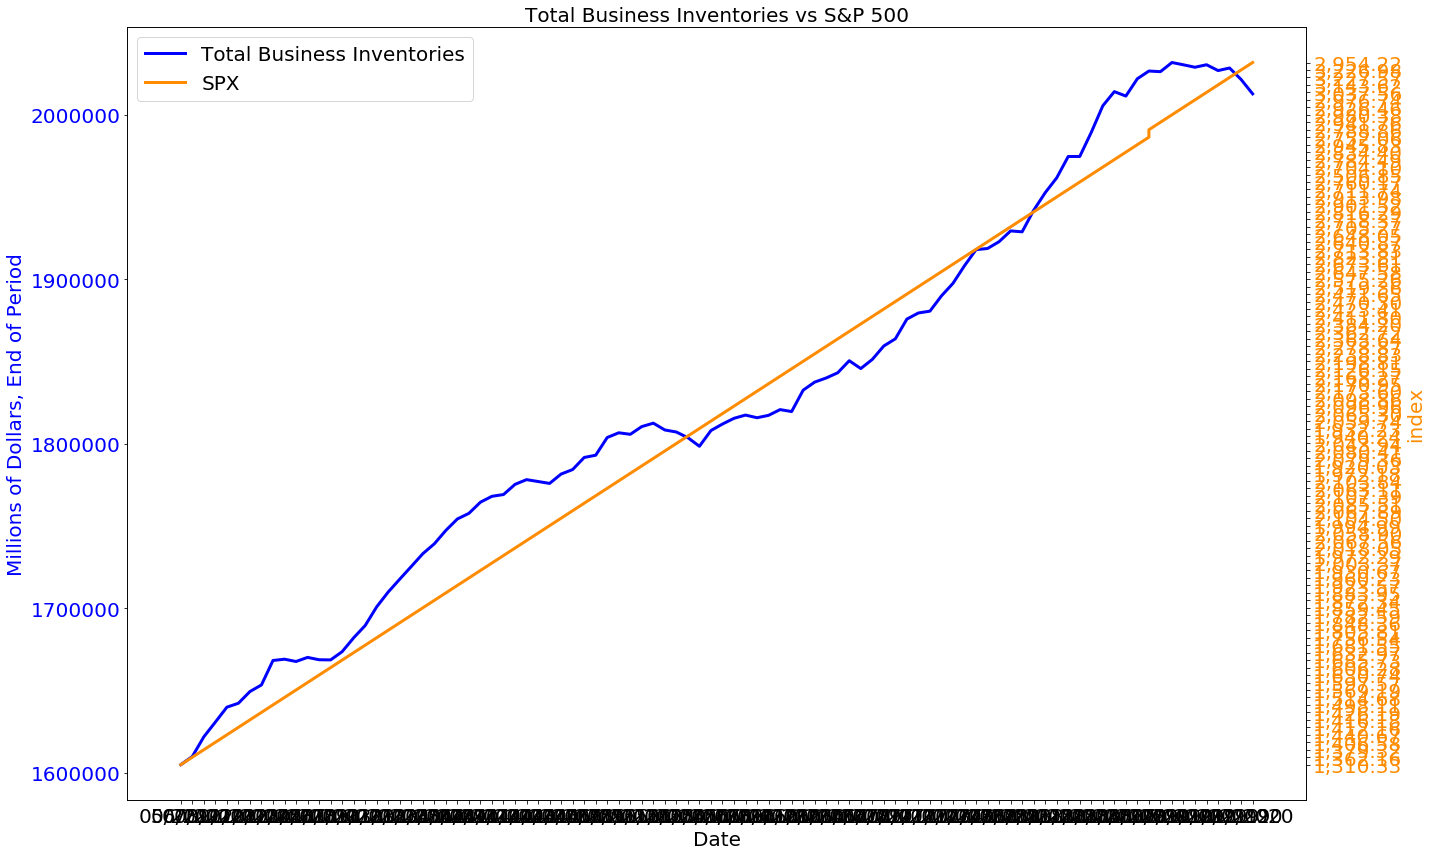

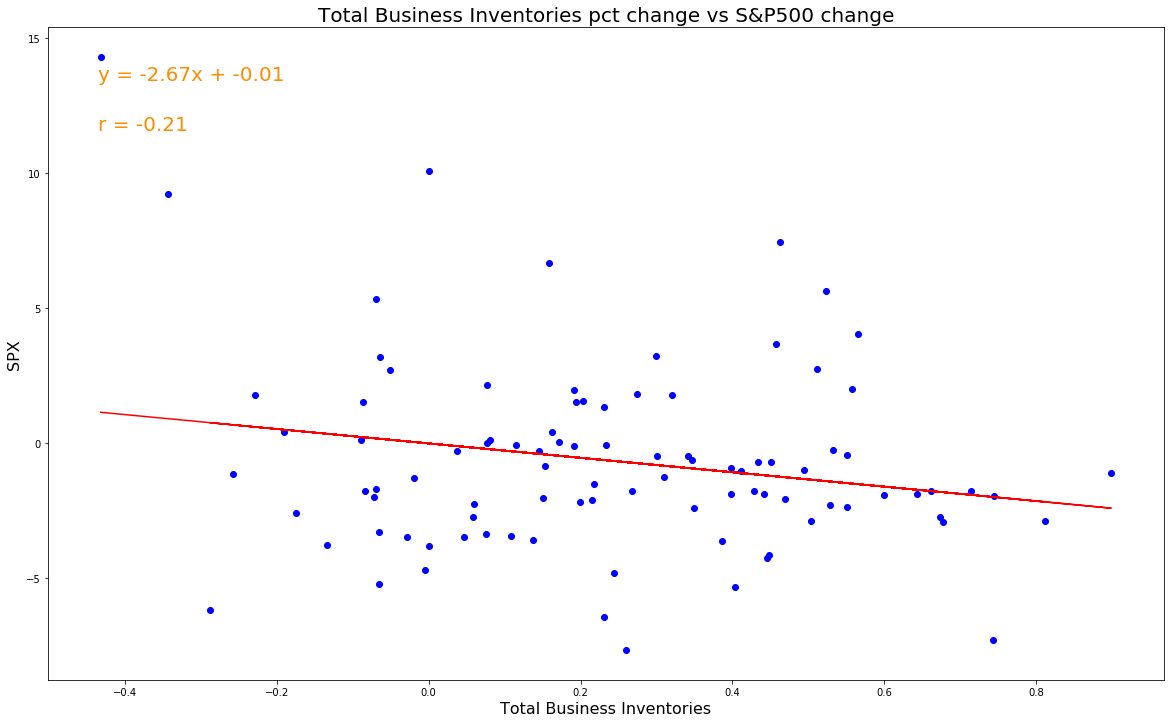

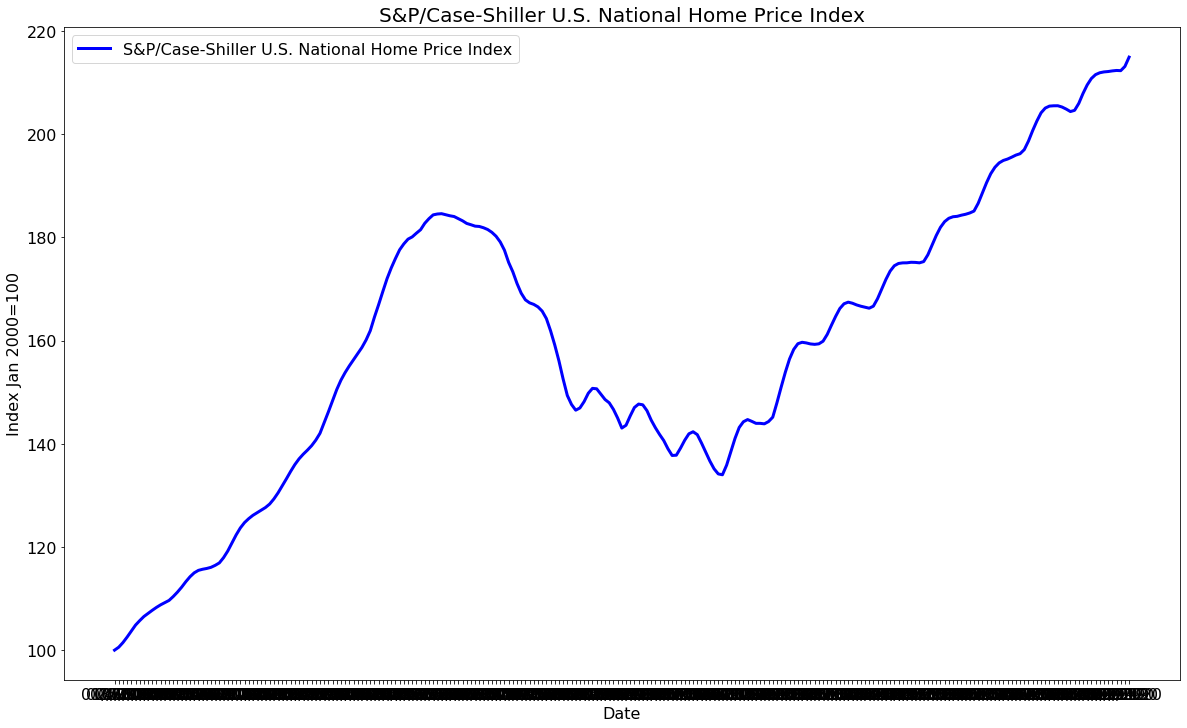

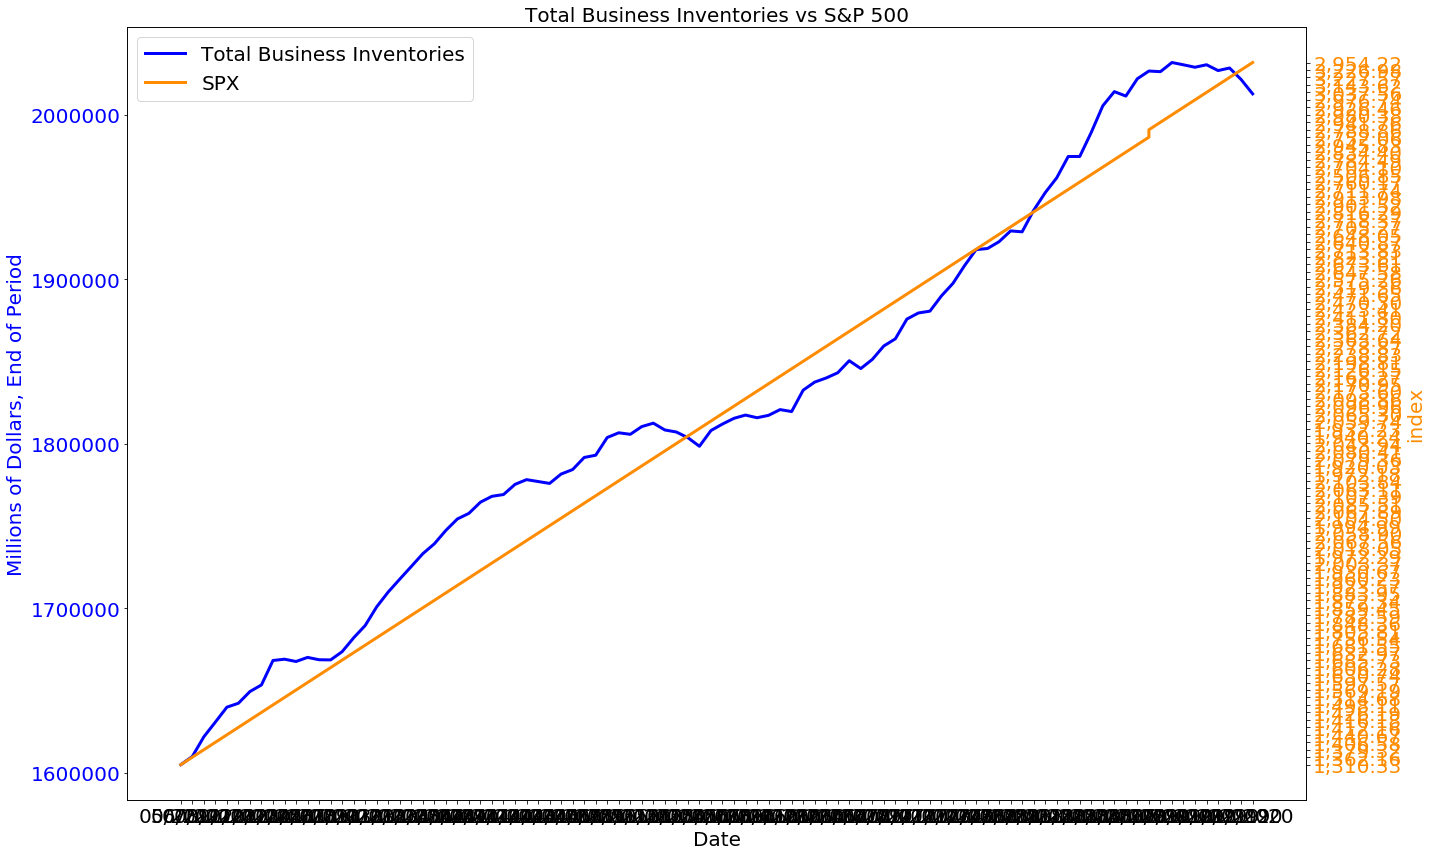

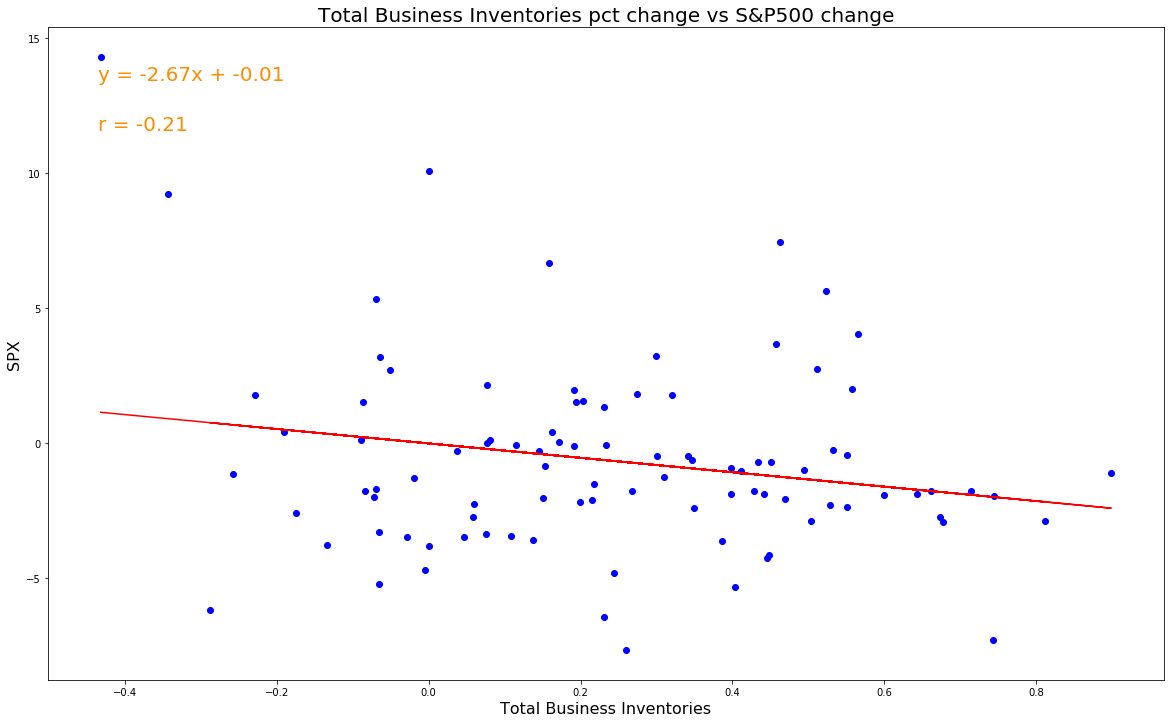

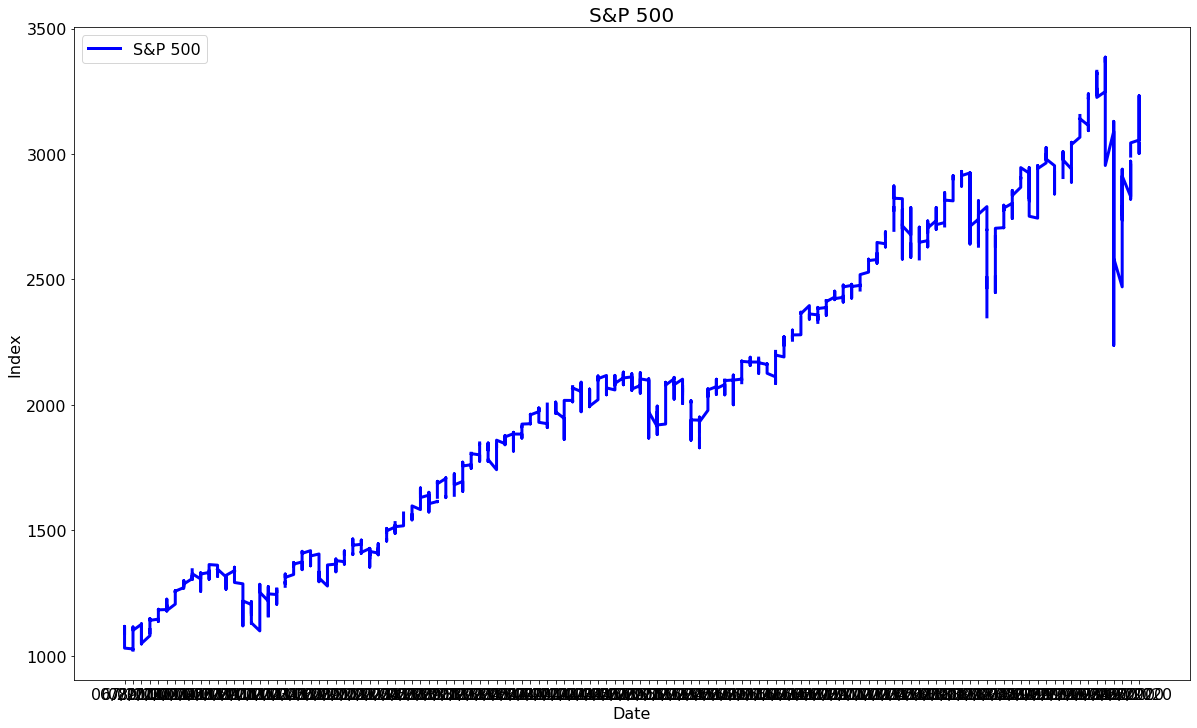

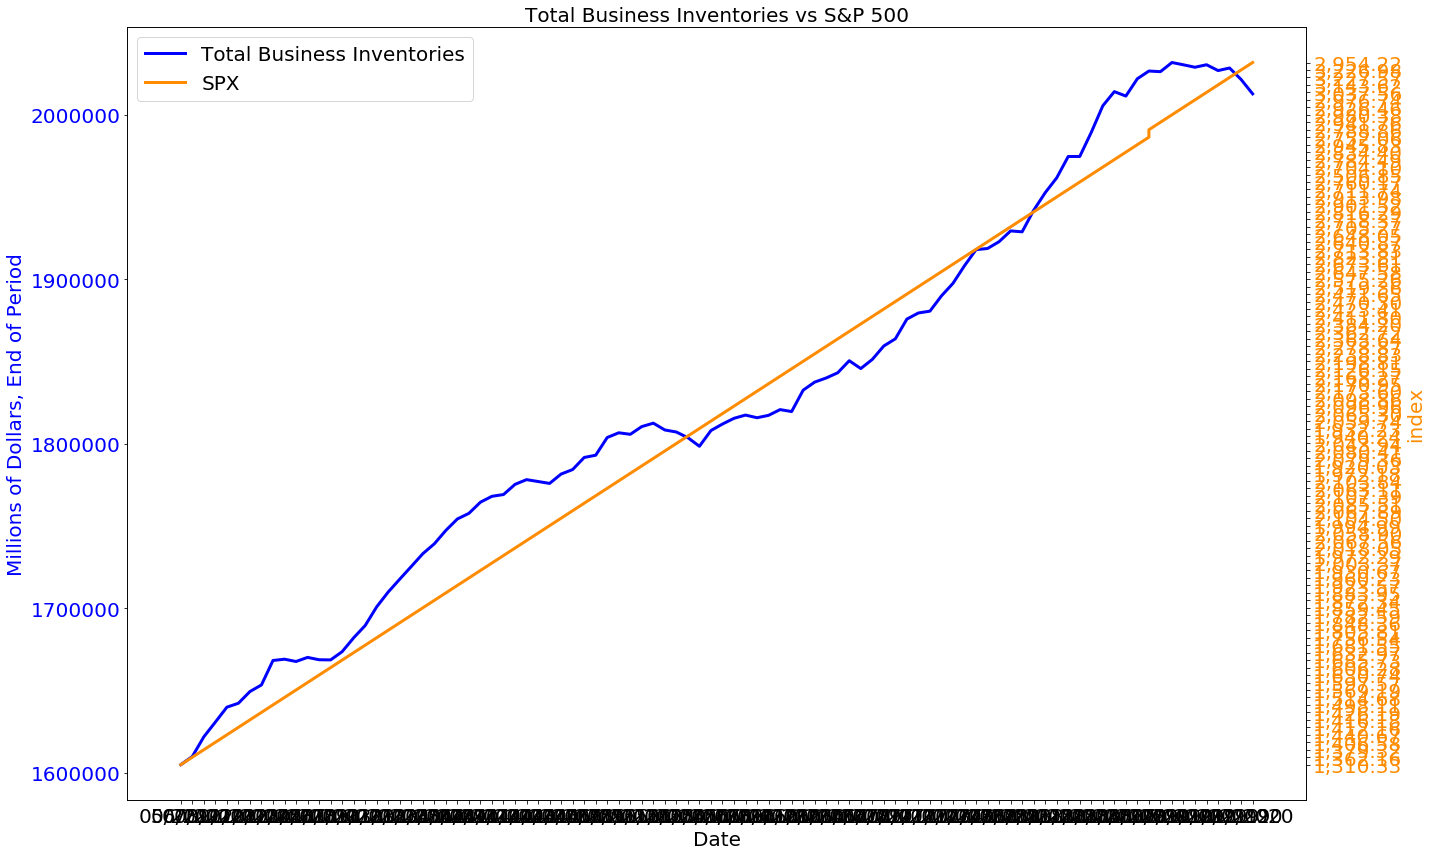

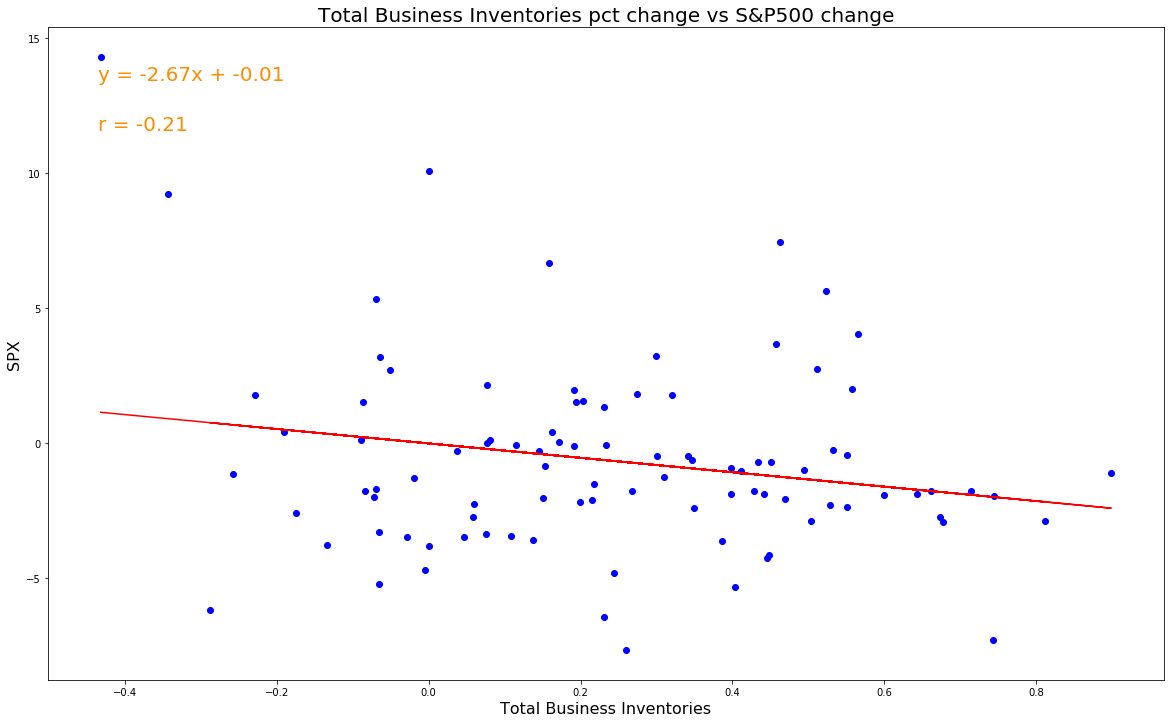

In [29]:
#create dataframe, charts and csv's for each indicator, load to AWS RDS and AWS S3
errors=[]
for indicator in tqdm_notebook(indicators):
    try:
        #get data and info series
        fred_df(indicator)
        #convert date columns to mm-yyyy
        combine_df['date'] = pd.to_datetime(combine_df['date']).dt.strftime('%m/%Y')
        combine_df.to_csv(f"data/{indicator}.csv",index = False, header = True)
        #merge df's
        df = pd.merge(test_df, spx_df, left_on='date', right_on = 'Date')


        #line chart for indicator
        plt.figure(figsize=(20,12))
        plt.plot(combine_df['date'],combine_df['data'], color = "blue", label=f"{combine_df.iloc[0,7]}", linewidth=3)
        plt.title(f"{combine_df.iloc[0,7]}", fontsize=20)
        plt.xlabel("Date", fontsize=16)
        plt.ylabel(f"{combine_df.iloc[0,12]}", fontsize=16)
        plt.xticks(np.arange(min(x), max(x)+1, 1.0))
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(loc="best", fontsize=16)
        plt.savefig(f"images/{indicator}_line.png")

        #indicator level vs SPX level
        fig,ax1 = plt.subplots(figsize=(20,12))
        ax1.set_title(f"{df.iloc[0,7]} vs S&P 500", fontsize=20)
        ax1.set_xlabel("Date", fontsize=20)
        ax1.set_ylabel(f"{df.iloc[0,12]}", fontsize=20, color="blue")
        ax1.plot(df['date'],df['data'], color = "blue", label=f"{df.iloc[0,7]}", linewidth=3)
        ax1.tick_params(axis='y', labelcolor="blue", labelsize=20)
        ax1.tick_params(axis='x', labelsize=20)
        ax2 = ax1.twinx()
        ax2.set_ylabel("index", fontsize=20, color="darkorange")
        ax2.plot(df['Date'],df['SPX Close'], color = "darkorange", label="SPX", linewidth=3)
        ax2.tick_params(axis='y', labelcolor="darkorange", labelsize=20)
        fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes, fontsize=20)
        fig.tight_layout()
        plt.savefig(f"images/{indicator}_spx_line.png")

        #run line regression
        plt.figure(figsize=(20,12))
        x_values = df['pct_change_x']
        y_values = df['pct_change_y']
        (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
        regress_values = x_values * slope + intercept
        line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        plt.scatter(x_values,y_values, color="blue")
        plt.plot(x_values,regress_values,"r-")
        plt.annotate(line_eq,(50,600),fontsize=20,color="darkorange", xycoords="axes points")
        plt.annotate(f'r = {str(round(rvalue,2))}',(50,550),fontsize=20,color="darkorange", xycoords="axes points")
        plt.title(f'{df.iloc[0,7]} pct change vs S&P500 change', fontsize=20)
        plt.xlabel(f"{df.iloc[0,7]}", fontsize=16)
        plt.ylabel("SPX", fontsize=16)
        plt.savefig(f"images/{indicator}_spx_regress.png")
        

        time.sleep(0.2)
        print(f'{indicator} retrieved.')
    except Exception as e: 
        print(f'error with {indicator} data. Proceeding...')
        print(e)
        errors.append(indicator)
        

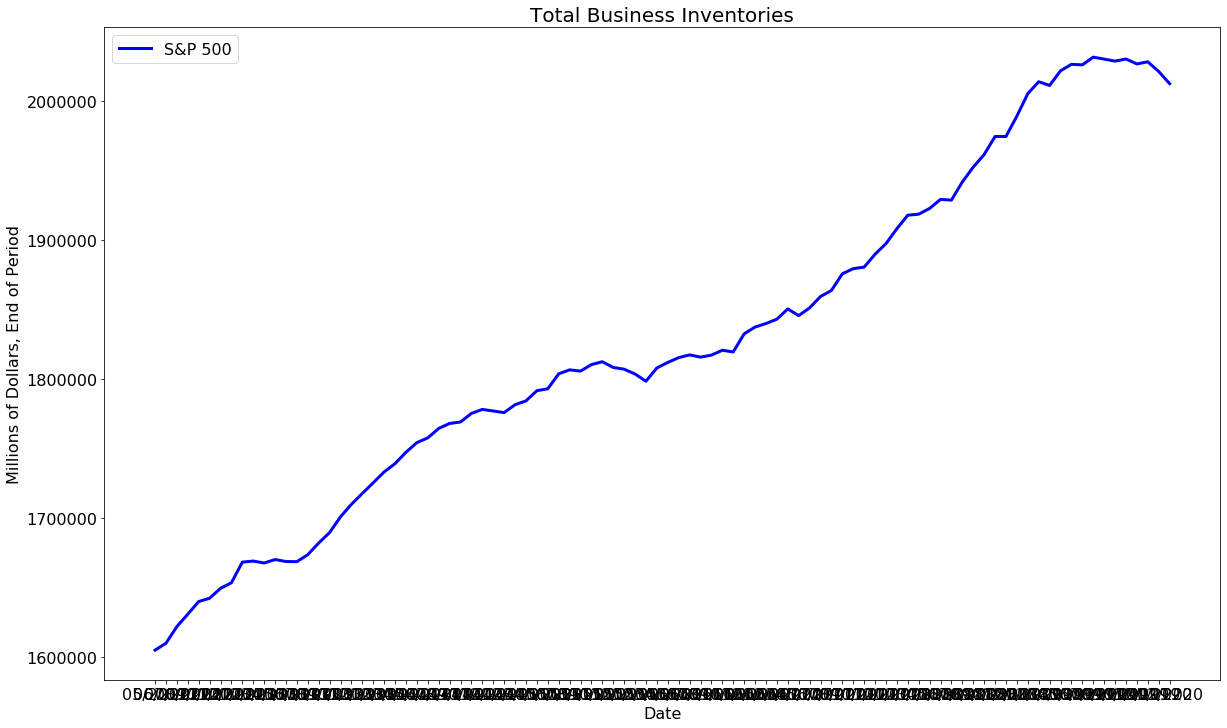

In [37]:
plt.figure(figsize=(20,12))
plt.plot(test_df['date'],test_df['data'], color = "blue", label=f"{combine_df.iloc[0,7]}", linewidth=3)
plt.title(f"{test_df.iloc[0,7]}", fontsize=20)
plt.xlabel("Date", fontsize=16)
plt.ylabel(f"{test_df.iloc[0,12]}", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="best", fontsize=16)

plt.savefig(f"images/{indicator}_line.png")

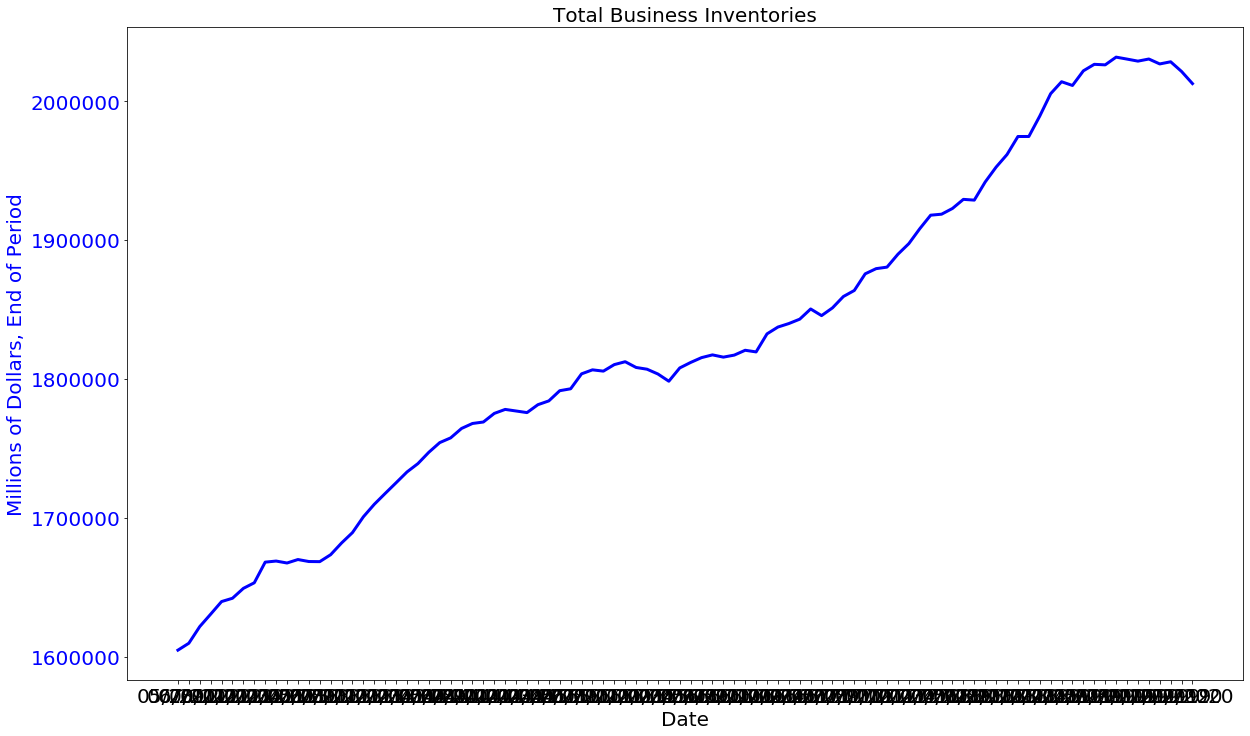

In [44]:

fig, ax = plt.subplots(figsize=(20,12))
ax.set_title(f"{test_df.iloc[0,7]}", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel(f"{test_df.iloc[0,12]}", fontsize=20, color="blue")
ax.plot(test_df['date'],test_df['data'], color = "blue", label=f"{test_df.iloc[0,7]}", linewidth=3)

ax.tick_params(axis='y', labelcolor="blue", labelsize=20)
ax.tick_params(axis='x', labelsize=20)

# # format the ticks
# ax.xaxis.set_major_locator(years)
# ax.xaxis.set_major_formatter(years_fmt)
# ax.xaxis.set_minor_locator(months)

# # round to nearest years.
# datemin = np.datetime64(data['date'][0], 'Y')
# datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlim(datemin, datemax)

# # format the coords message box
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
# ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
# fig.autofmt_xdate()

# plt.show()

In [48]:
df.dtypes

date                          object
data                         float64
change_x                     float64
pct_change_x                 float64
id                            object
realtime_start                object
realtime_end                  object
title                         object
observation_start             object
observation_end               object
frequency                     object
frequency_short               object
units                         object
units_short                   object
seasonal_adjustment           object
seasonal_adjustment_short     object
last_updated                  object
popularity                     int64
notes                         object
Date                          object
pct_change_y                 float64
change_y                     float64
SPX Close                     object
SPX Adj. Close               float64
dtype: object

In [49]:
df['date'] = pd.to_datetime(df['date'])

In [51]:
df.head()

date       data  change_x  pct_change_x      id realtime_start  \
0 2012-05-01  1604862.0       0.0         0.000  BUSINV     2020-04-29   
1 2012-06-01  1609840.0    4978.0         0.310  BUSINV     2020-04-29   
2 2012-07-01  1621825.0   11985.0         0.744  BUSINV     2020-04-29   
3 2012-08-01  1630762.0    8937.0         0.551  BUSINV     2020-04-29   
4 2012-09-01  1639842.0    9080.0         0.557  BUSINV     2020-04-29   

  realtime_end                       title observation_start observation_end  \
0   2020-04-29  Total Business Inventories        1992-01-01      2020-02-01   
1   2020-04-29  Total Business Inventories        1992-01-01      2020-02-01   
2   2020-04-29  Total Business Inventories        1992-01-01      2020-02-01   
3   2020-04-29  Total Business Inventories        1992-01-01      2020-02-01   
4   2020-04-29  Total Business Inventories        1992-01-01      2020-02-01   

                frequency frequency_short                               units  \
0  Monthly, End of Period               M  Millions of Dollars, End of Period   
1  Monthly, End of Period               M  Millions of Dollars, End of Period   
2  Monthly, End of Period               M  Millions of Dollars, End of Period   
3  Monthly, End of Period               M  Millions of Dollars, End of Period   
4  Monthly, End of Period               M  Millions of Dollars, End of Period   

                units_short  seasonal_adjustment seasonal_adjustment_short  \
0  Mil. of $, End of Period  Seasonally Adjusted                        SA   
1  Mil. of $, End of Period  Seasonally Adjusted                        SA   
2  Mil. of $, End of Period  Seasonally Adjusted                        SA   
3  Mil. of $, End of Period  Seasonally Adjusted                        SA   
4  Mil. of $, End of Period  Seasonally Adjusted                        SA   

             last_updated  popularity  \
0  2020-04-15 09:11:31-05          55   
1  2020-04-15 09:11:31-05          55   
2  2020-04-15 09:11:31-05          55   
3  2020-04-15 09:11:31-05          55   
4  2020-04-15 09:11:31-05          55   

                                               notes     Date  pct_change_y  \
0  Effective June 14, 2001, data were reconstruct...  05/2012        -3.805   
1  Effective June 14, 2001, data were reconstruct...  06/2012        -1.244   
2  Effective June 14, 2001, data were reconstruct...  07/2012        -1.938   
3  Effective June 14, 2001, data were reconstruct...  08/2012        -2.366   
4  Effective June 14, 2001, data were reconstruct...  09/2012         2.019   

   change_y SPX Close  SPX Adj. Close  
0    -51.83  1,310.33         1310.33  
1    -17.16  1,362.16         1362.16  
2    -27.26  1,379.32         1379.32  
3    -34.09  1,406.58         1406.58  
4     28.51  1,440.67         1440.67